<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [18]:
# Set your student number
student_number = 99109166
Name = 'َArman'
Last_Name = 'Lotflalikhani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [183]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [184]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [185]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [186]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

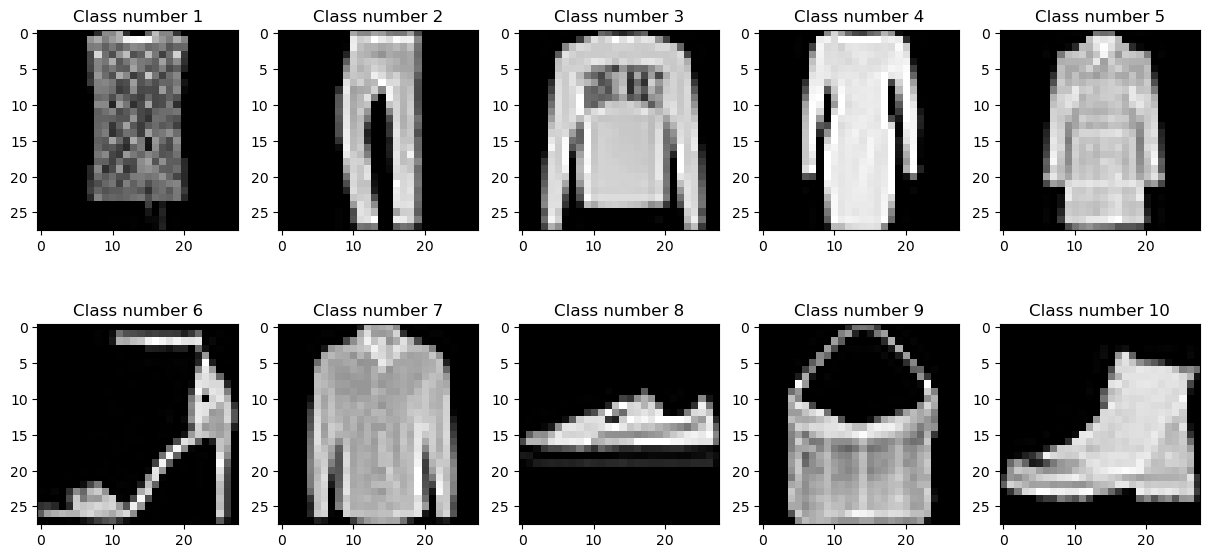

In [271]:
fig1,axs1=plt.subplots(2,5,figsize=(15,7))
rng=np.random.default_rng()
for i in range(10):
    index = rng.integers(len(train_set))
    image, label = train_set[index]
    while (label!=i):
        index = rng.integers(len(train_set))
        image, label = train_set[index]
    axs1[i//5][i%5].title.set_text("Class number %i" %(i+1))
    axs1[i//5][i%5].imshow(image[0], cmap="gray")
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [188]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [253]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [190]:
def affine_forward(x, w, b):
    ## FILL HERE
    return torch.matmul(x,w)+b #evaluates w.T @x+b

def relu(x):
    ## FILL HERE
    return torch.maximum(x,torch.Tensor([0]).to(device))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [191]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    ## FILL HERE
    output=torch.clone(x)
    for i in range(num_layers-1):
        output=affine_forward(output,parameters[f'w{i}'],parameters[f'b{i}'])
        output=relu(output)
    output=affine_forward(output,parameters[f'w{num_layers-1}'],parameters[f'b{num_layers-1}'])
    ##note: the last layer output goes to a cross entropy loss (with softmax) so does not need relu function
    return output

Implementing cross entropy loss:

In [192]:
def cross_entropy_loss(scores, y):
    log_sum_exp=torch.log(torch.sum(torch.exp(scores),1))
    z=torch.arange(len(y),device=device)#.to(device)
    return torch.sum(log_sum_exp)-torch.sum(scores[z,y])

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [213]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for i in range(num_layers):
        w=parameters[f'w{i}']
        b=parameters[f'b{i}']
        with torch.no_grad():#temporarily sets requires_grad to false
            w-=learning_rate*w.grad
            b-=learning_rate*b.grad
        w.grad.zero_()
        b.grad.zero_()
        parameters.update({f'w{i}': w, f'b{i}': b})

Training functions:

In [249]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    acc=np.sum(np.equal(y_pred,y_true))/len(y_pred)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using loss.backward() method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)#p is not a vector of probabilites. its softmax will be.
        
        ## FILL HERE
        loss=cross_entropy_loss(p, y)
        loss.retain_grad()
        if (torch.isinf(loss)==False):
            loss.backward()
            train_loss+=loss.item()/N_train
            sgd_optimizer(parameters, learning_rate)
        else:
            train_loss=5 #our normalized loss is usually between 0 and 1, so this represents infinity
        print('Epoch: %i Batch: %i  Loss: %f'%(epoch,i,loss.item()))
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        #break

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(loader):#it was train-loader before
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        '''As we only need the loss function in the end, and the softmax is implemented there,
        it does not matter that p itself is not a probability vector. Softmax also has no effect on the argmax function
        used later in this function'''
        loss=cross_entropy_loss(p, y)
        if (torch.isinf(loss)==False):
            total_loss=total_loss+loss.item()
            print('Epoch: %i Batch: %i  Loss: %f'%(epoch,i,loss.item())) 
        else:
            total_loss=total_loss+10000 #10000 is used in place of inf
            print('Epoch: %i Batch: %i  Loss: inf'%(epoch,i))
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        #break
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [254]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [255]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):#num_epochs
        ## FILL HERE
        ## You should calculate the train and test loss and accuracies for each epoch and add them to
        ## the lists `train_losses`, `test_losses`, `train_accuracies` and `test_accuracies`
        train_loss,train_acc=train(train_loader, learning_rate, epoch)
        test_loss,test_acc=validate(test_loader, epoch, set_name='test')
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    '''This loop is out of the provided space, but "printing the train and test losses and accuracies" 
    is requsted so there is no other choice. there is also no logic in the mentioned part'''
    # print all vals
    for epoch in range(num_epochs):
        train_loss=train_losses[i]
        train_acc=train_accuracies[i]
        test_loss=test_losses[i]
        test_acc=test_accuracies[i]
        print('Epoch :%i Train_loss: %f Test_loss: %f Train_accuracy: %f Test accuracy: %f'%(epoch,train_loss,
                                                                                             test_loss,train_acc, test_acc))
    #
    ## plot the loss history of training and test sets 
    ## FILL HERE
    plt.title('Normalized loss on train and test set')
    plt.plot(train_losses,label='Loss on train set')
    plt.plot(test_losses,label='Loss on test set')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    ## plot the accuracy history of training and test sets
    ## FILL HERE
    plt.title('Accuracy on train and test set')
    plt.plot(train_accuracies,label='Accuracy of train set',color='#d62728')
    plt.plot(test_accuracies,label='Accuracy of test set',color='c')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Epoch: 0 Batch: 0  Loss: 147.410583
Epoch: 0 Batch: 1  Loss: 147.322357
Epoch: 0 Batch: 2  Loss: 147.272400
Epoch: 0 Batch: 3  Loss: 147.016632
Epoch: 0 Batch: 4  Loss: 147.303131
Epoch: 0 Batch: 5  Loss: 147.305984
Epoch: 0 Batch: 6  Loss: 146.954178
Epoch: 0 Batch: 7  Loss: 146.731415
Epoch: 0 Batch: 8  Loss: 146.351532
Epoch: 0 Batch: 9  Loss: 146.952408
Epoch: 0 Batch: 10  Loss: 146.237366
Epoch: 0 Batch: 11  Loss: 146.333923
Epoch: 0 Batch: 12  Loss: 145.903992
Epoch: 0 Batch: 13  Loss: 146.018066
Epoch: 0 Batch: 14  Loss: 145.492935
Epoch: 0 Batch: 15  Loss: 145.065857
Epoch: 0 Batch: 16  Loss: 145.594162
Epoch: 0 Batch: 17  Loss: 144.351410
Epoch: 0 Batch: 18  Loss: 143.554504
Epoch: 0 Batch: 19  Loss: 144.248367
Epoch: 0 Batch: 20  Loss: 142.943542
Epoch: 0 Batch: 21  Loss: 142.067444
Epoch: 0 Batch: 22  Loss: 140.365692
Epoch: 0 Batch: 23  Loss: 138.317444
Epoch: 0 Batch: 24  Loss: 135.811951
Epoch: 0 Batch: 25  Loss: 134.648544
Epoch: 0 Batch: 26  Loss: 130.485596
Epoch: 0 Ba

Epoch: 0 Batch: 224  Loss: 63.439941
Epoch: 0 Batch: 225  Loss: 56.197632
Epoch: 0 Batch: 226  Loss: 43.011078
Epoch: 0 Batch: 227  Loss: 50.628632
Epoch: 0 Batch: 228  Loss: 33.352081
Epoch: 0 Batch: 229  Loss: 44.725952
Epoch: 0 Batch: 230  Loss: 51.518433
Epoch: 0 Batch: 231  Loss: 50.688538
Epoch: 0 Batch: 232  Loss: 45.078491
Epoch: 0 Batch: 233  Loss: 47.311035
Epoch: 0 Batch: 234  Loss: 53.602478
Epoch: 0 Batch: 235  Loss: 52.000458
Epoch: 0 Batch: 236  Loss: 46.832947
Epoch: 0 Batch: 237  Loss: 50.596619
Epoch: 0 Batch: 238  Loss: 56.904022
Epoch: 0 Batch: 239  Loss: 49.725311
Epoch: 0 Batch: 240  Loss: 63.918915
Epoch: 0 Batch: 241  Loss: 54.730774
Epoch: 0 Batch: 242  Loss: 51.760345
Epoch: 0 Batch: 243  Loss: 39.490082
Epoch: 0 Batch: 244  Loss: 37.184143
Epoch: 0 Batch: 245  Loss: 40.461792
Epoch: 0 Batch: 246  Loss: 41.696442
Epoch: 0 Batch: 247  Loss: 53.671417
Epoch: 0 Batch: 248  Loss: 48.695007
Epoch: 0 Batch: 249  Loss: 45.378723
Epoch: 0 Batch: 250  Loss: 40.379425
E

Epoch: 0 Batch: 451  Loss: 31.016815
Epoch: 0 Batch: 452  Loss: 31.969116
Epoch: 0 Batch: 453  Loss: 47.543427
Epoch: 0 Batch: 454  Loss: 33.967834
Epoch: 0 Batch: 455  Loss: 35.672150
Epoch: 0 Batch: 456  Loss: 46.939545
Epoch: 0 Batch: 457  Loss: 55.823730
Epoch: 0 Batch: 458  Loss: 47.769257
Epoch: 0 Batch: 459  Loss: 41.579498
Epoch: 0 Batch: 460  Loss: 38.527252
Epoch: 0 Batch: 461  Loss: 35.230743
Epoch: 0 Batch: 462  Loss: 42.469940
Epoch: 0 Batch: 463  Loss: 52.662323
Epoch: 0 Batch: 464  Loss: 24.055084
Epoch: 0 Batch: 465  Loss: 24.733185
Epoch: 0 Batch: 466  Loss: 30.517456
Epoch: 0 Batch: 467  Loss: 35.448242
Epoch: 0 Batch: 468  Loss: 37.909515
Epoch: 0 Batch: 469  Loss: 38.864288
Epoch: 0 Batch: 470  Loss: 24.867188
Epoch: 0 Batch: 471  Loss: 42.736816
Epoch: 0 Batch: 472  Loss: 28.921051
Epoch: 0 Batch: 473  Loss: 43.113525
Epoch: 0 Batch: 474  Loss: 33.897003
Epoch: 0 Batch: 475  Loss: 37.810486
Epoch: 0 Batch: 476  Loss: 36.915680
Epoch: 0 Batch: 477  Loss: 45.589569
E

Epoch: 0 Batch: 673  Loss: 28.668823
Epoch: 0 Batch: 674  Loss: 52.004364
Epoch: 0 Batch: 675  Loss: 36.387634
Epoch: 0 Batch: 676  Loss: 33.769836
Epoch: 0 Batch: 677  Loss: 32.971619
Epoch: 0 Batch: 678  Loss: 36.236694
Epoch: 0 Batch: 679  Loss: 46.907318
Epoch: 0 Batch: 680  Loss: 38.329956
Epoch: 0 Batch: 681  Loss: 28.423157
Epoch: 0 Batch: 682  Loss: 40.932526
Epoch: 0 Batch: 683  Loss: 46.281982
Epoch: 0 Batch: 684  Loss: 31.941162
Epoch: 0 Batch: 685  Loss: 57.438538
Epoch: 0 Batch: 686  Loss: 35.274353
Epoch: 0 Batch: 687  Loss: 29.337830
Epoch: 0 Batch: 688  Loss: 42.316895
Epoch: 0 Batch: 689  Loss: 33.401886
Epoch: 0 Batch: 690  Loss: 24.426025
Epoch: 0 Batch: 691  Loss: 27.829468
Epoch: 0 Batch: 692  Loss: 32.174103
Epoch: 0 Batch: 693  Loss: 28.070251
Epoch: 0 Batch: 694  Loss: 30.684418
Epoch: 0 Batch: 695  Loss: 34.539398
Epoch: 0 Batch: 696  Loss: 35.397247
Epoch: 0 Batch: 697  Loss: 38.174866
Epoch: 0 Batch: 698  Loss: 42.496582
Epoch: 0 Batch: 699  Loss: 50.502563
E

Epoch: 0 Batch: 909  Loss: 20.529785
Epoch: 0 Batch: 910  Loss: 32.952423
Epoch: 0 Batch: 911  Loss: 27.647491
Epoch: 0 Batch: 912  Loss: 30.741760
Epoch: 0 Batch: 913  Loss: 35.155792
Epoch: 0 Batch: 914  Loss: 35.010620
Epoch: 0 Batch: 915  Loss: 27.187531
Epoch: 0 Batch: 916  Loss: 33.949005
Epoch: 0 Batch: 917  Loss: 24.509277
Epoch: 0 Batch: 918  Loss: 34.117401
Epoch: 0 Batch: 919  Loss: 34.222961
Epoch: 0 Batch: 920  Loss: 25.249817
Epoch: 0 Batch: 921  Loss: 31.410492
Epoch: 0 Batch: 922  Loss: 21.321930
Epoch: 0 Batch: 923  Loss: 33.031982
Epoch: 0 Batch: 924  Loss: 35.944855
Epoch: 0 Batch: 925  Loss: 37.013367
Epoch: 0 Batch: 926  Loss: 22.235840
Epoch: 0 Batch: 927  Loss: 29.315796
Epoch: 0 Batch: 928  Loss: 43.926880
Epoch: 0 Batch: 929  Loss: 36.820923
Epoch: 0 Batch: 930  Loss: 31.685455
Epoch: 0 Batch: 931  Loss: 33.062775
Epoch: 0 Batch: 932  Loss: 27.471039
Epoch: 0 Batch: 933  Loss: 24.567871
Epoch: 0 Batch: 934  Loss: 29.888245
Epoch: 0 Batch: 935  Loss: 26.715668
E

Epoch: 1 Batch: 46  Loss: 31.935608
Epoch: 1 Batch: 47  Loss: 27.208710
Epoch: 1 Batch: 48  Loss: 31.939850
Epoch: 1 Batch: 49  Loss: 23.717621
Epoch: 1 Batch: 50  Loss: 29.962219
Epoch: 1 Batch: 51  Loss: 39.436157
Epoch: 1 Batch: 52  Loss: 25.981598
Epoch: 1 Batch: 53  Loss: 25.199615
Epoch: 1 Batch: 54  Loss: 33.393311
Epoch: 1 Batch: 55  Loss: 39.873810
Epoch: 1 Batch: 56  Loss: 25.649170
Epoch: 1 Batch: 57  Loss: 29.989868
Epoch: 1 Batch: 58  Loss: 34.089050
Epoch: 1 Batch: 59  Loss: 26.924164
Epoch: 1 Batch: 60  Loss: 22.111084
Epoch: 1 Batch: 61  Loss: 22.544250
Epoch: 1 Batch: 62  Loss: 35.413208
Epoch: 1 Batch: 63  Loss: 35.176086
Epoch: 1 Batch: 64  Loss: 27.553894
Epoch: 1 Batch: 65  Loss: 29.651306
Epoch: 1 Batch: 66  Loss: 39.414551
Epoch: 1 Batch: 67  Loss: 23.213440
Epoch: 1 Batch: 68  Loss: 32.292603
Epoch: 1 Batch: 69  Loss: 21.011963
Epoch: 1 Batch: 70  Loss: 28.054596
Epoch: 1 Batch: 71  Loss: 42.614410
Epoch: 1 Batch: 72  Loss: 32.517395
Epoch: 1 Batch: 73  Loss: 28

Epoch: 1 Batch: 269  Loss: 41.494934
Epoch: 1 Batch: 270  Loss: 59.748718
Epoch: 1 Batch: 271  Loss: 38.171143
Epoch: 1 Batch: 272  Loss: 56.519104
Epoch: 1 Batch: 273  Loss: 46.164886
Epoch: 1 Batch: 274  Loss: 45.329498
Epoch: 1 Batch: 275  Loss: 22.633423
Epoch: 1 Batch: 276  Loss: 25.049927
Epoch: 1 Batch: 277  Loss: 33.169312
Epoch: 1 Batch: 278  Loss: 24.316040
Epoch: 1 Batch: 279  Loss: 25.174591
Epoch: 1 Batch: 280  Loss: 16.722473
Epoch: 1 Batch: 281  Loss: 30.366333
Epoch: 1 Batch: 282  Loss: 30.422974
Epoch: 1 Batch: 283  Loss: 25.926270
Epoch: 1 Batch: 284  Loss: 29.150238
Epoch: 1 Batch: 285  Loss: 28.549500
Epoch: 1 Batch: 286  Loss: 35.419281
Epoch: 1 Batch: 287  Loss: 32.801575
Epoch: 1 Batch: 288  Loss: 22.320740
Epoch: 1 Batch: 289  Loss: 18.387787
Epoch: 1 Batch: 290  Loss: 33.835175
Epoch: 1 Batch: 291  Loss: 25.767334
Epoch: 1 Batch: 292  Loss: 22.424255
Epoch: 1 Batch: 293  Loss: 28.845520
Epoch: 1 Batch: 294  Loss: 27.874023
Epoch: 1 Batch: 295  Loss: 28.392517
E

Epoch: 1 Batch: 503  Loss: 35.140503
Epoch: 1 Batch: 504  Loss: 23.349213
Epoch: 1 Batch: 505  Loss: 20.430115
Epoch: 1 Batch: 506  Loss: 32.950806
Epoch: 1 Batch: 507  Loss: 29.120117
Epoch: 1 Batch: 508  Loss: 23.509155
Epoch: 1 Batch: 509  Loss: 21.410950
Epoch: 1 Batch: 510  Loss: 24.334229
Epoch: 1 Batch: 511  Loss: 29.272583
Epoch: 1 Batch: 512  Loss: 33.315369
Epoch: 1 Batch: 513  Loss: 23.160431
Epoch: 1 Batch: 514  Loss: 34.914307
Epoch: 1 Batch: 515  Loss: 36.078278
Epoch: 1 Batch: 516  Loss: 29.431213
Epoch: 1 Batch: 517  Loss: 32.097107
Epoch: 1 Batch: 518  Loss: 27.143921
Epoch: 1 Batch: 519  Loss: 32.970703
Epoch: 1 Batch: 520  Loss: 16.976257
Epoch: 1 Batch: 521  Loss: 20.419983
Epoch: 1 Batch: 522  Loss: 28.335876
Epoch: 1 Batch: 523  Loss: 22.535522
Epoch: 1 Batch: 524  Loss: 30.536926
Epoch: 1 Batch: 525  Loss: 18.673767
Epoch: 1 Batch: 526  Loss: 21.385742
Epoch: 1 Batch: 527  Loss: 24.880310
Epoch: 1 Batch: 528  Loss: 24.214294
Epoch: 1 Batch: 529  Loss: 30.973145
E

Epoch: 1 Batch: 738  Loss: 22.324829
Epoch: 1 Batch: 739  Loss: 24.600952
Epoch: 1 Batch: 740  Loss: 27.985962
Epoch: 1 Batch: 741  Loss: 17.000000
Epoch: 1 Batch: 742  Loss: 35.099243
Epoch: 1 Batch: 743  Loss: 30.075195
Epoch: 1 Batch: 744  Loss: 22.462219
Epoch: 1 Batch: 745  Loss: 30.194702
Epoch: 1 Batch: 746  Loss: 27.472839
Epoch: 1 Batch: 747  Loss: 24.869446
Epoch: 1 Batch: 748  Loss: 15.550903
Epoch: 1 Batch: 749  Loss: 20.039978
Epoch: 1 Batch: 750  Loss: 26.280884
Epoch: 1 Batch: 751  Loss: 32.893066
Epoch: 1 Batch: 752  Loss: 31.702881
Epoch: 1 Batch: 753  Loss: 30.002625
Epoch: 1 Batch: 754  Loss: 38.963501
Epoch: 1 Batch: 755  Loss: 28.626892
Epoch: 1 Batch: 756  Loss: 28.393768
Epoch: 1 Batch: 757  Loss: 29.939209
Epoch: 1 Batch: 758  Loss: 27.410919
Epoch: 1 Batch: 759  Loss: 29.055511
Epoch: 1 Batch: 760  Loss: 19.488922
Epoch: 1 Batch: 761  Loss: 31.928955
Epoch: 1 Batch: 762  Loss: 33.402832
Epoch: 1 Batch: 763  Loss: 33.185059
Epoch: 1 Batch: 764  Loss: 35.726685
E

Epoch: 1 Batch: 30  Loss: 20.788727
Epoch: 1 Batch: 31  Loss: 38.396790
Epoch: 1 Batch: 32  Loss: 31.177826
Epoch: 1 Batch: 33  Loss: 31.874268
Epoch: 1 Batch: 34  Loss: 22.463196
Epoch: 1 Batch: 35  Loss: 25.831940
Epoch: 1 Batch: 36  Loss: 33.787231
Epoch: 1 Batch: 37  Loss: 28.497070
Epoch: 1 Batch: 38  Loss: 25.887268
Epoch: 1 Batch: 39  Loss: 28.088318
Epoch: 1 Batch: 40  Loss: 23.428101
Epoch: 1 Batch: 41  Loss: 30.364410
Epoch: 1 Batch: 42  Loss: 26.733734
Epoch: 1 Batch: 43  Loss: 26.782715
Epoch: 1 Batch: 44  Loss: 26.000244
Epoch: 1 Batch: 45  Loss: 20.691406
Epoch: 1 Batch: 46  Loss: 33.061462
Epoch: 1 Batch: 47  Loss: 32.162109
Epoch: 1 Batch: 48  Loss: 17.634583
Epoch: 1 Batch: 49  Loss: 30.640076
Epoch: 1 Batch: 50  Loss: 23.057068
Epoch: 1 Batch: 51  Loss: 28.384827
Epoch: 1 Batch: 52  Loss: 28.883667
Epoch: 1 Batch: 53  Loss: 29.065155
Epoch: 1 Batch: 54  Loss: 37.861786
Epoch: 1 Batch: 55  Loss: 36.702881
Epoch: 1 Batch: 56  Loss: 21.386108
Epoch: 1 Batch: 57  Loss: 24

Epoch: 2 Batch: 108  Loss: 21.856750
Epoch: 2 Batch: 109  Loss: 31.037231
Epoch: 2 Batch: 110  Loss: 17.715576
Epoch: 2 Batch: 111  Loss: 26.711426
Epoch: 2 Batch: 112  Loss: 16.614441
Epoch: 2 Batch: 113  Loss: 14.594177
Epoch: 2 Batch: 114  Loss: 41.088501
Epoch: 2 Batch: 115  Loss: 33.302368
Epoch: 2 Batch: 116  Loss: 40.863464
Epoch: 2 Batch: 117  Loss: 36.811951
Epoch: 2 Batch: 118  Loss: 25.202484
Epoch: 2 Batch: 119  Loss: 16.821747
Epoch: 2 Batch: 120  Loss: 26.468262
Epoch: 2 Batch: 121  Loss: 14.997681
Epoch: 2 Batch: 122  Loss: 21.055969
Epoch: 2 Batch: 123  Loss: 23.452271
Epoch: 2 Batch: 124  Loss: 17.008606
Epoch: 2 Batch: 125  Loss: 20.784302
Epoch: 2 Batch: 126  Loss: 26.922760
Epoch: 2 Batch: 127  Loss: 30.443054
Epoch: 2 Batch: 128  Loss: 27.292053
Epoch: 2 Batch: 129  Loss: 14.962891
Epoch: 2 Batch: 130  Loss: 16.236450
Epoch: 2 Batch: 131  Loss: 23.810059
Epoch: 2 Batch: 132  Loss: 29.524841
Epoch: 2 Batch: 133  Loss: 28.959961
Epoch: 2 Batch: 134  Loss: 34.269287
E

Epoch: 2 Batch: 334  Loss: 29.708923
Epoch: 2 Batch: 335  Loss: 35.852722
Epoch: 2 Batch: 336  Loss: 35.431061
Epoch: 2 Batch: 337  Loss: 34.761841
Epoch: 2 Batch: 338  Loss: 26.064819
Epoch: 2 Batch: 339  Loss: 24.415405
Epoch: 2 Batch: 340  Loss: 23.158020
Epoch: 2 Batch: 341  Loss: 22.015869
Epoch: 2 Batch: 342  Loss: 33.185425
Epoch: 2 Batch: 343  Loss: 31.226501
Epoch: 2 Batch: 344  Loss: 23.085632
Epoch: 2 Batch: 345  Loss: 20.448547
Epoch: 2 Batch: 346  Loss: 22.837402
Epoch: 2 Batch: 347  Loss: 16.725220
Epoch: 2 Batch: 348  Loss: 19.376953
Epoch: 2 Batch: 349  Loss: 24.961792
Epoch: 2 Batch: 350  Loss: 20.511597
Epoch: 2 Batch: 351  Loss: 23.572876
Epoch: 2 Batch: 352  Loss: 34.546753
Epoch: 2 Batch: 353  Loss: 18.579041
Epoch: 2 Batch: 354  Loss: 34.535492
Epoch: 2 Batch: 355  Loss: 39.384644
Epoch: 2 Batch: 356  Loss: 28.711243
Epoch: 2 Batch: 357  Loss: 20.783081
Epoch: 2 Batch: 358  Loss: 23.074951
Epoch: 2 Batch: 359  Loss: 25.663391
Epoch: 2 Batch: 360  Loss: 27.006104
E

Epoch: 2 Batch: 561  Loss: 14.147888
Epoch: 2 Batch: 562  Loss: 29.426086
Epoch: 2 Batch: 563  Loss: 19.035828
Epoch: 2 Batch: 564  Loss: 37.405212
Epoch: 2 Batch: 565  Loss: 22.892395
Epoch: 2 Batch: 566  Loss: 22.316650
Epoch: 2 Batch: 567  Loss: 25.573456
Epoch: 2 Batch: 568  Loss: 26.550171
Epoch: 2 Batch: 569  Loss: 25.374634
Epoch: 2 Batch: 570  Loss: 24.189270
Epoch: 2 Batch: 571  Loss: 20.754456
Epoch: 2 Batch: 572  Loss: 25.652588
Epoch: 2 Batch: 573  Loss: 31.087769
Epoch: 2 Batch: 574  Loss: 21.634399
Epoch: 2 Batch: 575  Loss: 16.357178
Epoch: 2 Batch: 576  Loss: 19.175171
Epoch: 2 Batch: 577  Loss: 18.371582
Epoch: 2 Batch: 578  Loss: 18.505371
Epoch: 2 Batch: 579  Loss: 23.950195
Epoch: 2 Batch: 580  Loss: 19.215454
Epoch: 2 Batch: 581  Loss: 21.012817
Epoch: 2 Batch: 582  Loss: 19.257202
Epoch: 2 Batch: 583  Loss: 27.477600
Epoch: 2 Batch: 584  Loss: 31.032471
Epoch: 2 Batch: 585  Loss: 24.433533
Epoch: 2 Batch: 586  Loss: 23.593750
Epoch: 2 Batch: 587  Loss: 29.110413
E

Epoch: 2 Batch: 792  Loss: 31.550049
Epoch: 2 Batch: 793  Loss: 21.804199
Epoch: 2 Batch: 794  Loss: 12.429932
Epoch: 2 Batch: 795  Loss: 33.251343
Epoch: 2 Batch: 796  Loss: 20.948853
Epoch: 2 Batch: 797  Loss: 17.452942
Epoch: 2 Batch: 798  Loss: 24.578064
Epoch: 2 Batch: 799  Loss: 19.110046
Epoch: 2 Batch: 800  Loss: 38.475952
Epoch: 2 Batch: 801  Loss: 26.286194
Epoch: 2 Batch: 802  Loss: 17.465881
Epoch: 2 Batch: 803  Loss: 29.940125
Epoch: 2 Batch: 804  Loss: 23.221680
Epoch: 2 Batch: 805  Loss: 24.328613
Epoch: 2 Batch: 806  Loss: 16.733887
Epoch: 2 Batch: 807  Loss: 16.641846
Epoch: 2 Batch: 808  Loss: 25.183899
Epoch: 2 Batch: 809  Loss: 23.248047
Epoch: 2 Batch: 810  Loss: 15.330383
Epoch: 2 Batch: 811  Loss: 14.901733
Epoch: 2 Batch: 812  Loss: 16.966309
Epoch: 2 Batch: 813  Loss: 17.141479
Epoch: 2 Batch: 814  Loss: 23.154663
Epoch: 2 Batch: 815  Loss: 33.553650
Epoch: 2 Batch: 816  Loss: 22.714722
Epoch: 2 Batch: 817  Loss: 20.377197
Epoch: 2 Batch: 818  Loss: 37.423096
E

Epoch: 2 Batch: 81  Loss: 24.234558
Epoch: 2 Batch: 82  Loss: 14.501221
Epoch: 2 Batch: 83  Loss: 25.987366
Epoch: 2 Batch: 84  Loss: 18.900391
Epoch: 2 Batch: 85  Loss: 23.682983
Epoch: 2 Batch: 86  Loss: 24.733276
Epoch: 2 Batch: 87  Loss: 25.100952
Epoch: 2 Batch: 88  Loss: 25.003174
Epoch: 2 Batch: 89  Loss: 30.234375
Epoch: 2 Batch: 90  Loss: 30.988403
Epoch: 2 Batch: 91  Loss: 27.166626
Epoch: 2 Batch: 92  Loss: 32.120544
Epoch: 2 Batch: 93  Loss: 19.458984
Epoch: 2 Batch: 94  Loss: 30.023651
Epoch: 2 Batch: 95  Loss: 25.697754
Epoch: 2 Batch: 96  Loss: 28.012451
Epoch: 2 Batch: 97  Loss: 16.696960
Epoch: 2 Batch: 98  Loss: 26.233093
Epoch: 2 Batch: 99  Loss: 25.761627
Epoch: 2 Batch: 100  Loss: 15.842957
Epoch: 2 Batch: 101  Loss: 25.356750
Epoch: 2 Batch: 102  Loss: 29.227966
Epoch: 2 Batch: 103  Loss: 17.470276
Epoch: 2 Batch: 104  Loss: 26.790222
Epoch: 2 Batch: 105  Loss: 20.715698
Epoch: 2 Batch: 106  Loss: 18.577942
Epoch: 2 Batch: 107  Loss: 20.781494
Epoch: 2 Batch: 108 

Epoch: 3 Batch: 149  Loss: 12.853394
Epoch: 3 Batch: 150  Loss: 20.605103
Epoch: 3 Batch: 151  Loss: 16.622681
Epoch: 3 Batch: 152  Loss: 41.277771
Epoch: 3 Batch: 153  Loss: 25.304565
Epoch: 3 Batch: 154  Loss: 22.175659
Epoch: 3 Batch: 155  Loss: 36.521210
Epoch: 3 Batch: 156  Loss: 18.863464
Epoch: 3 Batch: 157  Loss: 22.278564
Epoch: 3 Batch: 158  Loss: 15.913818
Epoch: 3 Batch: 159  Loss: 21.352295
Epoch: 3 Batch: 160  Loss: 25.506042
Epoch: 3 Batch: 161  Loss: 30.576416
Epoch: 3 Batch: 162  Loss: 20.805542
Epoch: 3 Batch: 163  Loss: 27.501526
Epoch: 3 Batch: 164  Loss: 22.411499
Epoch: 3 Batch: 165  Loss: 22.696289
Epoch: 3 Batch: 166  Loss: 29.385254
Epoch: 3 Batch: 167  Loss: 18.897522
Epoch: 3 Batch: 168  Loss: 9.181091
Epoch: 3 Batch: 169  Loss: 19.632263
Epoch: 3 Batch: 170  Loss: 22.910767
Epoch: 3 Batch: 171  Loss: 26.463379
Epoch: 3 Batch: 172  Loss: 18.864624
Epoch: 3 Batch: 173  Loss: 23.801514
Epoch: 3 Batch: 174  Loss: 20.971130
Epoch: 3 Batch: 175  Loss: 10.184021
Ep

Epoch: 3 Batch: 376  Loss: 22.402954
Epoch: 3 Batch: 377  Loss: 30.409180
Epoch: 3 Batch: 378  Loss: 33.651245
Epoch: 3 Batch: 379  Loss: 27.911560
Epoch: 3 Batch: 380  Loss: 12.736328
Epoch: 3 Batch: 381  Loss: 15.239136
Epoch: 3 Batch: 382  Loss: 18.280151
Epoch: 3 Batch: 383  Loss: 20.055176
Epoch: 3 Batch: 384  Loss: 16.590576
Epoch: 3 Batch: 385  Loss: 14.793274
Epoch: 3 Batch: 386  Loss: 27.889587
Epoch: 3 Batch: 387  Loss: 26.920349
Epoch: 3 Batch: 388  Loss: 24.342529
Epoch: 3 Batch: 389  Loss: 16.886719
Epoch: 3 Batch: 390  Loss: 17.151184
Epoch: 3 Batch: 391  Loss: 15.882874
Epoch: 3 Batch: 392  Loss: 21.527100
Epoch: 3 Batch: 393  Loss: 26.976807
Epoch: 3 Batch: 394  Loss: 34.012329
Epoch: 3 Batch: 395  Loss: 27.950928
Epoch: 3 Batch: 396  Loss: 27.605835
Epoch: 3 Batch: 397  Loss: 20.076782
Epoch: 3 Batch: 398  Loss: 24.443848
Epoch: 3 Batch: 399  Loss: 18.707275
Epoch: 3 Batch: 400  Loss: 10.596252
Epoch: 3 Batch: 401  Loss: 21.937134
Epoch: 3 Batch: 402  Loss: 12.960327
E

Epoch: 3 Batch: 605  Loss: 19.442566
Epoch: 3 Batch: 606  Loss: 21.045776
Epoch: 3 Batch: 607  Loss: 25.235657
Epoch: 3 Batch: 608  Loss: 22.116272
Epoch: 3 Batch: 609  Loss: 15.459961
Epoch: 3 Batch: 610  Loss: 19.967041
Epoch: 3 Batch: 611  Loss: 31.850037
Epoch: 3 Batch: 612  Loss: 22.483459
Epoch: 3 Batch: 613  Loss: 21.993652
Epoch: 3 Batch: 614  Loss: 19.349365
Epoch: 3 Batch: 615  Loss: 20.307922
Epoch: 3 Batch: 616  Loss: 12.550415
Epoch: 3 Batch: 617  Loss: 18.546936
Epoch: 3 Batch: 618  Loss: 17.200684
Epoch: 3 Batch: 619  Loss: 13.454346
Epoch: 3 Batch: 620  Loss: 34.376099
Epoch: 3 Batch: 621  Loss: 14.033081
Epoch: 3 Batch: 622  Loss: 19.964722
Epoch: 3 Batch: 623  Loss: 30.210083
Epoch: 3 Batch: 624  Loss: 14.414490
Epoch: 3 Batch: 625  Loss: 8.273987
Epoch: 3 Batch: 626  Loss: 28.308838
Epoch: 3 Batch: 627  Loss: 23.199707
Epoch: 3 Batch: 628  Loss: 22.211182
Epoch: 3 Batch: 629  Loss: 32.884338
Epoch: 3 Batch: 630  Loss: 36.019897
Epoch: 3 Batch: 631  Loss: 19.684204
Ep

Epoch: 3 Batch: 828  Loss: 12.909668
Epoch: 3 Batch: 829  Loss: 24.334167
Epoch: 3 Batch: 830  Loss: 16.580200
Epoch: 3 Batch: 831  Loss: 30.804443
Epoch: 3 Batch: 832  Loss: 17.886841
Epoch: 3 Batch: 833  Loss: 24.040344
Epoch: 3 Batch: 834  Loss: 19.214478
Epoch: 3 Batch: 835  Loss: 21.015686
Epoch: 3 Batch: 836  Loss: 18.154724
Epoch: 3 Batch: 837  Loss: 16.870361
Epoch: 3 Batch: 838  Loss: 16.730774
Epoch: 3 Batch: 839  Loss: 14.834106
Epoch: 3 Batch: 840  Loss: 23.145691
Epoch: 3 Batch: 841  Loss: 22.006470
Epoch: 3 Batch: 842  Loss: 20.951660
Epoch: 3 Batch: 843  Loss: 18.386353
Epoch: 3 Batch: 844  Loss: 27.740051
Epoch: 3 Batch: 845  Loss: 26.042114
Epoch: 3 Batch: 846  Loss: 26.512573
Epoch: 3 Batch: 847  Loss: 32.241943
Epoch: 3 Batch: 848  Loss: 22.950806
Epoch: 3 Batch: 849  Loss: 18.774780
Epoch: 3 Batch: 850  Loss: 19.384888
Epoch: 3 Batch: 851  Loss: 18.760559
Epoch: 3 Batch: 852  Loss: 22.185852
Epoch: 3 Batch: 853  Loss: 19.913269
Epoch: 3 Batch: 854  Loss: 31.103027
E

Epoch: 3 Batch: 134  Loss: 34.300842
Epoch: 3 Batch: 135  Loss: 16.198181
Epoch: 3 Batch: 136  Loss: 18.587219
Epoch: 3 Batch: 137  Loss: 13.414307
Epoch: 3 Batch: 138  Loss: 13.783997
Epoch: 3 Batch: 139  Loss: 27.022461
Epoch: 3 Batch: 140  Loss: 49.626709
Epoch: 3 Batch: 141  Loss: 24.618225
Epoch: 3 Batch: 142  Loss: 22.743042
Epoch: 3 Batch: 143  Loss: 39.986084
Epoch: 3 Batch: 144  Loss: 15.346924
Epoch: 3 Batch: 145  Loss: 16.374756
Epoch: 3 Batch: 146  Loss: 18.333801
Epoch: 3 Batch: 147  Loss: 38.671906
Epoch: 3 Batch: 148  Loss: 15.615051
Epoch: 3 Batch: 149  Loss: 27.206543
Epoch: 3 Batch: 150  Loss: 17.204407
Epoch: 3 Batch: 151  Loss: 23.927734
Epoch: 3 Batch: 152  Loss: 26.240662
Epoch: 3 Batch: 153  Loss: 29.727722
Epoch: 3 Batch: 154  Loss: 22.495300
Epoch: 3 Batch: 155  Loss: 29.565796
Epoch: 3 Batch: 156  Loss: 9.673706
Accuracy of test set: 0.861
Epoch: 4 Batch: 0  Loss: 26.812256
Epoch: 4 Batch: 1  Loss: 15.212463
Epoch: 4 Batch: 2  Loss: 18.897156
Epoch: 4 Batch: 3

Epoch: 4 Batch: 213  Loss: 15.253479
Epoch: 4 Batch: 214  Loss: 32.432404
Epoch: 4 Batch: 215  Loss: 23.601135
Epoch: 4 Batch: 216  Loss: 30.752930
Epoch: 4 Batch: 217  Loss: 28.744751
Epoch: 4 Batch: 218  Loss: 18.313110
Epoch: 4 Batch: 219  Loss: 19.163757
Epoch: 4 Batch: 220  Loss: 21.756348
Epoch: 4 Batch: 221  Loss: 22.801025
Epoch: 4 Batch: 222  Loss: 36.857239
Epoch: 4 Batch: 223  Loss: 17.914703
Epoch: 4 Batch: 224  Loss: 16.758789
Epoch: 4 Batch: 225  Loss: 19.587097
Epoch: 4 Batch: 226  Loss: 14.159668
Epoch: 4 Batch: 227  Loss: 20.891479
Epoch: 4 Batch: 228  Loss: 18.817627
Epoch: 4 Batch: 229  Loss: 29.268555
Epoch: 4 Batch: 230  Loss: 15.364807
Epoch: 4 Batch: 231  Loss: 24.867920
Epoch: 4 Batch: 232  Loss: 13.683716
Epoch: 4 Batch: 233  Loss: 16.600403
Epoch: 4 Batch: 234  Loss: 33.944336
Epoch: 4 Batch: 235  Loss: 20.450439
Epoch: 4 Batch: 236  Loss: 18.157837
Epoch: 4 Batch: 237  Loss: 26.464905
Epoch: 4 Batch: 238  Loss: 12.309143
Epoch: 4 Batch: 239  Loss: 20.586060
E

Epoch: 4 Batch: 448  Loss: 26.489624
Epoch: 4 Batch: 449  Loss: 22.696411
Epoch: 4 Batch: 450  Loss: 13.760986
Epoch: 4 Batch: 451  Loss: 23.354431
Epoch: 4 Batch: 452  Loss: 21.765442
Epoch: 4 Batch: 453  Loss: 18.581421
Epoch: 4 Batch: 454  Loss: 32.845215
Epoch: 4 Batch: 455  Loss: 15.333557
Epoch: 4 Batch: 456  Loss: 27.048889
Epoch: 4 Batch: 457  Loss: 24.116333
Epoch: 4 Batch: 458  Loss: 32.571106
Epoch: 4 Batch: 459  Loss: 19.173889
Epoch: 4 Batch: 460  Loss: 12.788269
Epoch: 4 Batch: 461  Loss: 15.686951
Epoch: 4 Batch: 462  Loss: 13.325439
Epoch: 4 Batch: 463  Loss: 28.406738
Epoch: 4 Batch: 464  Loss: 23.469177
Epoch: 4 Batch: 465  Loss: 29.999695
Epoch: 4 Batch: 466  Loss: 16.545715
Epoch: 4 Batch: 467  Loss: 30.433533
Epoch: 4 Batch: 468  Loss: 18.442017
Epoch: 4 Batch: 469  Loss: 21.335327
Epoch: 4 Batch: 470  Loss: 26.560852
Epoch: 4 Batch: 471  Loss: 22.688416
Epoch: 4 Batch: 472  Loss: 26.231506
Epoch: 4 Batch: 473  Loss: 27.694031
Epoch: 4 Batch: 474  Loss: 37.390442
E

Epoch: 4 Batch: 676  Loss: 22.154114
Epoch: 4 Batch: 677  Loss: 29.309326
Epoch: 4 Batch: 678  Loss: 14.820862
Epoch: 4 Batch: 679  Loss: 24.028198
Epoch: 4 Batch: 680  Loss: 22.937561
Epoch: 4 Batch: 681  Loss: 22.852722
Epoch: 4 Batch: 682  Loss: 23.174744
Epoch: 4 Batch: 683  Loss: 32.754150
Epoch: 4 Batch: 684  Loss: 30.611145
Epoch: 4 Batch: 685  Loss: 14.523987
Epoch: 4 Batch: 686  Loss: 11.932983
Epoch: 4 Batch: 687  Loss: 32.413635
Epoch: 4 Batch: 688  Loss: 32.020874
Epoch: 4 Batch: 689  Loss: 25.390015
Epoch: 4 Batch: 690  Loss: 21.264526
Epoch: 4 Batch: 691  Loss: 22.846191
Epoch: 4 Batch: 692  Loss: 18.692322
Epoch: 4 Batch: 693  Loss: 21.848083
Epoch: 4 Batch: 694  Loss: 19.791748
Epoch: 4 Batch: 695  Loss: 16.813477
Epoch: 4 Batch: 696  Loss: 16.250488
Epoch: 4 Batch: 697  Loss: 19.227112
Epoch: 4 Batch: 698  Loss: 18.606750
Epoch: 4 Batch: 699  Loss: 25.823608
Epoch: 4 Batch: 700  Loss: 17.353882
Epoch: 4 Batch: 701  Loss: 14.541138
Epoch: 4 Batch: 702  Loss: 27.312012
E

Epoch: 4 Batch: 903  Loss: 20.711487
Epoch: 4 Batch: 904  Loss: 17.448364
Epoch: 4 Batch: 905  Loss: 24.537231
Epoch: 4 Batch: 906  Loss: 22.606812
Epoch: 4 Batch: 907  Loss: 30.207031
Epoch: 4 Batch: 908  Loss: 31.620819
Epoch: 4 Batch: 909  Loss: 21.954163
Epoch: 4 Batch: 910  Loss: 14.275940
Epoch: 4 Batch: 911  Loss: 13.739868
Epoch: 4 Batch: 912  Loss: 13.869873
Epoch: 4 Batch: 913  Loss: 18.018799
Epoch: 4 Batch: 914  Loss: 14.227539
Epoch: 4 Batch: 915  Loss: 48.155762
Epoch: 4 Batch: 916  Loss: 25.273804
Epoch: 4 Batch: 917  Loss: 18.313110
Epoch: 4 Batch: 918  Loss: 10.703735
Epoch: 4 Batch: 919  Loss: 18.203979
Epoch: 4 Batch: 920  Loss: 32.969788
Epoch: 4 Batch: 921  Loss: 14.345581
Epoch: 4 Batch: 922  Loss: 12.999451
Epoch: 4 Batch: 923  Loss: 32.824036
Epoch: 4 Batch: 924  Loss: 18.309753
Epoch: 4 Batch: 925  Loss: 22.288757
Epoch: 4 Batch: 926  Loss: 15.876587
Epoch: 4 Batch: 927  Loss: 17.520630
Epoch: 4 Batch: 928  Loss: 26.698547
Epoch: 4 Batch: 929  Loss: 23.160400
E

Epoch: 5 Batch: 46  Loss: 22.373962
Epoch: 5 Batch: 47  Loss: 24.450623
Epoch: 5 Batch: 48  Loss: 18.253540
Epoch: 5 Batch: 49  Loss: 13.806763
Epoch: 5 Batch: 50  Loss: 16.967041
Epoch: 5 Batch: 51  Loss: 28.232117
Epoch: 5 Batch: 52  Loss: 27.212646
Epoch: 5 Batch: 53  Loss: 23.192871
Epoch: 5 Batch: 54  Loss: 19.167908
Epoch: 5 Batch: 55  Loss: 21.089783
Epoch: 5 Batch: 56  Loss: 18.049561
Epoch: 5 Batch: 57  Loss: 23.015442
Epoch: 5 Batch: 58  Loss: 34.424805
Epoch: 5 Batch: 59  Loss: 19.938538
Epoch: 5 Batch: 60  Loss: 14.779053
Epoch: 5 Batch: 61  Loss: 34.237793
Epoch: 5 Batch: 62  Loss: 21.627869
Epoch: 5 Batch: 63  Loss: 11.567749
Epoch: 5 Batch: 64  Loss: 26.161194
Epoch: 5 Batch: 65  Loss: 47.562439
Epoch: 5 Batch: 66  Loss: 30.124146
Epoch: 5 Batch: 67  Loss: 22.156372
Epoch: 5 Batch: 68  Loss: 12.515015
Epoch: 5 Batch: 69  Loss: 11.247803
Epoch: 5 Batch: 70  Loss: 22.375366
Epoch: 5 Batch: 71  Loss: 23.512329
Epoch: 5 Batch: 72  Loss: 18.031799
Epoch: 5 Batch: 73  Loss: 21

Epoch: 5 Batch: 277  Loss: 9.852844
Epoch: 5 Batch: 278  Loss: 23.100586
Epoch: 5 Batch: 279  Loss: 16.886047
Epoch: 5 Batch: 280  Loss: 27.970398
Epoch: 5 Batch: 281  Loss: 15.947266
Epoch: 5 Batch: 282  Loss: 26.861877
Epoch: 5 Batch: 283  Loss: 18.931091
Epoch: 5 Batch: 284  Loss: 24.952209
Epoch: 5 Batch: 285  Loss: 20.440002
Epoch: 5 Batch: 286  Loss: 25.087158
Epoch: 5 Batch: 287  Loss: 13.344421
Epoch: 5 Batch: 288  Loss: 16.515747
Epoch: 5 Batch: 289  Loss: 21.727356
Epoch: 5 Batch: 290  Loss: 16.434448
Epoch: 5 Batch: 291  Loss: 11.448059
Epoch: 5 Batch: 292  Loss: 17.168640
Epoch: 5 Batch: 293  Loss: 15.615601
Epoch: 5 Batch: 294  Loss: 20.051147
Epoch: 5 Batch: 295  Loss: 15.941650
Epoch: 5 Batch: 296  Loss: 22.319275
Epoch: 5 Batch: 297  Loss: 14.928955
Epoch: 5 Batch: 298  Loss: 15.591614
Epoch: 5 Batch: 299  Loss: 15.829163
Epoch: 5 Batch: 300  Loss: 21.763794
Epoch: 5 Batch: 301  Loss: 18.725952
Epoch: 5 Batch: 302  Loss: 20.959717
Epoch: 5 Batch: 303  Loss: 22.053528
Ep

Epoch: 5 Batch: 503  Loss: 13.363098
Epoch: 5 Batch: 504  Loss: 16.180664
Epoch: 5 Batch: 505  Loss: 13.989685
Epoch: 5 Batch: 506  Loss: 24.012451
Epoch: 5 Batch: 507  Loss: 27.183228
Epoch: 5 Batch: 508  Loss: 19.388306
Epoch: 5 Batch: 509  Loss: 24.628113
Epoch: 5 Batch: 510  Loss: 19.194397
Epoch: 5 Batch: 511  Loss: 10.701660
Epoch: 5 Batch: 512  Loss: 13.130188
Epoch: 5 Batch: 513  Loss: 27.057312
Epoch: 5 Batch: 514  Loss: 16.272156
Epoch: 5 Batch: 515  Loss: 24.164917
Epoch: 5 Batch: 516  Loss: 27.016968
Epoch: 5 Batch: 517  Loss: 8.571777
Epoch: 5 Batch: 518  Loss: 11.831421
Epoch: 5 Batch: 519  Loss: 32.697266
Epoch: 5 Batch: 520  Loss: 23.714661
Epoch: 5 Batch: 521  Loss: 31.003174
Epoch: 5 Batch: 522  Loss: 14.744141
Epoch: 5 Batch: 523  Loss: 26.575378
Epoch: 5 Batch: 524  Loss: 12.771851
Epoch: 5 Batch: 525  Loss: 23.766968
Epoch: 5 Batch: 526  Loss: 23.508789
Epoch: 5 Batch: 527  Loss: 27.705933
Epoch: 5 Batch: 528  Loss: 30.109375
Epoch: 5 Batch: 529  Loss: 27.899109
Ep

Epoch: 5 Batch: 731  Loss: 31.618835
Epoch: 5 Batch: 732  Loss: 22.675415
Epoch: 5 Batch: 733  Loss: 10.775146
Epoch: 5 Batch: 734  Loss: 32.840942
Epoch: 5 Batch: 735  Loss: 17.335571
Epoch: 5 Batch: 736  Loss: 22.303772
Epoch: 5 Batch: 737  Loss: 31.896973
Epoch: 5 Batch: 738  Loss: 37.964355
Epoch: 5 Batch: 739  Loss: 19.735474
Epoch: 5 Batch: 740  Loss: 21.487183
Epoch: 5 Batch: 741  Loss: 12.946716
Epoch: 5 Batch: 742  Loss: 20.016785
Epoch: 5 Batch: 743  Loss: 23.333984
Epoch: 5 Batch: 744  Loss: 13.534851
Epoch: 5 Batch: 745  Loss: 13.961060
Epoch: 5 Batch: 746  Loss: 26.772827
Epoch: 5 Batch: 747  Loss: 13.580811
Epoch: 5 Batch: 748  Loss: 7.784973
Epoch: 5 Batch: 749  Loss: 16.021240
Epoch: 5 Batch: 750  Loss: 21.132263
Epoch: 5 Batch: 751  Loss: 15.864990
Epoch: 5 Batch: 752  Loss: 15.427002
Epoch: 5 Batch: 753  Loss: 18.868469
Epoch: 5 Batch: 754  Loss: 22.755554
Epoch: 5 Batch: 755  Loss: 17.432434
Epoch: 5 Batch: 756  Loss: 17.328857
Epoch: 5 Batch: 757  Loss: 20.248840
Ep

Epoch: 5 Batch: 30  Loss: 12.644287
Epoch: 5 Batch: 31  Loss: 17.348572
Epoch: 5 Batch: 32  Loss: 24.621521
Epoch: 5 Batch: 33  Loss: 20.006104
Epoch: 5 Batch: 34  Loss: 33.546997
Epoch: 5 Batch: 35  Loss: 14.838623
Epoch: 5 Batch: 36  Loss: 9.104004
Epoch: 5 Batch: 37  Loss: 18.551636
Epoch: 5 Batch: 38  Loss: 25.503662
Epoch: 5 Batch: 39  Loss: 22.904907
Epoch: 5 Batch: 40  Loss: 29.291626
Epoch: 5 Batch: 41  Loss: 30.606689
Epoch: 5 Batch: 42  Loss: 25.449158
Epoch: 5 Batch: 43  Loss: 34.726685
Epoch: 5 Batch: 44  Loss: 26.750366
Epoch: 5 Batch: 45  Loss: 24.596741
Epoch: 5 Batch: 46  Loss: 29.022461
Epoch: 5 Batch: 47  Loss: 22.294617
Epoch: 5 Batch: 48  Loss: 21.894653
Epoch: 5 Batch: 49  Loss: 16.139709
Epoch: 5 Batch: 50  Loss: 17.580688
Epoch: 5 Batch: 51  Loss: 27.962036
Epoch: 5 Batch: 52  Loss: 23.290955
Epoch: 5 Batch: 53  Loss: 22.461670
Epoch: 5 Batch: 54  Loss: 27.503845
Epoch: 5 Batch: 55  Loss: 17.015137
Epoch: 5 Batch: 56  Loss: 16.541138
Epoch: 5 Batch: 57  Loss: 25.

Epoch: 6 Batch: 99  Loss: 24.062866
Epoch: 6 Batch: 100  Loss: 18.376709
Epoch: 6 Batch: 101  Loss: 13.135864
Epoch: 6 Batch: 102  Loss: 17.158936
Epoch: 6 Batch: 103  Loss: 23.931946
Epoch: 6 Batch: 104  Loss: 12.991882
Epoch: 6 Batch: 105  Loss: 24.288574
Epoch: 6 Batch: 106  Loss: 30.005981
Epoch: 6 Batch: 107  Loss: 23.722351
Epoch: 6 Batch: 108  Loss: 19.130554
Epoch: 6 Batch: 109  Loss: 13.123840
Epoch: 6 Batch: 110  Loss: 23.860718
Epoch: 6 Batch: 111  Loss: 17.889526
Epoch: 6 Batch: 112  Loss: 15.566528
Epoch: 6 Batch: 113  Loss: 14.960510
Epoch: 6 Batch: 114  Loss: 11.585388
Epoch: 6 Batch: 115  Loss: 8.507874
Epoch: 6 Batch: 116  Loss: 18.037537
Epoch: 6 Batch: 117  Loss: 22.477905
Epoch: 6 Batch: 118  Loss: 34.979248
Epoch: 6 Batch: 119  Loss: 19.039246
Epoch: 6 Batch: 120  Loss: 17.043884
Epoch: 6 Batch: 121  Loss: 16.749268
Epoch: 6 Batch: 122  Loss: 23.541260
Epoch: 6 Batch: 123  Loss: 23.918945
Epoch: 6 Batch: 124  Loss: 21.713562
Epoch: 6 Batch: 125  Loss: 15.986877
Epo

Epoch: 6 Batch: 327  Loss: 17.829956
Epoch: 6 Batch: 328  Loss: 23.353149
Epoch: 6 Batch: 329  Loss: 26.571533
Epoch: 6 Batch: 330  Loss: 12.480103
Epoch: 6 Batch: 331  Loss: 16.843872
Epoch: 6 Batch: 332  Loss: 23.890869
Epoch: 6 Batch: 333  Loss: 28.019775
Epoch: 6 Batch: 334  Loss: 16.912476
Epoch: 6 Batch: 335  Loss: 14.841797
Epoch: 6 Batch: 336  Loss: 24.512878
Epoch: 6 Batch: 337  Loss: 7.465881
Epoch: 6 Batch: 338  Loss: 13.331116
Epoch: 6 Batch: 339  Loss: 17.450500
Epoch: 6 Batch: 340  Loss: 17.127197
Epoch: 6 Batch: 341  Loss: 17.930908
Epoch: 6 Batch: 342  Loss: 16.507446
Epoch: 6 Batch: 343  Loss: 30.132629
Epoch: 6 Batch: 344  Loss: 17.337219
Epoch: 6 Batch: 345  Loss: 13.475342
Epoch: 6 Batch: 346  Loss: 18.123901
Epoch: 6 Batch: 347  Loss: 31.731201
Epoch: 6 Batch: 348  Loss: 17.731628
Epoch: 6 Batch: 349  Loss: 24.963501
Epoch: 6 Batch: 350  Loss: 12.025757
Epoch: 6 Batch: 351  Loss: 14.766357
Epoch: 6 Batch: 352  Loss: 15.004639
Epoch: 6 Batch: 353  Loss: 17.996643
Ep

Epoch: 6 Batch: 549  Loss: 21.738403
Epoch: 6 Batch: 550  Loss: 15.232056
Epoch: 6 Batch: 551  Loss: 16.206177
Epoch: 6 Batch: 552  Loss: 9.982544
Epoch: 6 Batch: 553  Loss: 18.154358
Epoch: 6 Batch: 554  Loss: 19.238953
Epoch: 6 Batch: 555  Loss: 20.047058
Epoch: 6 Batch: 556  Loss: 18.704102
Epoch: 6 Batch: 557  Loss: 18.440735
Epoch: 6 Batch: 558  Loss: 24.846191
Epoch: 6 Batch: 559  Loss: 17.404846
Epoch: 6 Batch: 560  Loss: 23.639771
Epoch: 6 Batch: 561  Loss: 9.320496
Epoch: 6 Batch: 562  Loss: 13.819885
Epoch: 6 Batch: 563  Loss: 17.314636
Epoch: 6 Batch: 564  Loss: 7.512329
Epoch: 6 Batch: 565  Loss: 18.651733
Epoch: 6 Batch: 566  Loss: 20.346558
Epoch: 6 Batch: 567  Loss: 24.019836
Epoch: 6 Batch: 568  Loss: 10.987671
Epoch: 6 Batch: 569  Loss: 14.577454
Epoch: 6 Batch: 570  Loss: 28.488525
Epoch: 6 Batch: 571  Loss: 17.692993
Epoch: 6 Batch: 572  Loss: 23.413086
Epoch: 6 Batch: 573  Loss: 16.682251
Epoch: 6 Batch: 574  Loss: 17.425476
Epoch: 6 Batch: 575  Loss: 24.372864
Epoc

Epoch: 6 Batch: 777  Loss: 8.481812
Epoch: 6 Batch: 778  Loss: 16.918274
Epoch: 6 Batch: 779  Loss: 22.441101
Epoch: 6 Batch: 780  Loss: 13.167480
Epoch: 6 Batch: 781  Loss: 16.862793
Epoch: 6 Batch: 782  Loss: 10.922791
Epoch: 6 Batch: 783  Loss: 23.559204
Epoch: 6 Batch: 784  Loss: 18.363037
Epoch: 6 Batch: 785  Loss: 18.908630
Epoch: 6 Batch: 786  Loss: 15.568909
Epoch: 6 Batch: 787  Loss: 12.631592
Epoch: 6 Batch: 788  Loss: 12.344727
Epoch: 6 Batch: 789  Loss: 30.925598
Epoch: 6 Batch: 790  Loss: 22.389099
Epoch: 6 Batch: 791  Loss: 17.320801
Epoch: 6 Batch: 792  Loss: 12.767761
Epoch: 6 Batch: 793  Loss: 19.706970
Epoch: 6 Batch: 794  Loss: 18.466980
Epoch: 6 Batch: 795  Loss: 33.624084
Epoch: 6 Batch: 796  Loss: 8.081665
Epoch: 6 Batch: 797  Loss: 23.735901
Epoch: 6 Batch: 798  Loss: 21.829041
Epoch: 6 Batch: 799  Loss: 13.243652
Epoch: 6 Batch: 800  Loss: 9.940979
Epoch: 6 Batch: 801  Loss: 19.474243
Epoch: 6 Batch: 802  Loss: 23.051331
Epoch: 6 Batch: 803  Loss: 25.323669
Epoc

Epoch: 6 Batch: 81  Loss: 14.884155
Epoch: 6 Batch: 82  Loss: 16.474426
Epoch: 6 Batch: 83  Loss: 27.279297
Epoch: 6 Batch: 84  Loss: 17.519714
Epoch: 6 Batch: 85  Loss: 25.958069
Epoch: 6 Batch: 86  Loss: 18.033691
Epoch: 6 Batch: 87  Loss: 14.739136
Epoch: 6 Batch: 88  Loss: 18.837585
Epoch: 6 Batch: 89  Loss: 15.574097
Epoch: 6 Batch: 90  Loss: 11.745239
Epoch: 6 Batch: 91  Loss: 22.095215
Epoch: 6 Batch: 92  Loss: 21.942261
Epoch: 6 Batch: 93  Loss: 21.038696
Epoch: 6 Batch: 94  Loss: 25.365356
Epoch: 6 Batch: 95  Loss: 19.616577
Epoch: 6 Batch: 96  Loss: 19.066711
Epoch: 6 Batch: 97  Loss: 14.551819
Epoch: 6 Batch: 98  Loss: 18.290100
Epoch: 6 Batch: 99  Loss: 19.916626
Epoch: 6 Batch: 100  Loss: 21.307861
Epoch: 6 Batch: 101  Loss: 20.201233
Epoch: 6 Batch: 102  Loss: 11.282715
Epoch: 6 Batch: 103  Loss: 33.520691
Epoch: 6 Batch: 104  Loss: 12.125305
Epoch: 6 Batch: 105  Loss: 18.131226
Epoch: 6 Batch: 106  Loss: 17.253052
Epoch: 6 Batch: 107  Loss: 13.800293
Epoch: 6 Batch: 108 

Epoch: 7 Batch: 151  Loss: 15.790466
Epoch: 7 Batch: 152  Loss: 20.739624
Epoch: 7 Batch: 153  Loss: 20.166199
Epoch: 7 Batch: 154  Loss: 31.896729
Epoch: 7 Batch: 155  Loss: 16.434631
Epoch: 7 Batch: 156  Loss: 29.803955
Epoch: 7 Batch: 157  Loss: 25.681396
Epoch: 7 Batch: 158  Loss: 9.679138
Epoch: 7 Batch: 159  Loss: 19.311035
Epoch: 7 Batch: 160  Loss: 17.153076
Epoch: 7 Batch: 161  Loss: 24.033020
Epoch: 7 Batch: 162  Loss: 21.272339
Epoch: 7 Batch: 163  Loss: 19.867432
Epoch: 7 Batch: 164  Loss: 15.354858
Epoch: 7 Batch: 165  Loss: 16.438782
Epoch: 7 Batch: 166  Loss: 12.542603
Epoch: 7 Batch: 167  Loss: 24.772156
Epoch: 7 Batch: 168  Loss: 20.990295
Epoch: 7 Batch: 169  Loss: 25.466919
Epoch: 7 Batch: 170  Loss: 19.445251
Epoch: 7 Batch: 171  Loss: 10.969910
Epoch: 7 Batch: 172  Loss: 17.395264
Epoch: 7 Batch: 173  Loss: 20.877197
Epoch: 7 Batch: 174  Loss: 15.698059
Epoch: 7 Batch: 175  Loss: 15.883911
Epoch: 7 Batch: 176  Loss: 16.976379
Epoch: 7 Batch: 177  Loss: 16.563293
Ep

Epoch: 7 Batch: 378  Loss: 22.933533
Epoch: 7 Batch: 379  Loss: 13.384766
Epoch: 7 Batch: 380  Loss: 19.743591
Epoch: 7 Batch: 381  Loss: 17.208191
Epoch: 7 Batch: 382  Loss: 10.454346
Epoch: 7 Batch: 383  Loss: 17.661133
Epoch: 7 Batch: 384  Loss: 17.681946
Epoch: 7 Batch: 385  Loss: 12.187073
Epoch: 7 Batch: 386  Loss: 15.207825
Epoch: 7 Batch: 387  Loss: 20.842346
Epoch: 7 Batch: 388  Loss: 11.186462
Epoch: 7 Batch: 389  Loss: 14.622620
Epoch: 7 Batch: 390  Loss: 13.492004
Epoch: 7 Batch: 391  Loss: 20.057983
Epoch: 7 Batch: 392  Loss: 15.530762
Epoch: 7 Batch: 393  Loss: 9.704041
Epoch: 7 Batch: 394  Loss: 12.679443
Epoch: 7 Batch: 395  Loss: 22.522827
Epoch: 7 Batch: 396  Loss: 11.524780
Epoch: 7 Batch: 397  Loss: 16.125305
Epoch: 7 Batch: 398  Loss: 28.698730
Epoch: 7 Batch: 399  Loss: 25.315613
Epoch: 7 Batch: 400  Loss: 27.118652
Epoch: 7 Batch: 401  Loss: 12.107971
Epoch: 7 Batch: 402  Loss: 19.011414
Epoch: 7 Batch: 403  Loss: 11.921570
Epoch: 7 Batch: 404  Loss: 16.052368
Ep

Epoch: 7 Batch: 602  Loss: 29.614807
Epoch: 7 Batch: 603  Loss: 21.051270
Epoch: 7 Batch: 604  Loss: 17.585632
Epoch: 7 Batch: 605  Loss: 8.875610
Epoch: 7 Batch: 606  Loss: 8.831726
Epoch: 7 Batch: 607  Loss: 21.152222
Epoch: 7 Batch: 608  Loss: 13.720703
Epoch: 7 Batch: 609  Loss: 24.958496
Epoch: 7 Batch: 610  Loss: 15.174194
Epoch: 7 Batch: 611  Loss: 17.710022
Epoch: 7 Batch: 612  Loss: 30.267151
Epoch: 7 Batch: 613  Loss: 18.188477
Epoch: 7 Batch: 614  Loss: 19.546997
Epoch: 7 Batch: 615  Loss: 21.229614
Epoch: 7 Batch: 616  Loss: 21.298889
Epoch: 7 Batch: 617  Loss: 23.320435
Epoch: 7 Batch: 618  Loss: 15.846680
Epoch: 7 Batch: 619  Loss: 12.727112
Epoch: 7 Batch: 620  Loss: 21.809021
Epoch: 7 Batch: 621  Loss: 14.770569
Epoch: 7 Batch: 622  Loss: 15.491150
Epoch: 7 Batch: 623  Loss: 12.449036
Epoch: 7 Batch: 624  Loss: 13.048767
Epoch: 7 Batch: 625  Loss: 15.851746
Epoch: 7 Batch: 626  Loss: 15.208313
Epoch: 7 Batch: 627  Loss: 14.380981
Epoch: 7 Batch: 628  Loss: 16.654541
Epo

Epoch: 7 Batch: 827  Loss: 22.243408
Epoch: 7 Batch: 828  Loss: 12.382812
Epoch: 7 Batch: 829  Loss: 15.430664
Epoch: 7 Batch: 830  Loss: 12.191040
Epoch: 7 Batch: 831  Loss: 22.624695
Epoch: 7 Batch: 832  Loss: 23.292480
Epoch: 7 Batch: 833  Loss: 25.406128
Epoch: 7 Batch: 834  Loss: 25.006042
Epoch: 7 Batch: 835  Loss: 18.518188
Epoch: 7 Batch: 836  Loss: 25.408081
Epoch: 7 Batch: 837  Loss: 31.100037
Epoch: 7 Batch: 838  Loss: 19.576904
Epoch: 7 Batch: 839  Loss: 15.584412
Epoch: 7 Batch: 840  Loss: 30.644287
Epoch: 7 Batch: 841  Loss: 12.665283
Epoch: 7 Batch: 842  Loss: 18.101929
Epoch: 7 Batch: 843  Loss: 24.870422
Epoch: 7 Batch: 844  Loss: 19.029907
Epoch: 7 Batch: 845  Loss: 15.751953
Epoch: 7 Batch: 846  Loss: 15.803650
Epoch: 7 Batch: 847  Loss: 23.199341
Epoch: 7 Batch: 848  Loss: 16.454468
Epoch: 7 Batch: 849  Loss: 11.860657
Epoch: 7 Batch: 850  Loss: 17.123901
Epoch: 7 Batch: 851  Loss: 18.440063
Epoch: 7 Batch: 852  Loss: 14.696411
Epoch: 7 Batch: 853  Loss: 13.282593
E

Epoch: 7 Batch: 116  Loss: 21.586792
Epoch: 7 Batch: 117  Loss: 24.529846
Epoch: 7 Batch: 118  Loss: 17.399658
Epoch: 7 Batch: 119  Loss: 24.388611
Epoch: 7 Batch: 120  Loss: 22.277954
Epoch: 7 Batch: 121  Loss: 16.049316
Epoch: 7 Batch: 122  Loss: 29.962036
Epoch: 7 Batch: 123  Loss: 24.149841
Epoch: 7 Batch: 124  Loss: 13.738831
Epoch: 7 Batch: 125  Loss: 24.308228
Epoch: 7 Batch: 126  Loss: 22.996033
Epoch: 7 Batch: 127  Loss: 29.062622
Epoch: 7 Batch: 128  Loss: 17.292419
Epoch: 7 Batch: 129  Loss: 25.269043
Epoch: 7 Batch: 130  Loss: 24.515564
Epoch: 7 Batch: 131  Loss: 35.279053
Epoch: 7 Batch: 132  Loss: 35.146973
Epoch: 7 Batch: 133  Loss: 25.909790
Epoch: 7 Batch: 134  Loss: 26.784424
Epoch: 7 Batch: 135  Loss: 15.697144
Epoch: 7 Batch: 136  Loss: 17.714050
Epoch: 7 Batch: 137  Loss: 11.470215
Epoch: 7 Batch: 138  Loss: 29.101013
Epoch: 7 Batch: 139  Loss: 38.154541
Epoch: 7 Batch: 140  Loss: 20.764648
Epoch: 7 Batch: 141  Loss: 43.638000
Epoch: 7 Batch: 142  Loss: 13.666260
E

Epoch: 8 Batch: 193  Loss: 18.434448
Epoch: 8 Batch: 194  Loss: 23.314209
Epoch: 8 Batch: 195  Loss: 15.551025
Epoch: 8 Batch: 196  Loss: 31.746887
Epoch: 8 Batch: 197  Loss: 23.489563
Epoch: 8 Batch: 198  Loss: 8.121094
Epoch: 8 Batch: 199  Loss: 7.986572
Epoch: 8 Batch: 200  Loss: 21.109253
Epoch: 8 Batch: 201  Loss: 9.717346
Epoch: 8 Batch: 202  Loss: 29.505127
Epoch: 8 Batch: 203  Loss: 24.377502
Epoch: 8 Batch: 204  Loss: 15.428772
Epoch: 8 Batch: 205  Loss: 28.841492
Epoch: 8 Batch: 206  Loss: 24.793884
Epoch: 8 Batch: 207  Loss: 16.412109
Epoch: 8 Batch: 208  Loss: 11.608643
Epoch: 8 Batch: 209  Loss: 16.080811
Epoch: 8 Batch: 210  Loss: 19.020264
Epoch: 8 Batch: 211  Loss: 19.017273
Epoch: 8 Batch: 212  Loss: 24.622559
Epoch: 8 Batch: 213  Loss: 15.262817
Epoch: 8 Batch: 214  Loss: 7.284180
Epoch: 8 Batch: 215  Loss: 22.521729
Epoch: 8 Batch: 216  Loss: 19.505310
Epoch: 8 Batch: 217  Loss: 14.119202
Epoch: 8 Batch: 218  Loss: 19.593811
Epoch: 8 Batch: 219  Loss: 19.056274
Epoch

Epoch: 8 Batch: 426  Loss: 16.278442
Epoch: 8 Batch: 427  Loss: 9.290527
Epoch: 8 Batch: 428  Loss: 7.047363
Epoch: 8 Batch: 429  Loss: 13.742493
Epoch: 8 Batch: 430  Loss: 17.763672
Epoch: 8 Batch: 431  Loss: 23.660645
Epoch: 8 Batch: 432  Loss: 19.427917
Epoch: 8 Batch: 433  Loss: 7.270264
Epoch: 8 Batch: 434  Loss: 7.872192
Epoch: 8 Batch: 435  Loss: 12.111938
Epoch: 8 Batch: 436  Loss: 16.244507
Epoch: 8 Batch: 437  Loss: 17.582397
Epoch: 8 Batch: 438  Loss: 23.363708
Epoch: 8 Batch: 439  Loss: 14.366211
Epoch: 8 Batch: 440  Loss: 9.923828
Epoch: 8 Batch: 441  Loss: 23.291199
Epoch: 8 Batch: 442  Loss: 10.655640
Epoch: 8 Batch: 443  Loss: 20.307373
Epoch: 8 Batch: 444  Loss: 25.495605
Epoch: 8 Batch: 445  Loss: 24.297119
Epoch: 8 Batch: 446  Loss: 13.356873
Epoch: 8 Batch: 447  Loss: 22.510193
Epoch: 8 Batch: 448  Loss: 13.497681
Epoch: 8 Batch: 449  Loss: 18.811584
Epoch: 8 Batch: 450  Loss: 19.593994
Epoch: 8 Batch: 451  Loss: 14.931885
Epoch: 8 Batch: 452  Loss: 25.330750
Epoch:

Epoch: 8 Batch: 659  Loss: 15.005554
Epoch: 8 Batch: 660  Loss: 14.471497
Epoch: 8 Batch: 661  Loss: 7.251648
Epoch: 8 Batch: 662  Loss: 26.329529
Epoch: 8 Batch: 663  Loss: 10.806335
Epoch: 8 Batch: 664  Loss: 21.972473
Epoch: 8 Batch: 665  Loss: 23.610779
Epoch: 8 Batch: 666  Loss: 26.727844
Epoch: 8 Batch: 667  Loss: 20.814392
Epoch: 8 Batch: 668  Loss: 13.399536
Epoch: 8 Batch: 669  Loss: 20.172241
Epoch: 8 Batch: 670  Loss: 12.379517
Epoch: 8 Batch: 671  Loss: 28.832214
Epoch: 8 Batch: 672  Loss: 18.501282
Epoch: 8 Batch: 673  Loss: 23.308899
Epoch: 8 Batch: 674  Loss: 21.448975
Epoch: 8 Batch: 675  Loss: 22.245667
Epoch: 8 Batch: 676  Loss: 15.544006
Epoch: 8 Batch: 677  Loss: 34.316162
Epoch: 8 Batch: 678  Loss: 14.088013
Epoch: 8 Batch: 679  Loss: 14.803223
Epoch: 8 Batch: 680  Loss: 19.271545
Epoch: 8 Batch: 681  Loss: 15.451660
Epoch: 8 Batch: 682  Loss: 15.910461
Epoch: 8 Batch: 683  Loss: 16.689392
Epoch: 8 Batch: 684  Loss: 18.830933
Epoch: 8 Batch: 685  Loss: 14.789978
Ep

Epoch: 8 Batch: 885  Loss: 13.122742
Epoch: 8 Batch: 886  Loss: 10.938599
Epoch: 8 Batch: 887  Loss: 19.559021
Epoch: 8 Batch: 888  Loss: 13.830444
Epoch: 8 Batch: 889  Loss: 6.363342
Epoch: 8 Batch: 890  Loss: 14.081604
Epoch: 8 Batch: 891  Loss: 19.047974
Epoch: 8 Batch: 892  Loss: 30.870483
Epoch: 8 Batch: 893  Loss: 17.457214
Epoch: 8 Batch: 894  Loss: 23.831909
Epoch: 8 Batch: 895  Loss: 17.122314
Epoch: 8 Batch: 896  Loss: 15.468079
Epoch: 8 Batch: 897  Loss: 9.968750
Epoch: 8 Batch: 898  Loss: 21.953064
Epoch: 8 Batch: 899  Loss: 13.189392
Epoch: 8 Batch: 900  Loss: 15.239136
Epoch: 8 Batch: 901  Loss: 23.977844
Epoch: 8 Batch: 902  Loss: 17.587891
Epoch: 8 Batch: 903  Loss: 13.277405
Epoch: 8 Batch: 904  Loss: 9.998352
Epoch: 8 Batch: 905  Loss: 26.234497
Epoch: 8 Batch: 906  Loss: 20.533936
Epoch: 8 Batch: 907  Loss: 28.567932
Epoch: 8 Batch: 908  Loss: 12.718994
Epoch: 8 Batch: 909  Loss: 14.973938
Epoch: 8 Batch: 910  Loss: 16.101074
Epoch: 8 Batch: 911  Loss: 9.642029
Epoch

Epoch: 9 Batch: 21  Loss: 18.251343
Epoch: 9 Batch: 22  Loss: 16.590149
Epoch: 9 Batch: 23  Loss: 18.672485
Epoch: 9 Batch: 24  Loss: 15.570618
Epoch: 9 Batch: 25  Loss: 18.722900
Epoch: 9 Batch: 26  Loss: 15.489197
Epoch: 9 Batch: 27  Loss: 9.250244
Epoch: 9 Batch: 28  Loss: 11.639221
Epoch: 9 Batch: 29  Loss: 16.111511
Epoch: 9 Batch: 30  Loss: 25.978577
Epoch: 9 Batch: 31  Loss: 22.266113
Epoch: 9 Batch: 32  Loss: 9.403076
Epoch: 9 Batch: 33  Loss: 14.454407
Epoch: 9 Batch: 34  Loss: 11.442871
Epoch: 9 Batch: 35  Loss: 16.658325
Epoch: 9 Batch: 36  Loss: 28.681030
Epoch: 9 Batch: 37  Loss: 24.678772
Epoch: 9 Batch: 38  Loss: 13.008423
Epoch: 9 Batch: 39  Loss: 11.808044
Epoch: 9 Batch: 40  Loss: 12.878967
Epoch: 9 Batch: 41  Loss: 15.557312
Epoch: 9 Batch: 42  Loss: 8.412292
Epoch: 9 Batch: 43  Loss: 20.173096
Epoch: 9 Batch: 44  Loss: 13.732483
Epoch: 9 Batch: 45  Loss: 20.351501
Epoch: 9 Batch: 46  Loss: 18.647461
Epoch: 9 Batch: 47  Loss: 9.893982
Epoch: 9 Batch: 48  Loss: 20.981

Epoch: 9 Batch: 257  Loss: 17.764832
Epoch: 9 Batch: 258  Loss: 11.812256
Epoch: 9 Batch: 259  Loss: 12.182678
Epoch: 9 Batch: 260  Loss: 23.988037
Epoch: 9 Batch: 261  Loss: 22.022522
Epoch: 9 Batch: 262  Loss: 12.616516
Epoch: 9 Batch: 263  Loss: 20.048401
Epoch: 9 Batch: 264  Loss: 13.405945
Epoch: 9 Batch: 265  Loss: 16.742859
Epoch: 9 Batch: 266  Loss: 9.349731
Epoch: 9 Batch: 267  Loss: 26.273621
Epoch: 9 Batch: 268  Loss: 13.425781
Epoch: 9 Batch: 269  Loss: 27.869873
Epoch: 9 Batch: 270  Loss: 16.856201
Epoch: 9 Batch: 271  Loss: 9.706238
Epoch: 9 Batch: 272  Loss: 20.433472
Epoch: 9 Batch: 273  Loss: 11.990967
Epoch: 9 Batch: 274  Loss: 25.713928
Epoch: 9 Batch: 275  Loss: 13.596069
Epoch: 9 Batch: 276  Loss: 9.521851
Epoch: 9 Batch: 277  Loss: 18.523315
Epoch: 9 Batch: 278  Loss: 17.130249
Epoch: 9 Batch: 279  Loss: 15.390808
Epoch: 9 Batch: 280  Loss: 20.965942
Epoch: 9 Batch: 281  Loss: 18.686340
Epoch: 9 Batch: 282  Loss: 16.875366
Epoch: 9 Batch: 283  Loss: 14.183228
Epoc

Epoch: 9 Batch: 481  Loss: 18.066223
Epoch: 9 Batch: 482  Loss: 12.924683
Epoch: 9 Batch: 483  Loss: 12.422668
Epoch: 9 Batch: 484  Loss: 16.837097
Epoch: 9 Batch: 485  Loss: 11.077271
Epoch: 9 Batch: 486  Loss: 13.738647
Epoch: 9 Batch: 487  Loss: 9.308105
Epoch: 9 Batch: 488  Loss: 9.129211
Epoch: 9 Batch: 489  Loss: 10.530823
Epoch: 9 Batch: 490  Loss: 11.504517
Epoch: 9 Batch: 491  Loss: 11.549561
Epoch: 9 Batch: 492  Loss: 21.593628
Epoch: 9 Batch: 493  Loss: 18.389038
Epoch: 9 Batch: 494  Loss: 13.353455
Epoch: 9 Batch: 495  Loss: 10.035828
Epoch: 9 Batch: 496  Loss: 20.539795
Epoch: 9 Batch: 497  Loss: 17.395020
Epoch: 9 Batch: 498  Loss: 20.628418
Epoch: 9 Batch: 499  Loss: 19.635925
Epoch: 9 Batch: 500  Loss: 21.901489
Epoch: 9 Batch: 501  Loss: 11.422607
Epoch: 9 Batch: 502  Loss: 11.480042
Epoch: 9 Batch: 503  Loss: 18.014771
Epoch: 9 Batch: 504  Loss: 17.505066
Epoch: 9 Batch: 505  Loss: 11.330994
Epoch: 9 Batch: 506  Loss: 13.503723
Epoch: 9 Batch: 507  Loss: 18.674011
Epo

Epoch: 9 Batch: 707  Loss: 14.675049
Epoch: 9 Batch: 708  Loss: 17.432739
Epoch: 9 Batch: 709  Loss: 14.326599
Epoch: 9 Batch: 710  Loss: 17.306213
Epoch: 9 Batch: 711  Loss: 11.198364
Epoch: 9 Batch: 712  Loss: 19.782654
Epoch: 9 Batch: 713  Loss: 18.385376
Epoch: 9 Batch: 714  Loss: 16.995605
Epoch: 9 Batch: 715  Loss: 19.095093
Epoch: 9 Batch: 716  Loss: 15.128906
Epoch: 9 Batch: 717  Loss: 16.455017
Epoch: 9 Batch: 718  Loss: 12.952698
Epoch: 9 Batch: 719  Loss: 19.837891
Epoch: 9 Batch: 720  Loss: 20.222107
Epoch: 9 Batch: 721  Loss: 17.497498
Epoch: 9 Batch: 722  Loss: 9.413025
Epoch: 9 Batch: 723  Loss: 11.936035
Epoch: 9 Batch: 724  Loss: 15.442444
Epoch: 9 Batch: 725  Loss: 20.904358
Epoch: 9 Batch: 726  Loss: 20.836731
Epoch: 9 Batch: 727  Loss: 13.155579
Epoch: 9 Batch: 728  Loss: 8.775818
Epoch: 9 Batch: 729  Loss: 13.880127
Epoch: 9 Batch: 730  Loss: 13.387939
Epoch: 9 Batch: 731  Loss: 16.651245
Epoch: 9 Batch: 732  Loss: 10.969482
Epoch: 9 Batch: 733  Loss: 25.974304
Epo

Epoch: 9 Batch: 934  Loss: 17.170654
Epoch: 9 Batch: 935  Loss: 11.472534
Epoch: 9 Batch: 936  Loss: 17.322754
Epoch: 9 Batch: 937  Loss: 8.502899
Accuracy of train set: 0.8999
Epoch: 9 Batch: 0  Loss: 26.697144
Epoch: 9 Batch: 1  Loss: 29.738220
Epoch: 9 Batch: 2  Loss: 19.732849
Epoch: 9 Batch: 3  Loss: 9.151062
Epoch: 9 Batch: 4  Loss: 22.658325
Epoch: 9 Batch: 5  Loss: 28.160889
Epoch: 9 Batch: 6  Loss: 27.709900
Epoch: 9 Batch: 7  Loss: 23.911865
Epoch: 9 Batch: 8  Loss: 26.404358
Epoch: 9 Batch: 9  Loss: 24.158203
Epoch: 9 Batch: 10  Loss: 31.861694
Epoch: 9 Batch: 11  Loss: 26.646057
Epoch: 9 Batch: 12  Loss: 17.053223
Epoch: 9 Batch: 13  Loss: 23.719727
Epoch: 9 Batch: 14  Loss: 22.277344
Epoch: 9 Batch: 15  Loss: 17.394714
Epoch: 9 Batch: 16  Loss: 33.156067
Epoch: 9 Batch: 17  Loss: 17.185791
Epoch: 9 Batch: 18  Loss: 26.700073
Epoch: 9 Batch: 19  Loss: 14.096558
Epoch: 9 Batch: 20  Loss: 18.894653
Epoch: 9 Batch: 21  Loss: 13.035217
Epoch: 9 Batch: 22  Loss: 25.187317
Epoch:

Epoch: 10 Batch: 76  Loss: 14.147522
Epoch: 10 Batch: 77  Loss: 11.993408
Epoch: 10 Batch: 78  Loss: 15.151001
Epoch: 10 Batch: 79  Loss: 7.604187
Epoch: 10 Batch: 80  Loss: 19.606140
Epoch: 10 Batch: 81  Loss: 15.120605
Epoch: 10 Batch: 82  Loss: 10.641785
Epoch: 10 Batch: 83  Loss: 9.279785
Epoch: 10 Batch: 84  Loss: 10.869507
Epoch: 10 Batch: 85  Loss: 19.526611
Epoch: 10 Batch: 86  Loss: 11.986450
Epoch: 10 Batch: 87  Loss: 16.883972
Epoch: 10 Batch: 88  Loss: 15.251343
Epoch: 10 Batch: 89  Loss: 16.972412
Epoch: 10 Batch: 90  Loss: 27.983032
Epoch: 10 Batch: 91  Loss: 14.249939
Epoch: 10 Batch: 92  Loss: 8.479553
Epoch: 10 Batch: 93  Loss: 13.889526
Epoch: 10 Batch: 94  Loss: 11.495605
Epoch: 10 Batch: 95  Loss: 26.881897
Epoch: 10 Batch: 96  Loss: 10.668335
Epoch: 10 Batch: 97  Loss: 19.761047
Epoch: 10 Batch: 98  Loss: 14.902283
Epoch: 10 Batch: 99  Loss: 18.063477
Epoch: 10 Batch: 100  Loss: 18.285156
Epoch: 10 Batch: 101  Loss: 17.405884
Epoch: 10 Batch: 102  Loss: 26.334778
E

Epoch: 10 Batch: 304  Loss: 9.377808
Epoch: 10 Batch: 305  Loss: 19.509216
Epoch: 10 Batch: 306  Loss: 17.212219
Epoch: 10 Batch: 307  Loss: 12.696045
Epoch: 10 Batch: 308  Loss: 9.066284
Epoch: 10 Batch: 309  Loss: 15.692993
Epoch: 10 Batch: 310  Loss: 7.857361
Epoch: 10 Batch: 311  Loss: 11.648376
Epoch: 10 Batch: 312  Loss: 15.160461
Epoch: 10 Batch: 313  Loss: 7.819824
Epoch: 10 Batch: 314  Loss: 11.462891
Epoch: 10 Batch: 315  Loss: 20.129028
Epoch: 10 Batch: 316  Loss: 14.443481
Epoch: 10 Batch: 317  Loss: 14.462036
Epoch: 10 Batch: 318  Loss: 4.031372
Epoch: 10 Batch: 319  Loss: 15.444702
Epoch: 10 Batch: 320  Loss: 15.563477
Epoch: 10 Batch: 321  Loss: 13.623901
Epoch: 10 Batch: 322  Loss: 10.592041
Epoch: 10 Batch: 323  Loss: 13.223450
Epoch: 10 Batch: 324  Loss: 29.676392
Epoch: 10 Batch: 325  Loss: 24.586304
Epoch: 10 Batch: 326  Loss: 26.219666
Epoch: 10 Batch: 327  Loss: 15.625000
Epoch: 10 Batch: 328  Loss: 22.989746
Epoch: 10 Batch: 329  Loss: 17.775208
Epoch: 10 Batch: 

Epoch: 10 Batch: 521  Loss: 20.096069
Epoch: 10 Batch: 522  Loss: 14.443604
Epoch: 10 Batch: 523  Loss: 13.300781
Epoch: 10 Batch: 524  Loss: 11.929810
Epoch: 10 Batch: 525  Loss: 19.724792
Epoch: 10 Batch: 526  Loss: 8.929565
Epoch: 10 Batch: 527  Loss: 19.789307
Epoch: 10 Batch: 528  Loss: 27.232422
Epoch: 10 Batch: 529  Loss: 24.822876
Epoch: 10 Batch: 530  Loss: 15.518250
Epoch: 10 Batch: 531  Loss: 21.426941
Epoch: 10 Batch: 532  Loss: 20.073975
Epoch: 10 Batch: 533  Loss: 16.191895
Epoch: 10 Batch: 534  Loss: 11.419800
Epoch: 10 Batch: 535  Loss: 12.747009
Epoch: 10 Batch: 536  Loss: 15.400940
Epoch: 10 Batch: 537  Loss: 20.163818
Epoch: 10 Batch: 538  Loss: 14.190308
Epoch: 10 Batch: 539  Loss: 24.655579
Epoch: 10 Batch: 540  Loss: 13.374634
Epoch: 10 Batch: 541  Loss: 16.283020
Epoch: 10 Batch: 542  Loss: 20.235779
Epoch: 10 Batch: 543  Loss: 17.791199
Epoch: 10 Batch: 544  Loss: 13.962891
Epoch: 10 Batch: 545  Loss: 15.227539
Epoch: 10 Batch: 546  Loss: 16.388184
Epoch: 10 Bat

Epoch: 10 Batch: 750  Loss: 19.120483
Epoch: 10 Batch: 751  Loss: 11.964172
Epoch: 10 Batch: 752  Loss: 17.020386
Epoch: 10 Batch: 753  Loss: 18.752747
Epoch: 10 Batch: 754  Loss: 19.215393
Epoch: 10 Batch: 755  Loss: 20.125793
Epoch: 10 Batch: 756  Loss: 11.210999
Epoch: 10 Batch: 757  Loss: 20.198486
Epoch: 10 Batch: 758  Loss: 18.147644
Epoch: 10 Batch: 759  Loss: 17.825134
Epoch: 10 Batch: 760  Loss: 22.763794
Epoch: 10 Batch: 761  Loss: 21.768555
Epoch: 10 Batch: 762  Loss: 21.641113
Epoch: 10 Batch: 763  Loss: 12.769043
Epoch: 10 Batch: 764  Loss: 7.495789
Epoch: 10 Batch: 765  Loss: 8.363281
Epoch: 10 Batch: 766  Loss: 15.047485
Epoch: 10 Batch: 767  Loss: 11.337402
Epoch: 10 Batch: 768  Loss: 13.530273
Epoch: 10 Batch: 769  Loss: 14.558411
Epoch: 10 Batch: 770  Loss: 22.642578
Epoch: 10 Batch: 771  Loss: 8.127380
Epoch: 10 Batch: 772  Loss: 14.817566
Epoch: 10 Batch: 773  Loss: 14.210266
Epoch: 10 Batch: 774  Loss: 19.946106
Epoch: 10 Batch: 775  Loss: 31.298401
Epoch: 10 Batch

Epoch: 10 Batch: 50  Loss: 29.027832
Epoch: 10 Batch: 51  Loss: 31.129883
Epoch: 10 Batch: 52  Loss: 20.730591
Epoch: 10 Batch: 53  Loss: 26.324951
Epoch: 10 Batch: 54  Loss: 19.536316
Epoch: 10 Batch: 55  Loss: 22.769409
Epoch: 10 Batch: 56  Loss: 28.643738
Epoch: 10 Batch: 57  Loss: 15.734741
Epoch: 10 Batch: 58  Loss: 21.720947
Epoch: 10 Batch: 59  Loss: 15.352173
Epoch: 10 Batch: 60  Loss: 20.005920
Epoch: 10 Batch: 61  Loss: 16.674866
Epoch: 10 Batch: 62  Loss: 20.064697
Epoch: 10 Batch: 63  Loss: 13.196167
Epoch: 10 Batch: 64  Loss: 12.825500
Epoch: 10 Batch: 65  Loss: 20.127930
Epoch: 10 Batch: 66  Loss: 24.412170
Epoch: 10 Batch: 67  Loss: 33.976929
Epoch: 10 Batch: 68  Loss: 26.877625
Epoch: 10 Batch: 69  Loss: 13.423035
Epoch: 10 Batch: 70  Loss: 24.127136
Epoch: 10 Batch: 71  Loss: 15.704041
Epoch: 10 Batch: 72  Loss: 20.093018
Epoch: 10 Batch: 73  Loss: 31.772217
Epoch: 10 Batch: 74  Loss: 25.990845
Epoch: 10 Batch: 75  Loss: 13.503479
Epoch: 10 Batch: 76  Loss: 10.454285
E

Epoch: 11 Batch: 122  Loss: 14.804443
Epoch: 11 Batch: 123  Loss: 20.575439
Epoch: 11 Batch: 124  Loss: 20.607483
Epoch: 11 Batch: 125  Loss: 19.461060
Epoch: 11 Batch: 126  Loss: 7.317200
Epoch: 11 Batch: 127  Loss: 14.554260
Epoch: 11 Batch: 128  Loss: 21.855408
Epoch: 11 Batch: 129  Loss: 24.150085
Epoch: 11 Batch: 130  Loss: 14.799561
Epoch: 11 Batch: 131  Loss: 22.172729
Epoch: 11 Batch: 132  Loss: 14.003418
Epoch: 11 Batch: 133  Loss: 15.424927
Epoch: 11 Batch: 134  Loss: 12.775818
Epoch: 11 Batch: 135  Loss: 13.389038
Epoch: 11 Batch: 136  Loss: 14.781738
Epoch: 11 Batch: 137  Loss: 17.958679
Epoch: 11 Batch: 138  Loss: 6.337952
Epoch: 11 Batch: 139  Loss: 17.417480
Epoch: 11 Batch: 140  Loss: 10.005737
Epoch: 11 Batch: 141  Loss: 12.676270
Epoch: 11 Batch: 142  Loss: 11.259949
Epoch: 11 Batch: 143  Loss: 23.019653
Epoch: 11 Batch: 144  Loss: 24.557373
Epoch: 11 Batch: 145  Loss: 15.411316
Epoch: 11 Batch: 146  Loss: 18.082214
Epoch: 11 Batch: 147  Loss: 17.187073
Epoch: 11 Batc

Epoch: 11 Batch: 339  Loss: 14.115051
Epoch: 11 Batch: 340  Loss: 15.375061
Epoch: 11 Batch: 341  Loss: 9.619995
Epoch: 11 Batch: 342  Loss: 26.690552
Epoch: 11 Batch: 343  Loss: 30.114746
Epoch: 11 Batch: 344  Loss: 13.877563
Epoch: 11 Batch: 345  Loss: 17.614990
Epoch: 11 Batch: 346  Loss: 15.555908
Epoch: 11 Batch: 347  Loss: 19.532715
Epoch: 11 Batch: 348  Loss: 7.512085
Epoch: 11 Batch: 349  Loss: 6.928955
Epoch: 11 Batch: 350  Loss: 7.523682
Epoch: 11 Batch: 351  Loss: 10.999329
Epoch: 11 Batch: 352  Loss: 24.426941
Epoch: 11 Batch: 353  Loss: 11.177429
Epoch: 11 Batch: 354  Loss: 15.463867
Epoch: 11 Batch: 355  Loss: 10.067810
Epoch: 11 Batch: 356  Loss: 16.389893
Epoch: 11 Batch: 357  Loss: 15.636475
Epoch: 11 Batch: 358  Loss: 23.681335
Epoch: 11 Batch: 359  Loss: 6.792542
Epoch: 11 Batch: 360  Loss: 13.562317
Epoch: 11 Batch: 361  Loss: 22.008057
Epoch: 11 Batch: 362  Loss: 10.574097
Epoch: 11 Batch: 363  Loss: 18.136047
Epoch: 11 Batch: 364  Loss: 9.101807
Epoch: 11 Batch: 3

Epoch: 11 Batch: 568  Loss: 12.529541
Epoch: 11 Batch: 569  Loss: 19.018982
Epoch: 11 Batch: 570  Loss: 10.618164
Epoch: 11 Batch: 571  Loss: 8.464722
Epoch: 11 Batch: 572  Loss: 15.552368
Epoch: 11 Batch: 573  Loss: 8.871643
Epoch: 11 Batch: 574  Loss: 15.858032
Epoch: 11 Batch: 575  Loss: 20.639099
Epoch: 11 Batch: 576  Loss: 23.194824
Epoch: 11 Batch: 577  Loss: 21.359741
Epoch: 11 Batch: 578  Loss: 15.782288
Epoch: 11 Batch: 579  Loss: 12.506836
Epoch: 11 Batch: 580  Loss: 6.043213
Epoch: 11 Batch: 581  Loss: 13.218445
Epoch: 11 Batch: 582  Loss: 10.571960
Epoch: 11 Batch: 583  Loss: 15.091553
Epoch: 11 Batch: 584  Loss: 32.156433
Epoch: 11 Batch: 585  Loss: 7.599792
Epoch: 11 Batch: 586  Loss: 12.276611
Epoch: 11 Batch: 587  Loss: 14.052429
Epoch: 11 Batch: 588  Loss: 10.503906
Epoch: 11 Batch: 589  Loss: 10.816040
Epoch: 11 Batch: 590  Loss: 18.657837
Epoch: 11 Batch: 591  Loss: 11.731567
Epoch: 11 Batch: 592  Loss: 14.945312
Epoch: 11 Batch: 593  Loss: 23.979553
Epoch: 11 Batch:

Epoch: 11 Batch: 796  Loss: 18.846497
Epoch: 11 Batch: 797  Loss: 15.125671
Epoch: 11 Batch: 798  Loss: 17.007141
Epoch: 11 Batch: 799  Loss: 13.427734
Epoch: 11 Batch: 800  Loss: 10.809692
Epoch: 11 Batch: 801  Loss: 8.859070
Epoch: 11 Batch: 802  Loss: 12.808167
Epoch: 11 Batch: 803  Loss: 19.197876
Epoch: 11 Batch: 804  Loss: 14.021362
Epoch: 11 Batch: 805  Loss: 11.107971
Epoch: 11 Batch: 806  Loss: 12.236938
Epoch: 11 Batch: 807  Loss: 11.946899
Epoch: 11 Batch: 808  Loss: 14.088501
Epoch: 11 Batch: 809  Loss: 23.047791
Epoch: 11 Batch: 810  Loss: 12.457886
Epoch: 11 Batch: 811  Loss: 7.845459
Epoch: 11 Batch: 812  Loss: 17.268372
Epoch: 11 Batch: 813  Loss: 23.984497
Epoch: 11 Batch: 814  Loss: 22.065369
Epoch: 11 Batch: 815  Loss: 20.936523
Epoch: 11 Batch: 816  Loss: 14.334412
Epoch: 11 Batch: 817  Loss: 13.301147
Epoch: 11 Batch: 818  Loss: 11.725830
Epoch: 11 Batch: 819  Loss: 10.787170
Epoch: 11 Batch: 820  Loss: 17.832520
Epoch: 11 Batch: 821  Loss: 16.047363
Epoch: 11 Batc

Epoch: 11 Batch: 87  Loss: 27.439270
Epoch: 11 Batch: 88  Loss: 21.114319
Epoch: 11 Batch: 89  Loss: 27.686646
Epoch: 11 Batch: 90  Loss: 20.246704
Epoch: 11 Batch: 91  Loss: 20.359192
Epoch: 11 Batch: 92  Loss: 24.117432
Epoch: 11 Batch: 93  Loss: 15.480225
Epoch: 11 Batch: 94  Loss: 17.777710
Epoch: 11 Batch: 95  Loss: 29.801941
Epoch: 11 Batch: 96  Loss: 31.200623
Epoch: 11 Batch: 97  Loss: 16.852051
Epoch: 11 Batch: 98  Loss: 27.524597
Epoch: 11 Batch: 99  Loss: 22.745850
Epoch: 11 Batch: 100  Loss: 9.492798
Epoch: 11 Batch: 101  Loss: 10.338745
Epoch: 11 Batch: 102  Loss: 29.115662
Epoch: 11 Batch: 103  Loss: 10.733154
Epoch: 11 Batch: 104  Loss: 18.186401
Epoch: 11 Batch: 105  Loss: 19.274170
Epoch: 11 Batch: 106  Loss: 37.273193
Epoch: 11 Batch: 107  Loss: 15.002441
Epoch: 11 Batch: 108  Loss: 19.794678
Epoch: 11 Batch: 109  Loss: 25.919189
Epoch: 11 Batch: 110  Loss: 34.333191
Epoch: 11 Batch: 111  Loss: 13.739197
Epoch: 11 Batch: 112  Loss: 12.599426
Epoch: 11 Batch: 113  Loss

Epoch: 12 Batch: 160  Loss: 16.900940
Epoch: 12 Batch: 161  Loss: 11.187378
Epoch: 12 Batch: 162  Loss: 26.347046
Epoch: 12 Batch: 163  Loss: 20.985901
Epoch: 12 Batch: 164  Loss: 22.600403
Epoch: 12 Batch: 165  Loss: 15.715759
Epoch: 12 Batch: 166  Loss: 15.956116
Epoch: 12 Batch: 167  Loss: 18.917603
Epoch: 12 Batch: 168  Loss: 25.364014
Epoch: 12 Batch: 169  Loss: 14.162720
Epoch: 12 Batch: 170  Loss: 24.260132
Epoch: 12 Batch: 171  Loss: 9.069031
Epoch: 12 Batch: 172  Loss: 14.365967
Epoch: 12 Batch: 173  Loss: 20.622437
Epoch: 12 Batch: 174  Loss: 15.109009
Epoch: 12 Batch: 175  Loss: 18.171997
Epoch: 12 Batch: 176  Loss: 18.993774
Epoch: 12 Batch: 177  Loss: 19.219055
Epoch: 12 Batch: 178  Loss: 17.978394
Epoch: 12 Batch: 179  Loss: 9.670959
Epoch: 12 Batch: 180  Loss: 5.857788
Epoch: 12 Batch: 181  Loss: 14.807495
Epoch: 12 Batch: 182  Loss: 8.652954
Epoch: 12 Batch: 183  Loss: 16.651184
Epoch: 12 Batch: 184  Loss: 20.330688
Epoch: 12 Batch: 185  Loss: 12.340759
Epoch: 12 Batch:

Epoch: 12 Batch: 382  Loss: 14.050537
Epoch: 12 Batch: 383  Loss: 15.934937
Epoch: 12 Batch: 384  Loss: 12.664429
Epoch: 12 Batch: 385  Loss: 10.931152
Epoch: 12 Batch: 386  Loss: 9.770264
Epoch: 12 Batch: 387  Loss: 13.907837
Epoch: 12 Batch: 388  Loss: 14.991333
Epoch: 12 Batch: 389  Loss: 16.156921
Epoch: 12 Batch: 390  Loss: 12.268433
Epoch: 12 Batch: 391  Loss: 11.769958
Epoch: 12 Batch: 392  Loss: 9.845093
Epoch: 12 Batch: 393  Loss: 15.282166
Epoch: 12 Batch: 394  Loss: 14.444031
Epoch: 12 Batch: 395  Loss: 6.877563
Epoch: 12 Batch: 396  Loss: 20.921021
Epoch: 12 Batch: 397  Loss: 7.218079
Epoch: 12 Batch: 398  Loss: 11.162170
Epoch: 12 Batch: 399  Loss: 12.985413
Epoch: 12 Batch: 400  Loss: 21.318542
Epoch: 12 Batch: 401  Loss: 18.835754
Epoch: 12 Batch: 402  Loss: 13.124329
Epoch: 12 Batch: 403  Loss: 8.765869
Epoch: 12 Batch: 404  Loss: 21.970642
Epoch: 12 Batch: 405  Loss: 14.887573
Epoch: 12 Batch: 406  Loss: 21.262329
Epoch: 12 Batch: 407  Loss: 13.423096
Epoch: 12 Batch: 

Epoch: 12 Batch: 602  Loss: 19.977173
Epoch: 12 Batch: 603  Loss: 12.282104
Epoch: 12 Batch: 604  Loss: 15.496582
Epoch: 12 Batch: 605  Loss: 17.691162
Epoch: 12 Batch: 606  Loss: 8.204041
Epoch: 12 Batch: 607  Loss: 22.058228
Epoch: 12 Batch: 608  Loss: 16.728516
Epoch: 12 Batch: 609  Loss: 20.372253
Epoch: 12 Batch: 610  Loss: 14.874329
Epoch: 12 Batch: 611  Loss: 21.403809
Epoch: 12 Batch: 612  Loss: 10.283997
Epoch: 12 Batch: 613  Loss: 24.858459
Epoch: 12 Batch: 614  Loss: 9.401428
Epoch: 12 Batch: 615  Loss: 19.675842
Epoch: 12 Batch: 616  Loss: 14.132935
Epoch: 12 Batch: 617  Loss: 19.209534
Epoch: 12 Batch: 618  Loss: 14.027954
Epoch: 12 Batch: 619  Loss: 11.116455
Epoch: 12 Batch: 620  Loss: 14.234619
Epoch: 12 Batch: 621  Loss: 8.407959
Epoch: 12 Batch: 622  Loss: 23.868896
Epoch: 12 Batch: 623  Loss: 13.030762
Epoch: 12 Batch: 624  Loss: 9.350220
Epoch: 12 Batch: 625  Loss: 11.031982
Epoch: 12 Batch: 626  Loss: 11.284485
Epoch: 12 Batch: 627  Loss: 15.348999
Epoch: 12 Batch:

Epoch: 12 Batch: 820  Loss: 13.028625
Epoch: 12 Batch: 821  Loss: 20.719971
Epoch: 12 Batch: 822  Loss: 13.560669
Epoch: 12 Batch: 823  Loss: 18.439758
Epoch: 12 Batch: 824  Loss: 19.454529
Epoch: 12 Batch: 825  Loss: 17.085876
Epoch: 12 Batch: 826  Loss: 18.209595
Epoch: 12 Batch: 827  Loss: 9.293335
Epoch: 12 Batch: 828  Loss: 16.213684
Epoch: 12 Batch: 829  Loss: 13.687073
Epoch: 12 Batch: 830  Loss: 6.926880
Epoch: 12 Batch: 831  Loss: 10.147705
Epoch: 12 Batch: 832  Loss: 13.646973
Epoch: 12 Batch: 833  Loss: 15.153320
Epoch: 12 Batch: 834  Loss: 16.660461
Epoch: 12 Batch: 835  Loss: 26.943542
Epoch: 12 Batch: 836  Loss: 13.523193
Epoch: 12 Batch: 837  Loss: 17.494080
Epoch: 12 Batch: 838  Loss: 20.078735
Epoch: 12 Batch: 839  Loss: 17.207764
Epoch: 12 Batch: 840  Loss: 14.223511
Epoch: 12 Batch: 841  Loss: 20.944275
Epoch: 12 Batch: 842  Loss: 11.318420
Epoch: 12 Batch: 843  Loss: 10.713867
Epoch: 12 Batch: 844  Loss: 21.159607
Epoch: 12 Batch: 845  Loss: 16.877747
Epoch: 12 Batc

Epoch: 12 Batch: 117  Loss: 21.325745
Epoch: 12 Batch: 118  Loss: 15.098633
Epoch: 12 Batch: 119  Loss: 28.994324
Epoch: 12 Batch: 120  Loss: 14.358398
Epoch: 12 Batch: 121  Loss: 20.622070
Epoch: 12 Batch: 122  Loss: 26.555115
Epoch: 12 Batch: 123  Loss: 27.474182
Epoch: 12 Batch: 124  Loss: 13.979980
Epoch: 12 Batch: 125  Loss: 26.613342
Epoch: 12 Batch: 126  Loss: 16.267517
Epoch: 12 Batch: 127  Loss: 23.805115
Epoch: 12 Batch: 128  Loss: 10.767517
Epoch: 12 Batch: 129  Loss: 9.976135
Epoch: 12 Batch: 130  Loss: 28.764954
Epoch: 12 Batch: 131  Loss: 31.273560
Epoch: 12 Batch: 132  Loss: 21.495361
Epoch: 12 Batch: 133  Loss: 16.040649
Epoch: 12 Batch: 134  Loss: 10.981079
Epoch: 12 Batch: 135  Loss: 16.569702
Epoch: 12 Batch: 136  Loss: 19.010376
Epoch: 12 Batch: 137  Loss: 22.428345
Epoch: 12 Batch: 138  Loss: 16.888733
Epoch: 12 Batch: 139  Loss: 26.944458
Epoch: 12 Batch: 140  Loss: 33.129028
Epoch: 12 Batch: 141  Loss: 29.749573
Epoch: 12 Batch: 142  Loss: 15.359375
Epoch: 12 Bat

Epoch: 13 Batch: 181  Loss: 16.729187
Epoch: 13 Batch: 182  Loss: 12.565491
Epoch: 13 Batch: 183  Loss: 18.462708
Epoch: 13 Batch: 184  Loss: 18.162903
Epoch: 13 Batch: 185  Loss: 12.381592
Epoch: 13 Batch: 186  Loss: 11.876770
Epoch: 13 Batch: 187  Loss: 24.521301
Epoch: 13 Batch: 188  Loss: 17.605286
Epoch: 13 Batch: 189  Loss: 9.288147
Epoch: 13 Batch: 190  Loss: 17.969116
Epoch: 13 Batch: 191  Loss: 7.841187
Epoch: 13 Batch: 192  Loss: 13.418335
Epoch: 13 Batch: 193  Loss: 13.143188
Epoch: 13 Batch: 194  Loss: 11.846191
Epoch: 13 Batch: 195  Loss: 12.268860
Epoch: 13 Batch: 196  Loss: 6.584778
Epoch: 13 Batch: 197  Loss: 8.820007
Epoch: 13 Batch: 198  Loss: 32.113464
Epoch: 13 Batch: 199  Loss: 10.621826
Epoch: 13 Batch: 200  Loss: 11.813416
Epoch: 13 Batch: 201  Loss: 15.036255
Epoch: 13 Batch: 202  Loss: 11.411072
Epoch: 13 Batch: 203  Loss: 20.189331
Epoch: 13 Batch: 204  Loss: 15.160278
Epoch: 13 Batch: 205  Loss: 14.896851
Epoch: 13 Batch: 206  Loss: 12.856018
Epoch: 13 Batch:

Epoch: 13 Batch: 399  Loss: 12.670044
Epoch: 13 Batch: 400  Loss: 15.088379
Epoch: 13 Batch: 401  Loss: 19.717651
Epoch: 13 Batch: 402  Loss: 13.173706
Epoch: 13 Batch: 403  Loss: 14.669983
Epoch: 13 Batch: 404  Loss: 16.104736
Epoch: 13 Batch: 405  Loss: 16.063538
Epoch: 13 Batch: 406  Loss: 13.785950
Epoch: 13 Batch: 407  Loss: 16.617676
Epoch: 13 Batch: 408  Loss: 15.421997
Epoch: 13 Batch: 409  Loss: 10.313721
Epoch: 13 Batch: 410  Loss: 19.317261
Epoch: 13 Batch: 411  Loss: 22.877197
Epoch: 13 Batch: 412  Loss: 13.156494
Epoch: 13 Batch: 413  Loss: 12.649841
Epoch: 13 Batch: 414  Loss: 18.278503
Epoch: 13 Batch: 415  Loss: 12.589478
Epoch: 13 Batch: 416  Loss: 5.672241
Epoch: 13 Batch: 417  Loss: 11.631409
Epoch: 13 Batch: 418  Loss: 10.161621
Epoch: 13 Batch: 419  Loss: 16.121399
Epoch: 13 Batch: 420  Loss: 30.403564
Epoch: 13 Batch: 421  Loss: 21.565002
Epoch: 13 Batch: 422  Loss: 9.048706
Epoch: 13 Batch: 423  Loss: 7.568542
Epoch: 13 Batch: 424  Loss: 13.146851
Epoch: 13 Batch

Epoch: 13 Batch: 617  Loss: 16.848022
Epoch: 13 Batch: 618  Loss: 21.916992
Epoch: 13 Batch: 619  Loss: 14.056091
Epoch: 13 Batch: 620  Loss: 22.632202
Epoch: 13 Batch: 621  Loss: 9.721191
Epoch: 13 Batch: 622  Loss: 9.659241
Epoch: 13 Batch: 623  Loss: 19.635315
Epoch: 13 Batch: 624  Loss: 10.684265
Epoch: 13 Batch: 625  Loss: 21.195801
Epoch: 13 Batch: 626  Loss: 13.077576
Epoch: 13 Batch: 627  Loss: 18.414978
Epoch: 13 Batch: 628  Loss: 11.293945
Epoch: 13 Batch: 629  Loss: 10.869934
Epoch: 13 Batch: 630  Loss: 22.599243
Epoch: 13 Batch: 631  Loss: 10.940796
Epoch: 13 Batch: 632  Loss: 10.796692
Epoch: 13 Batch: 633  Loss: 13.308411
Epoch: 13 Batch: 634  Loss: 16.192993
Epoch: 13 Batch: 635  Loss: 6.548157
Epoch: 13 Batch: 636  Loss: 11.440247
Epoch: 13 Batch: 637  Loss: 4.673767
Epoch: 13 Batch: 638  Loss: 20.562866
Epoch: 13 Batch: 639  Loss: 25.153320
Epoch: 13 Batch: 640  Loss: 23.944031
Epoch: 13 Batch: 641  Loss: 12.550903
Epoch: 13 Batch: 642  Loss: 14.625977
Epoch: 13 Batch:

Epoch: 13 Batch: 837  Loss: 10.809082
Epoch: 13 Batch: 838  Loss: 26.464478
Epoch: 13 Batch: 839  Loss: 10.194763
Epoch: 13 Batch: 840  Loss: 16.971130
Epoch: 13 Batch: 841  Loss: 11.465271
Epoch: 13 Batch: 842  Loss: 12.091736
Epoch: 13 Batch: 843  Loss: 10.656006
Epoch: 13 Batch: 844  Loss: 13.489441
Epoch: 13 Batch: 845  Loss: 15.783142
Epoch: 13 Batch: 846  Loss: 12.072266
Epoch: 13 Batch: 847  Loss: 11.476990
Epoch: 13 Batch: 848  Loss: 12.170105
Epoch: 13 Batch: 849  Loss: 13.887390
Epoch: 13 Batch: 850  Loss: 20.326355
Epoch: 13 Batch: 851  Loss: 15.365967
Epoch: 13 Batch: 852  Loss: 12.982727
Epoch: 13 Batch: 853  Loss: 15.357300
Epoch: 13 Batch: 854  Loss: 13.425232
Epoch: 13 Batch: 855  Loss: 19.108398
Epoch: 13 Batch: 856  Loss: 12.720703
Epoch: 13 Batch: 857  Loss: 15.306274
Epoch: 13 Batch: 858  Loss: 5.590881
Epoch: 13 Batch: 859  Loss: 18.280151
Epoch: 13 Batch: 860  Loss: 21.304443
Epoch: 13 Batch: 861  Loss: 10.744080
Epoch: 13 Batch: 862  Loss: 17.390198
Epoch: 13 Bat

Epoch: 13 Batch: 139  Loss: 24.134827
Epoch: 13 Batch: 140  Loss: 33.514893
Epoch: 13 Batch: 141  Loss: 27.400879
Epoch: 13 Batch: 142  Loss: 30.230713
Epoch: 13 Batch: 143  Loss: 13.033630
Epoch: 13 Batch: 144  Loss: 26.568787
Epoch: 13 Batch: 145  Loss: 30.743652
Epoch: 13 Batch: 146  Loss: 16.290283
Epoch: 13 Batch: 147  Loss: 24.782715
Epoch: 13 Batch: 148  Loss: 31.379395
Epoch: 13 Batch: 149  Loss: 18.924561
Epoch: 13 Batch: 150  Loss: 18.487305
Epoch: 13 Batch: 151  Loss: 21.799133
Epoch: 13 Batch: 152  Loss: 24.611572
Epoch: 13 Batch: 153  Loss: 23.143555
Epoch: 13 Batch: 154  Loss: 12.379028
Epoch: 13 Batch: 155  Loss: 29.219360
Epoch: 13 Batch: 156  Loss: 8.310684
Accuracy of test set: 0.8744
Epoch: 14 Batch: 0  Loss: 9.727295
Epoch: 14 Batch: 1  Loss: 30.435181
Epoch: 14 Batch: 2  Loss: 16.585449
Epoch: 14 Batch: 3  Loss: 15.329041
Epoch: 14 Batch: 4  Loss: 12.655884
Epoch: 14 Batch: 5  Loss: 11.546631
Epoch: 14 Batch: 6  Loss: 15.869629
Epoch: 14 Batch: 7  Loss: 22.515137
E

Epoch: 14 Batch: 214  Loss: 14.350098
Epoch: 14 Batch: 215  Loss: 18.547607
Epoch: 14 Batch: 216  Loss: 15.924683
Epoch: 14 Batch: 217  Loss: 13.551880
Epoch: 14 Batch: 218  Loss: 17.186768
Epoch: 14 Batch: 219  Loss: 22.282043
Epoch: 14 Batch: 220  Loss: 9.117126
Epoch: 14 Batch: 221  Loss: 9.314392
Epoch: 14 Batch: 222  Loss: 8.582764
Epoch: 14 Batch: 223  Loss: 10.969910
Epoch: 14 Batch: 224  Loss: 21.577820
Epoch: 14 Batch: 225  Loss: 13.151489
Epoch: 14 Batch: 226  Loss: 15.579468
Epoch: 14 Batch: 227  Loss: 13.011963
Epoch: 14 Batch: 228  Loss: 12.822510
Epoch: 14 Batch: 229  Loss: 16.751770
Epoch: 14 Batch: 230  Loss: 25.792908
Epoch: 14 Batch: 231  Loss: 18.288940
Epoch: 14 Batch: 232  Loss: 10.988770
Epoch: 14 Batch: 233  Loss: 21.163757
Epoch: 14 Batch: 234  Loss: 12.424927
Epoch: 14 Batch: 235  Loss: 6.222900
Epoch: 14 Batch: 236  Loss: 16.196716
Epoch: 14 Batch: 237  Loss: 7.337524
Epoch: 14 Batch: 238  Loss: 16.991028
Epoch: 14 Batch: 239  Loss: 9.509155
Epoch: 14 Batch: 2

Epoch: 14 Batch: 436  Loss: 11.930847
Epoch: 14 Batch: 437  Loss: 20.698853
Epoch: 14 Batch: 438  Loss: 16.536499
Epoch: 14 Batch: 439  Loss: 13.539856
Epoch: 14 Batch: 440  Loss: 12.406555
Epoch: 14 Batch: 441  Loss: 13.419800
Epoch: 14 Batch: 442  Loss: 19.880493
Epoch: 14 Batch: 443  Loss: 12.906616
Epoch: 14 Batch: 444  Loss: 13.310669
Epoch: 14 Batch: 445  Loss: 17.138794
Epoch: 14 Batch: 446  Loss: 19.561157
Epoch: 14 Batch: 447  Loss: 21.166077
Epoch: 14 Batch: 448  Loss: 8.559814
Epoch: 14 Batch: 449  Loss: 15.618286
Epoch: 14 Batch: 450  Loss: 16.000610
Epoch: 14 Batch: 451  Loss: 8.429016
Epoch: 14 Batch: 452  Loss: 12.136230
Epoch: 14 Batch: 453  Loss: 17.197266
Epoch: 14 Batch: 454  Loss: 11.549438
Epoch: 14 Batch: 455  Loss: 10.760925
Epoch: 14 Batch: 456  Loss: 12.374329
Epoch: 14 Batch: 457  Loss: 13.140808
Epoch: 14 Batch: 458  Loss: 20.873657
Epoch: 14 Batch: 459  Loss: 10.542053
Epoch: 14 Batch: 460  Loss: 15.255737
Epoch: 14 Batch: 461  Loss: 12.301758
Epoch: 14 Batc

Epoch: 14 Batch: 654  Loss: 20.391113
Epoch: 14 Batch: 655  Loss: 9.398071
Epoch: 14 Batch: 656  Loss: 18.889221
Epoch: 14 Batch: 657  Loss: 20.066895
Epoch: 14 Batch: 658  Loss: 13.078613
Epoch: 14 Batch: 659  Loss: 9.680786
Epoch: 14 Batch: 660  Loss: 25.703979
Epoch: 14 Batch: 661  Loss: 12.152527
Epoch: 14 Batch: 662  Loss: 11.833679
Epoch: 14 Batch: 663  Loss: 10.194092
Epoch: 14 Batch: 664  Loss: 7.603516
Epoch: 14 Batch: 665  Loss: 13.108765
Epoch: 14 Batch: 666  Loss: 6.321350
Epoch: 14 Batch: 667  Loss: 9.032227
Epoch: 14 Batch: 668  Loss: 24.657715
Epoch: 14 Batch: 669  Loss: 15.796997
Epoch: 14 Batch: 670  Loss: 9.639038
Epoch: 14 Batch: 671  Loss: 9.753296
Epoch: 14 Batch: 672  Loss: 18.887268
Epoch: 14 Batch: 673  Loss: 11.181335
Epoch: 14 Batch: 674  Loss: 4.908813
Epoch: 14 Batch: 675  Loss: 14.850708
Epoch: 14 Batch: 676  Loss: 17.743835
Epoch: 14 Batch: 677  Loss: 7.276367
Epoch: 14 Batch: 678  Loss: 15.892944
Epoch: 14 Batch: 679  Loss: 24.520569
Epoch: 14 Batch: 680 

Epoch: 14 Batch: 881  Loss: 21.624878
Epoch: 14 Batch: 882  Loss: 17.348877
Epoch: 14 Batch: 883  Loss: 15.097412
Epoch: 14 Batch: 884  Loss: 16.326477
Epoch: 14 Batch: 885  Loss: 18.805420
Epoch: 14 Batch: 886  Loss: 21.639282
Epoch: 14 Batch: 887  Loss: 15.920349
Epoch: 14 Batch: 888  Loss: 9.004456
Epoch: 14 Batch: 889  Loss: 15.970093
Epoch: 14 Batch: 890  Loss: 12.029663
Epoch: 14 Batch: 891  Loss: 14.613708
Epoch: 14 Batch: 892  Loss: 12.270874
Epoch: 14 Batch: 893  Loss: 9.988281
Epoch: 14 Batch: 894  Loss: 13.011047
Epoch: 14 Batch: 895  Loss: 12.579712
Epoch: 14 Batch: 896  Loss: 9.595459
Epoch: 14 Batch: 897  Loss: 15.352600
Epoch: 14 Batch: 898  Loss: 22.597900
Epoch: 14 Batch: 899  Loss: 15.956909
Epoch: 14 Batch: 900  Loss: 16.742981
Epoch: 14 Batch: 901  Loss: 27.120728
Epoch: 14 Batch: 902  Loss: 15.198547
Epoch: 14 Batch: 903  Loss: 18.258423
Epoch: 14 Batch: 904  Loss: 16.112061
Epoch: 14 Batch: 905  Loss: 16.823059
Epoch: 14 Batch: 906  Loss: 11.808960
Epoch: 14 Batch

Epoch: 15 Batch: 12  Loss: 8.376099
Epoch: 15 Batch: 13  Loss: 11.953308
Epoch: 15 Batch: 14  Loss: 8.679626
Epoch: 15 Batch: 15  Loss: 10.020874
Epoch: 15 Batch: 16  Loss: 20.835754
Epoch: 15 Batch: 17  Loss: 7.935303
Epoch: 15 Batch: 18  Loss: 10.401489
Epoch: 15 Batch: 19  Loss: 17.106812
Epoch: 15 Batch: 20  Loss: 14.892151
Epoch: 15 Batch: 21  Loss: 14.383972
Epoch: 15 Batch: 22  Loss: 12.719971
Epoch: 15 Batch: 23  Loss: 22.710693
Epoch: 15 Batch: 24  Loss: 6.004700
Epoch: 15 Batch: 25  Loss: 17.177979
Epoch: 15 Batch: 26  Loss: 25.637207
Epoch: 15 Batch: 27  Loss: 8.809143
Epoch: 15 Batch: 28  Loss: 10.497559
Epoch: 15 Batch: 29  Loss: 10.676941
Epoch: 15 Batch: 30  Loss: 12.540039
Epoch: 15 Batch: 31  Loss: 9.540894
Epoch: 15 Batch: 32  Loss: 13.864258
Epoch: 15 Batch: 33  Loss: 6.722900
Epoch: 15 Batch: 34  Loss: 11.802368
Epoch: 15 Batch: 35  Loss: 24.095459
Epoch: 15 Batch: 36  Loss: 13.388733
Epoch: 15 Batch: 37  Loss: 11.656250
Epoch: 15 Batch: 38  Loss: 15.345337
Epoch: 1

Epoch: 15 Batch: 244  Loss: 13.765991
Epoch: 15 Batch: 245  Loss: 21.736450
Epoch: 15 Batch: 246  Loss: 13.024597
Epoch: 15 Batch: 247  Loss: 17.792480
Epoch: 15 Batch: 248  Loss: 9.908447
Epoch: 15 Batch: 249  Loss: 16.628418
Epoch: 15 Batch: 250  Loss: 6.740356
Epoch: 15 Batch: 251  Loss: 13.594727
Epoch: 15 Batch: 252  Loss: 20.135925
Epoch: 15 Batch: 253  Loss: 8.915222
Epoch: 15 Batch: 254  Loss: 14.265381
Epoch: 15 Batch: 255  Loss: 8.770142
Epoch: 15 Batch: 256  Loss: 18.441284
Epoch: 15 Batch: 257  Loss: 7.759277
Epoch: 15 Batch: 258  Loss: 10.911011
Epoch: 15 Batch: 259  Loss: 20.601501
Epoch: 15 Batch: 260  Loss: 18.486145
Epoch: 15 Batch: 261  Loss: 16.483093
Epoch: 15 Batch: 262  Loss: 15.463379
Epoch: 15 Batch: 263  Loss: 7.402588
Epoch: 15 Batch: 264  Loss: 9.448669
Epoch: 15 Batch: 265  Loss: 6.942627
Epoch: 15 Batch: 266  Loss: 7.239563
Epoch: 15 Batch: 267  Loss: 22.566223
Epoch: 15 Batch: 268  Loss: 12.283081
Epoch: 15 Batch: 269  Loss: 9.959656
Epoch: 15 Batch: 270  

Epoch: 15 Batch: 461  Loss: 11.149780
Epoch: 15 Batch: 462  Loss: 20.433777
Epoch: 15 Batch: 463  Loss: 14.560181
Epoch: 15 Batch: 464  Loss: 21.598022
Epoch: 15 Batch: 465  Loss: 15.805359
Epoch: 15 Batch: 466  Loss: 12.971191
Epoch: 15 Batch: 467  Loss: 8.927673
Epoch: 15 Batch: 468  Loss: 13.079956
Epoch: 15 Batch: 469  Loss: 6.547852
Epoch: 15 Batch: 470  Loss: 12.598206
Epoch: 15 Batch: 471  Loss: 21.712524
Epoch: 15 Batch: 472  Loss: 29.689087
Epoch: 15 Batch: 473  Loss: 13.849060
Epoch: 15 Batch: 474  Loss: 17.787720
Epoch: 15 Batch: 475  Loss: 25.205688
Epoch: 15 Batch: 476  Loss: 14.785767
Epoch: 15 Batch: 477  Loss: 9.555237
Epoch: 15 Batch: 478  Loss: 6.916992
Epoch: 15 Batch: 479  Loss: 6.720337
Epoch: 15 Batch: 480  Loss: 11.488953
Epoch: 15 Batch: 481  Loss: 12.341187
Epoch: 15 Batch: 482  Loss: 25.511780
Epoch: 15 Batch: 483  Loss: 9.108521
Epoch: 15 Batch: 484  Loss: 19.507385
Epoch: 15 Batch: 485  Loss: 20.874634
Epoch: 15 Batch: 486  Loss: 7.994446
Epoch: 15 Batch: 48

Epoch: 15 Batch: 685  Loss: 7.993469
Epoch: 15 Batch: 686  Loss: 11.502319
Epoch: 15 Batch: 687  Loss: 8.118225
Epoch: 15 Batch: 688  Loss: 21.184082
Epoch: 15 Batch: 689  Loss: 14.804199
Epoch: 15 Batch: 690  Loss: 11.449280
Epoch: 15 Batch: 691  Loss: 8.525330
Epoch: 15 Batch: 692  Loss: 11.614136
Epoch: 15 Batch: 693  Loss: 16.982422
Epoch: 15 Batch: 694  Loss: 22.500732
Epoch: 15 Batch: 695  Loss: 22.103027
Epoch: 15 Batch: 696  Loss: 14.880737
Epoch: 15 Batch: 697  Loss: 10.647156
Epoch: 15 Batch: 698  Loss: 8.259888
Epoch: 15 Batch: 699  Loss: 15.845947
Epoch: 15 Batch: 700  Loss: 8.171570
Epoch: 15 Batch: 701  Loss: 10.956604
Epoch: 15 Batch: 702  Loss: 12.779663
Epoch: 15 Batch: 703  Loss: 16.752747
Epoch: 15 Batch: 704  Loss: 4.487366
Epoch: 15 Batch: 705  Loss: 19.283813
Epoch: 15 Batch: 706  Loss: 18.552307
Epoch: 15 Batch: 707  Loss: 9.884216
Epoch: 15 Batch: 708  Loss: 7.235718
Epoch: 15 Batch: 709  Loss: 19.783691
Epoch: 15 Batch: 710  Loss: 14.256165
Epoch: 15 Batch: 711

Epoch: 15 Batch: 917  Loss: 14.475891
Epoch: 15 Batch: 918  Loss: 12.643433
Epoch: 15 Batch: 919  Loss: 14.295532
Epoch: 15 Batch: 920  Loss: 16.432068
Epoch: 15 Batch: 921  Loss: 18.926147
Epoch: 15 Batch: 922  Loss: 11.500366
Epoch: 15 Batch: 923  Loss: 13.590698
Epoch: 15 Batch: 924  Loss: 12.295654
Epoch: 15 Batch: 925  Loss: 9.649902
Epoch: 15 Batch: 926  Loss: 22.680237
Epoch: 15 Batch: 927  Loss: 30.576538
Epoch: 15 Batch: 928  Loss: 7.715942
Epoch: 15 Batch: 929  Loss: 23.785706
Epoch: 15 Batch: 930  Loss: 7.429138
Epoch: 15 Batch: 931  Loss: 14.654114
Epoch: 15 Batch: 932  Loss: 19.809143
Epoch: 15 Batch: 933  Loss: 17.366638
Epoch: 15 Batch: 934  Loss: 12.129578
Epoch: 15 Batch: 935  Loss: 21.776489
Epoch: 15 Batch: 936  Loss: 13.164551
Epoch: 15 Batch: 937  Loss: 3.083160
Accuracy of train set: 0.9165333333333333
Epoch: 15 Batch: 0  Loss: 21.302856
Epoch: 15 Batch: 1  Loss: 13.785767
Epoch: 15 Batch: 2  Loss: 32.484314
Epoch: 15 Batch: 3  Loss: 12.894592
Epoch: 15 Batch: 4  

Epoch: 16 Batch: 54  Loss: 10.386047
Epoch: 16 Batch: 55  Loss: 10.139465
Epoch: 16 Batch: 56  Loss: 16.168579
Epoch: 16 Batch: 57  Loss: 8.475159
Epoch: 16 Batch: 58  Loss: 4.973022
Epoch: 16 Batch: 59  Loss: 13.712524
Epoch: 16 Batch: 60  Loss: 13.942993
Epoch: 16 Batch: 61  Loss: 7.979858
Epoch: 16 Batch: 62  Loss: 8.609863
Epoch: 16 Batch: 63  Loss: 7.208862
Epoch: 16 Batch: 64  Loss: 16.931152
Epoch: 16 Batch: 65  Loss: 28.126099
Epoch: 16 Batch: 66  Loss: 23.373047
Epoch: 16 Batch: 67  Loss: 14.156616
Epoch: 16 Batch: 68  Loss: 14.551086
Epoch: 16 Batch: 69  Loss: 11.109863
Epoch: 16 Batch: 70  Loss: 15.977173
Epoch: 16 Batch: 71  Loss: 8.489441
Epoch: 16 Batch: 72  Loss: 15.791748
Epoch: 16 Batch: 73  Loss: 9.184204
Epoch: 16 Batch: 74  Loss: 8.053223
Epoch: 16 Batch: 75  Loss: 8.350586
Epoch: 16 Batch: 76  Loss: 10.977661
Epoch: 16 Batch: 77  Loss: 15.652893
Epoch: 16 Batch: 78  Loss: 7.498413
Epoch: 16 Batch: 79  Loss: 19.038147
Epoch: 16 Batch: 80  Loss: 15.352051
Epoch: 16 B

Epoch: 16 Batch: 279  Loss: 18.883545
Epoch: 16 Batch: 280  Loss: 9.861450
Epoch: 16 Batch: 281  Loss: 17.525269
Epoch: 16 Batch: 282  Loss: 10.119446
Epoch: 16 Batch: 283  Loss: 21.061401
Epoch: 16 Batch: 284  Loss: 13.874146
Epoch: 16 Batch: 285  Loss: 10.453979
Epoch: 16 Batch: 286  Loss: 6.357300
Epoch: 16 Batch: 287  Loss: 11.368713
Epoch: 16 Batch: 288  Loss: 8.712463
Epoch: 16 Batch: 289  Loss: 8.615479
Epoch: 16 Batch: 290  Loss: 11.499207
Epoch: 16 Batch: 291  Loss: 20.883179
Epoch: 16 Batch: 292  Loss: 21.233582
Epoch: 16 Batch: 293  Loss: 13.111084
Epoch: 16 Batch: 294  Loss: 18.767822
Epoch: 16 Batch: 295  Loss: 15.458984
Epoch: 16 Batch: 296  Loss: 18.550842
Epoch: 16 Batch: 297  Loss: 14.109741
Epoch: 16 Batch: 298  Loss: 11.459595
Epoch: 16 Batch: 299  Loss: 13.420166
Epoch: 16 Batch: 300  Loss: 25.826172
Epoch: 16 Batch: 301  Loss: 23.954895
Epoch: 16 Batch: 302  Loss: 11.887634
Epoch: 16 Batch: 303  Loss: 18.475281
Epoch: 16 Batch: 304  Loss: 14.853516
Epoch: 16 Batch:

Epoch: 16 Batch: 501  Loss: 33.632080
Epoch: 16 Batch: 502  Loss: 22.842346
Epoch: 16 Batch: 503  Loss: 20.555786
Epoch: 16 Batch: 504  Loss: 15.560669
Epoch: 16 Batch: 505  Loss: 17.632080
Epoch: 16 Batch: 506  Loss: 26.157410
Epoch: 16 Batch: 507  Loss: 10.455322
Epoch: 16 Batch: 508  Loss: 18.506226
Epoch: 16 Batch: 509  Loss: 13.965881
Epoch: 16 Batch: 510  Loss: 21.172729
Epoch: 16 Batch: 511  Loss: 7.236572
Epoch: 16 Batch: 512  Loss: 19.183289
Epoch: 16 Batch: 513  Loss: 14.163879
Epoch: 16 Batch: 514  Loss: 12.923279
Epoch: 16 Batch: 515  Loss: 10.532349
Epoch: 16 Batch: 516  Loss: 8.172485
Epoch: 16 Batch: 517  Loss: 13.475281
Epoch: 16 Batch: 518  Loss: 23.585938
Epoch: 16 Batch: 519  Loss: 17.903442
Epoch: 16 Batch: 520  Loss: 11.636597
Epoch: 16 Batch: 521  Loss: 15.105286
Epoch: 16 Batch: 522  Loss: 15.175842
Epoch: 16 Batch: 523  Loss: 8.212891
Epoch: 16 Batch: 524  Loss: 9.999023
Epoch: 16 Batch: 525  Loss: 8.985962
Epoch: 16 Batch: 526  Loss: 12.556152
Epoch: 16 Batch: 

Epoch: 16 Batch: 720  Loss: 11.649292
Epoch: 16 Batch: 721  Loss: 13.414551
Epoch: 16 Batch: 722  Loss: 11.936401
Epoch: 16 Batch: 723  Loss: 13.805054
Epoch: 16 Batch: 724  Loss: 16.371094
Epoch: 16 Batch: 725  Loss: 15.043945
Epoch: 16 Batch: 726  Loss: 12.657959
Epoch: 16 Batch: 727  Loss: 19.072205
Epoch: 16 Batch: 728  Loss: 13.102783
Epoch: 16 Batch: 729  Loss: 11.444580
Epoch: 16 Batch: 730  Loss: 18.963135
Epoch: 16 Batch: 731  Loss: 20.181396
Epoch: 16 Batch: 732  Loss: 16.599060
Epoch: 16 Batch: 733  Loss: 19.329834
Epoch: 16 Batch: 734  Loss: 17.655823
Epoch: 16 Batch: 735  Loss: 9.698730
Epoch: 16 Batch: 736  Loss: 16.214722
Epoch: 16 Batch: 737  Loss: 25.170593
Epoch: 16 Batch: 738  Loss: 24.938293
Epoch: 16 Batch: 739  Loss: 19.694824
Epoch: 16 Batch: 740  Loss: 17.775146
Epoch: 16 Batch: 741  Loss: 17.293518
Epoch: 16 Batch: 742  Loss: 15.395264
Epoch: 16 Batch: 743  Loss: 25.586121
Epoch: 16 Batch: 744  Loss: 28.983093
Epoch: 16 Batch: 745  Loss: 11.286438
Epoch: 16 Bat

Epoch: 16 Batch: 8  Loss: 14.217102
Epoch: 16 Batch: 9  Loss: 17.041382
Epoch: 16 Batch: 10  Loss: 19.053833
Epoch: 16 Batch: 11  Loss: 39.852051
Epoch: 16 Batch: 12  Loss: 27.427734
Epoch: 16 Batch: 13  Loss: 40.280457
Epoch: 16 Batch: 14  Loss: 32.658569
Epoch: 16 Batch: 15  Loss: 11.465942
Epoch: 16 Batch: 16  Loss: 22.863342
Epoch: 16 Batch: 17  Loss: 20.795593
Epoch: 16 Batch: 18  Loss: 21.196167
Epoch: 16 Batch: 19  Loss: 31.355347
Epoch: 16 Batch: 20  Loss: 11.733826
Epoch: 16 Batch: 21  Loss: 29.647461
Epoch: 16 Batch: 22  Loss: 24.524658
Epoch: 16 Batch: 23  Loss: 19.845520
Epoch: 16 Batch: 24  Loss: 17.313660
Epoch: 16 Batch: 25  Loss: 26.068970
Epoch: 16 Batch: 26  Loss: 28.846436
Epoch: 16 Batch: 27  Loss: 28.714722
Epoch: 16 Batch: 28  Loss: 10.981140
Epoch: 16 Batch: 29  Loss: 22.026184
Epoch: 16 Batch: 30  Loss: 18.081238
Epoch: 16 Batch: 31  Loss: 28.012695
Epoch: 16 Batch: 32  Loss: 18.107910
Epoch: 16 Batch: 33  Loss: 33.777588
Epoch: 16 Batch: 34  Loss: 18.915527
Epo

Epoch: 17 Batch: 75  Loss: 13.829651
Epoch: 17 Batch: 76  Loss: 9.381165
Epoch: 17 Batch: 77  Loss: 10.333496
Epoch: 17 Batch: 78  Loss: 7.434875
Epoch: 17 Batch: 79  Loss: 16.953979
Epoch: 17 Batch: 80  Loss: 9.159485
Epoch: 17 Batch: 81  Loss: 13.199097
Epoch: 17 Batch: 82  Loss: 22.677612
Epoch: 17 Batch: 83  Loss: 14.415039
Epoch: 17 Batch: 84  Loss: 14.319519
Epoch: 17 Batch: 85  Loss: 12.212158
Epoch: 17 Batch: 86  Loss: 10.180237
Epoch: 17 Batch: 87  Loss: 11.322754
Epoch: 17 Batch: 88  Loss: 13.287598
Epoch: 17 Batch: 89  Loss: 15.231201
Epoch: 17 Batch: 90  Loss: 11.509155
Epoch: 17 Batch: 91  Loss: 9.131226
Epoch: 17 Batch: 92  Loss: 15.062866
Epoch: 17 Batch: 93  Loss: 12.023682
Epoch: 17 Batch: 94  Loss: 13.960083
Epoch: 17 Batch: 95  Loss: 17.857605
Epoch: 17 Batch: 96  Loss: 15.249756
Epoch: 17 Batch: 97  Loss: 10.018372
Epoch: 17 Batch: 98  Loss: 9.591675
Epoch: 17 Batch: 99  Loss: 18.785217
Epoch: 17 Batch: 100  Loss: 12.365417
Epoch: 17 Batch: 101  Loss: 5.254944
Epoch

Epoch: 17 Batch: 299  Loss: 13.352966
Epoch: 17 Batch: 300  Loss: 14.593140
Epoch: 17 Batch: 301  Loss: 17.185425
Epoch: 17 Batch: 302  Loss: 24.982910
Epoch: 17 Batch: 303  Loss: 18.146240
Epoch: 17 Batch: 304  Loss: 12.236023
Epoch: 17 Batch: 305  Loss: 7.334106
Epoch: 17 Batch: 306  Loss: 6.263428
Epoch: 17 Batch: 307  Loss: 19.149780
Epoch: 17 Batch: 308  Loss: 11.413452
Epoch: 17 Batch: 309  Loss: 17.034424
Epoch: 17 Batch: 310  Loss: 6.886108
Epoch: 17 Batch: 311  Loss: 13.757507
Epoch: 17 Batch: 312  Loss: 12.785034
Epoch: 17 Batch: 313  Loss: 13.385986
Epoch: 17 Batch: 314  Loss: 23.037842
Epoch: 17 Batch: 315  Loss: 14.553223
Epoch: 17 Batch: 316  Loss: 18.985168
Epoch: 17 Batch: 317  Loss: 23.355469
Epoch: 17 Batch: 318  Loss: 4.620117
Epoch: 17 Batch: 319  Loss: 10.091431
Epoch: 17 Batch: 320  Loss: 12.695679
Epoch: 17 Batch: 321  Loss: 13.342163
Epoch: 17 Batch: 322  Loss: 19.221558
Epoch: 17 Batch: 323  Loss: 18.333435
Epoch: 17 Batch: 324  Loss: 15.185730
Epoch: 17 Batch:

Epoch: 17 Batch: 518  Loss: 9.673950
Epoch: 17 Batch: 519  Loss: 5.918213
Epoch: 17 Batch: 520  Loss: 12.443970
Epoch: 17 Batch: 521  Loss: 17.171936
Epoch: 17 Batch: 522  Loss: 11.294983
Epoch: 17 Batch: 523  Loss: 20.371582
Epoch: 17 Batch: 524  Loss: 13.063965
Epoch: 17 Batch: 525  Loss: 11.306091
Epoch: 17 Batch: 526  Loss: 10.887878
Epoch: 17 Batch: 527  Loss: 18.978516
Epoch: 17 Batch: 528  Loss: 21.237305
Epoch: 17 Batch: 529  Loss: 12.581726
Epoch: 17 Batch: 530  Loss: 18.449219
Epoch: 17 Batch: 531  Loss: 6.554321
Epoch: 17 Batch: 532  Loss: 14.117737
Epoch: 17 Batch: 533  Loss: 10.699768
Epoch: 17 Batch: 534  Loss: 21.892578
Epoch: 17 Batch: 535  Loss: 13.804871
Epoch: 17 Batch: 536  Loss: 13.108948
Epoch: 17 Batch: 537  Loss: 10.787964
Epoch: 17 Batch: 538  Loss: 10.999573
Epoch: 17 Batch: 539  Loss: 18.389038
Epoch: 17 Batch: 540  Loss: 16.922485
Epoch: 17 Batch: 541  Loss: 9.426941
Epoch: 17 Batch: 542  Loss: 19.658081
Epoch: 17 Batch: 543  Loss: 10.343994
Epoch: 17 Batch:

Epoch: 17 Batch: 739  Loss: 15.547302
Epoch: 17 Batch: 740  Loss: 15.042053
Epoch: 17 Batch: 741  Loss: 17.717529
Epoch: 17 Batch: 742  Loss: 10.594177
Epoch: 17 Batch: 743  Loss: 14.732544
Epoch: 17 Batch: 744  Loss: 27.522583
Epoch: 17 Batch: 745  Loss: 15.488892
Epoch: 17 Batch: 746  Loss: 20.416504
Epoch: 17 Batch: 747  Loss: 10.832581
Epoch: 17 Batch: 748  Loss: 12.256958
Epoch: 17 Batch: 749  Loss: 19.191284
Epoch: 17 Batch: 750  Loss: 11.290527
Epoch: 17 Batch: 751  Loss: 11.359009
Epoch: 17 Batch: 752  Loss: 23.673706
Epoch: 17 Batch: 753  Loss: 11.878906
Epoch: 17 Batch: 754  Loss: 15.603882
Epoch: 17 Batch: 755  Loss: 16.995728
Epoch: 17 Batch: 756  Loss: 13.310059
Epoch: 17 Batch: 757  Loss: 19.972778
Epoch: 17 Batch: 758  Loss: 27.770203
Epoch: 17 Batch: 759  Loss: 7.220215
Epoch: 17 Batch: 760  Loss: 14.577515
Epoch: 17 Batch: 761  Loss: 8.378357
Epoch: 17 Batch: 762  Loss: 15.652100
Epoch: 17 Batch: 763  Loss: 11.974548
Epoch: 17 Batch: 764  Loss: 10.480469
Epoch: 17 Batc

Epoch: 17 Batch: 35  Loss: 30.836182
Epoch: 17 Batch: 36  Loss: 19.477417
Epoch: 17 Batch: 37  Loss: 13.428955
Epoch: 17 Batch: 38  Loss: 25.212952
Epoch: 17 Batch: 39  Loss: 5.978516
Epoch: 17 Batch: 40  Loss: 27.876831
Epoch: 17 Batch: 41  Loss: 26.850464
Epoch: 17 Batch: 42  Loss: 16.719604
Epoch: 17 Batch: 43  Loss: 27.057800
Epoch: 17 Batch: 44  Loss: 33.971985
Epoch: 17 Batch: 45  Loss: 17.752502
Epoch: 17 Batch: 46  Loss: 14.260925
Epoch: 17 Batch: 47  Loss: 20.203491
Epoch: 17 Batch: 48  Loss: 15.205811
Epoch: 17 Batch: 49  Loss: 31.232849
Epoch: 17 Batch: 50  Loss: 32.513855
Epoch: 17 Batch: 51  Loss: 8.153076
Epoch: 17 Batch: 52  Loss: 20.423340
Epoch: 17 Batch: 53  Loss: 20.586182
Epoch: 17 Batch: 54  Loss: 22.878540
Epoch: 17 Batch: 55  Loss: 20.089111
Epoch: 17 Batch: 56  Loss: 13.540405
Epoch: 17 Batch: 57  Loss: 20.522339
Epoch: 17 Batch: 58  Loss: 20.704224
Epoch: 17 Batch: 59  Loss: 33.603943
Epoch: 17 Batch: 60  Loss: 29.652954
Epoch: 17 Batch: 61  Loss: 28.448425
Epo

Epoch: 18 Batch: 103  Loss: 8.337524
Epoch: 18 Batch: 104  Loss: 15.189453
Epoch: 18 Batch: 105  Loss: 13.735474
Epoch: 18 Batch: 106  Loss: 9.816833
Epoch: 18 Batch: 107  Loss: 15.250000
Epoch: 18 Batch: 108  Loss: 9.163635
Epoch: 18 Batch: 109  Loss: 6.609375
Epoch: 18 Batch: 110  Loss: 7.290894
Epoch: 18 Batch: 111  Loss: 20.343018
Epoch: 18 Batch: 112  Loss: 23.244995
Epoch: 18 Batch: 113  Loss: 17.654541
Epoch: 18 Batch: 114  Loss: 7.597900
Epoch: 18 Batch: 115  Loss: 13.035156
Epoch: 18 Batch: 116  Loss: 11.098816
Epoch: 18 Batch: 117  Loss: 14.843201
Epoch: 18 Batch: 118  Loss: 12.070251
Epoch: 18 Batch: 119  Loss: 18.894348
Epoch: 18 Batch: 120  Loss: 17.704224
Epoch: 18 Batch: 121  Loss: 23.163635
Epoch: 18 Batch: 122  Loss: 13.266785
Epoch: 18 Batch: 123  Loss: 12.827515
Epoch: 18 Batch: 124  Loss: 13.541992
Epoch: 18 Batch: 125  Loss: 9.029053
Epoch: 18 Batch: 126  Loss: 15.640686
Epoch: 18 Batch: 127  Loss: 10.860718
Epoch: 18 Batch: 128  Loss: 15.425415
Epoch: 18 Batch: 12

Epoch: 18 Batch: 329  Loss: 11.768250
Epoch: 18 Batch: 330  Loss: 9.919189
Epoch: 18 Batch: 331  Loss: 14.518433
Epoch: 18 Batch: 332  Loss: 14.116394
Epoch: 18 Batch: 333  Loss: 11.732788
Epoch: 18 Batch: 334  Loss: 12.631348
Epoch: 18 Batch: 335  Loss: 6.342651
Epoch: 18 Batch: 336  Loss: 6.057190
Epoch: 18 Batch: 337  Loss: 5.729736
Epoch: 18 Batch: 338  Loss: 9.820435
Epoch: 18 Batch: 339  Loss: 12.555664
Epoch: 18 Batch: 340  Loss: 12.371582
Epoch: 18 Batch: 341  Loss: 6.601868
Epoch: 18 Batch: 342  Loss: 10.465332
Epoch: 18 Batch: 343  Loss: 9.919128
Epoch: 18 Batch: 344  Loss: 8.719177
Epoch: 18 Batch: 345  Loss: 20.244507
Epoch: 18 Batch: 346  Loss: 16.569885
Epoch: 18 Batch: 347  Loss: 13.233887
Epoch: 18 Batch: 348  Loss: 16.191833
Epoch: 18 Batch: 349  Loss: 5.870728
Epoch: 18 Batch: 350  Loss: 8.410339
Epoch: 18 Batch: 351  Loss: 17.390198
Epoch: 18 Batch: 352  Loss: 13.332031
Epoch: 18 Batch: 353  Loss: 16.687744
Epoch: 18 Batch: 354  Loss: 25.874512
Epoch: 18 Batch: 355  

Epoch: 18 Batch: 553  Loss: 16.794983
Epoch: 18 Batch: 554  Loss: 11.977600
Epoch: 18 Batch: 555  Loss: 11.538757
Epoch: 18 Batch: 556  Loss: 11.817139
Epoch: 18 Batch: 557  Loss: 19.527344
Epoch: 18 Batch: 558  Loss: 10.931946
Epoch: 18 Batch: 559  Loss: 12.587524
Epoch: 18 Batch: 560  Loss: 13.639343
Epoch: 18 Batch: 561  Loss: 26.731262
Epoch: 18 Batch: 562  Loss: 17.966309
Epoch: 18 Batch: 563  Loss: 20.629639
Epoch: 18 Batch: 564  Loss: 16.079346
Epoch: 18 Batch: 565  Loss: 12.609863
Epoch: 18 Batch: 566  Loss: 9.905579
Epoch: 18 Batch: 567  Loss: 13.973877
Epoch: 18 Batch: 568  Loss: 12.935303
Epoch: 18 Batch: 569  Loss: 11.855957
Epoch: 18 Batch: 570  Loss: 21.394470
Epoch: 18 Batch: 571  Loss: 14.053345
Epoch: 18 Batch: 572  Loss: 11.784302
Epoch: 18 Batch: 573  Loss: 14.287720
Epoch: 18 Batch: 574  Loss: 14.353577
Epoch: 18 Batch: 575  Loss: 10.470093
Epoch: 18 Batch: 576  Loss: 12.482788
Epoch: 18 Batch: 577  Loss: 21.584412
Epoch: 18 Batch: 578  Loss: 9.463196
Epoch: 18 Batc

Epoch: 18 Batch: 784  Loss: 12.660095
Epoch: 18 Batch: 785  Loss: 3.902710
Epoch: 18 Batch: 786  Loss: 9.258362
Epoch: 18 Batch: 787  Loss: 12.567139
Epoch: 18 Batch: 788  Loss: 16.195740
Epoch: 18 Batch: 789  Loss: 31.994019
Epoch: 18 Batch: 790  Loss: 7.022766
Epoch: 18 Batch: 791  Loss: 7.143921
Epoch: 18 Batch: 792  Loss: 11.618774
Epoch: 18 Batch: 793  Loss: 18.001038
Epoch: 18 Batch: 794  Loss: 16.858154
Epoch: 18 Batch: 795  Loss: 10.507935
Epoch: 18 Batch: 796  Loss: 18.470886
Epoch: 18 Batch: 797  Loss: 18.898254
Epoch: 18 Batch: 798  Loss: 16.387451
Epoch: 18 Batch: 799  Loss: 16.767639
Epoch: 18 Batch: 800  Loss: 7.638916
Epoch: 18 Batch: 801  Loss: 12.103271
Epoch: 18 Batch: 802  Loss: 25.648376
Epoch: 18 Batch: 803  Loss: 18.728149
Epoch: 18 Batch: 804  Loss: 18.935059
Epoch: 18 Batch: 805  Loss: 10.145996
Epoch: 18 Batch: 806  Loss: 8.686035
Epoch: 18 Batch: 807  Loss: 18.933167
Epoch: 18 Batch: 808  Loss: 12.493103
Epoch: 18 Batch: 809  Loss: 13.687866
Epoch: 18 Batch: 8

Epoch: 18 Batch: 81  Loss: 29.145386
Epoch: 18 Batch: 82  Loss: 41.184998
Epoch: 18 Batch: 83  Loss: 17.243591
Epoch: 18 Batch: 84  Loss: 26.056030
Epoch: 18 Batch: 85  Loss: 19.187317
Epoch: 18 Batch: 86  Loss: 32.533752
Epoch: 18 Batch: 87  Loss: 8.044434
Epoch: 18 Batch: 88  Loss: 15.371399
Epoch: 18 Batch: 89  Loss: 22.936768
Epoch: 18 Batch: 90  Loss: 14.743530
Epoch: 18 Batch: 91  Loss: 23.732239
Epoch: 18 Batch: 92  Loss: 13.713501
Epoch: 18 Batch: 93  Loss: 27.437561
Epoch: 18 Batch: 94  Loss: 10.614014
Epoch: 18 Batch: 95  Loss: 23.736511
Epoch: 18 Batch: 96  Loss: 13.761597
Epoch: 18 Batch: 97  Loss: 23.975342
Epoch: 18 Batch: 98  Loss: 16.826904
Epoch: 18 Batch: 99  Loss: 10.776245
Epoch: 18 Batch: 100  Loss: 26.268372
Epoch: 18 Batch: 101  Loss: 16.415344
Epoch: 18 Batch: 102  Loss: 17.636536
Epoch: 18 Batch: 103  Loss: 33.975891
Epoch: 18 Batch: 104  Loss: 12.649780
Epoch: 18 Batch: 105  Loss: 28.684265
Epoch: 18 Batch: 106  Loss: 35.639893
Epoch: 18 Batch: 107  Loss: 21.7

Epoch: 19 Batch: 149  Loss: 12.974609
Epoch: 19 Batch: 150  Loss: 24.139771
Epoch: 19 Batch: 151  Loss: 9.567810
Epoch: 19 Batch: 152  Loss: 9.618591
Epoch: 19 Batch: 153  Loss: 8.941711
Epoch: 19 Batch: 154  Loss: 8.186218
Epoch: 19 Batch: 155  Loss: 11.902161
Epoch: 19 Batch: 156  Loss: 10.531494
Epoch: 19 Batch: 157  Loss: 15.258789
Epoch: 19 Batch: 158  Loss: 8.686890
Epoch: 19 Batch: 159  Loss: 17.927002
Epoch: 19 Batch: 160  Loss: 14.572083
Epoch: 19 Batch: 161  Loss: 13.389221
Epoch: 19 Batch: 162  Loss: 12.616272
Epoch: 19 Batch: 163  Loss: 11.385315
Epoch: 19 Batch: 164  Loss: 8.964966
Epoch: 19 Batch: 165  Loss: 18.318909
Epoch: 19 Batch: 166  Loss: 9.896606
Epoch: 19 Batch: 167  Loss: 10.356079
Epoch: 19 Batch: 168  Loss: 14.697571
Epoch: 19 Batch: 169  Loss: 5.157593
Epoch: 19 Batch: 170  Loss: 17.457275
Epoch: 19 Batch: 171  Loss: 20.678040
Epoch: 19 Batch: 172  Loss: 10.940979
Epoch: 19 Batch: 173  Loss: 16.857239
Epoch: 19 Batch: 174  Loss: 16.966492
Epoch: 19 Batch: 175

Epoch: 19 Batch: 381  Loss: 14.865417
Epoch: 19 Batch: 382  Loss: 24.738647
Epoch: 19 Batch: 383  Loss: 9.197754
Epoch: 19 Batch: 384  Loss: 8.470642
Epoch: 19 Batch: 385  Loss: 5.452637
Epoch: 19 Batch: 386  Loss: 11.269531
Epoch: 19 Batch: 387  Loss: 13.290283
Epoch: 19 Batch: 388  Loss: 9.845825
Epoch: 19 Batch: 389  Loss: 13.721375
Epoch: 19 Batch: 390  Loss: 11.604553
Epoch: 19 Batch: 391  Loss: 17.361694
Epoch: 19 Batch: 392  Loss: 18.419434
Epoch: 19 Batch: 393  Loss: 18.790039
Epoch: 19 Batch: 394  Loss: 6.850952
Epoch: 19 Batch: 395  Loss: 14.716309
Epoch: 19 Batch: 396  Loss: 13.561523
Epoch: 19 Batch: 397  Loss: 10.652954
Epoch: 19 Batch: 398  Loss: 9.083008
Epoch: 19 Batch: 399  Loss: 18.856506
Epoch: 19 Batch: 400  Loss: 9.589478
Epoch: 19 Batch: 401  Loss: 18.190674
Epoch: 19 Batch: 402  Loss: 12.415771
Epoch: 19 Batch: 403  Loss: 9.418457
Epoch: 19 Batch: 404  Loss: 8.177795
Epoch: 19 Batch: 405  Loss: 9.609741
Epoch: 19 Batch: 406  Loss: 18.629517
Epoch: 19 Batch: 407  

Epoch: 19 Batch: 605  Loss: 10.227539
Epoch: 19 Batch: 606  Loss: 11.135010
Epoch: 19 Batch: 607  Loss: 2.570312
Epoch: 19 Batch: 608  Loss: 10.388184
Epoch: 19 Batch: 609  Loss: 13.354675
Epoch: 19 Batch: 610  Loss: 9.756409
Epoch: 19 Batch: 611  Loss: 12.228333
Epoch: 19 Batch: 612  Loss: 11.509644
Epoch: 19 Batch: 613  Loss: 9.762207
Epoch: 19 Batch: 614  Loss: 16.531860
Epoch: 19 Batch: 615  Loss: 8.513672
Epoch: 19 Batch: 616  Loss: 9.880249
Epoch: 19 Batch: 617  Loss: 5.857971
Epoch: 19 Batch: 618  Loss: 11.659180
Epoch: 19 Batch: 619  Loss: 10.542725
Epoch: 19 Batch: 620  Loss: 10.625122
Epoch: 19 Batch: 621  Loss: 12.590027
Epoch: 19 Batch: 622  Loss: 13.823975
Epoch: 19 Batch: 623  Loss: 18.297241
Epoch: 19 Batch: 624  Loss: 16.533936
Epoch: 19 Batch: 625  Loss: 6.337524
Epoch: 19 Batch: 626  Loss: 8.781311
Epoch: 19 Batch: 627  Loss: 10.306091
Epoch: 19 Batch: 628  Loss: 15.888855
Epoch: 19 Batch: 629  Loss: 20.382935
Epoch: 19 Batch: 630  Loss: 7.188293
Epoch: 19 Batch: 631 

Epoch: 19 Batch: 825  Loss: 18.299683
Epoch: 19 Batch: 826  Loss: 11.735107
Epoch: 19 Batch: 827  Loss: 17.299438
Epoch: 19 Batch: 828  Loss: 11.295776
Epoch: 19 Batch: 829  Loss: 13.473022
Epoch: 19 Batch: 830  Loss: 11.679077
Epoch: 19 Batch: 831  Loss: 10.292175
Epoch: 19 Batch: 832  Loss: 19.438904
Epoch: 19 Batch: 833  Loss: 23.748047
Epoch: 19 Batch: 834  Loss: 13.979126
Epoch: 19 Batch: 835  Loss: 13.950134
Epoch: 19 Batch: 836  Loss: 10.575806
Epoch: 19 Batch: 837  Loss: 12.243286
Epoch: 19 Batch: 838  Loss: 11.688660
Epoch: 19 Batch: 839  Loss: 9.831543
Epoch: 19 Batch: 840  Loss: 7.191956
Epoch: 19 Batch: 841  Loss: 13.185791
Epoch: 19 Batch: 842  Loss: 13.868469
Epoch: 19 Batch: 843  Loss: 12.206909
Epoch: 19 Batch: 844  Loss: 9.796021
Epoch: 19 Batch: 845  Loss: 14.666992
Epoch: 19 Batch: 846  Loss: 9.024658
Epoch: 19 Batch: 847  Loss: 9.967651
Epoch: 19 Batch: 848  Loss: 28.010437
Epoch: 19 Batch: 849  Loss: 15.652954
Epoch: 19 Batch: 850  Loss: 21.016174
Epoch: 19 Batch: 

Epoch: 19 Batch: 123  Loss: 13.835449
Epoch: 19 Batch: 124  Loss: 28.924255
Epoch: 19 Batch: 125  Loss: 10.559753
Epoch: 19 Batch: 126  Loss: 11.910400
Epoch: 19 Batch: 127  Loss: 10.361572
Epoch: 19 Batch: 128  Loss: 16.608276
Epoch: 19 Batch: 129  Loss: 20.602234
Epoch: 19 Batch: 130  Loss: 19.845825
Epoch: 19 Batch: 131  Loss: 23.153564
Epoch: 19 Batch: 132  Loss: 34.876892
Epoch: 19 Batch: 133  Loss: 18.590881
Epoch: 19 Batch: 134  Loss: 22.966431
Epoch: 19 Batch: 135  Loss: 15.868225
Epoch: 19 Batch: 136  Loss: 17.217285
Epoch: 19 Batch: 137  Loss: 25.712524
Epoch: 19 Batch: 138  Loss: 15.789734
Epoch: 19 Batch: 139  Loss: 25.320862
Epoch: 19 Batch: 140  Loss: 36.354248
Epoch: 19 Batch: 141  Loss: 20.170410
Epoch: 19 Batch: 142  Loss: 35.833679
Epoch: 19 Batch: 143  Loss: 24.743164
Epoch: 19 Batch: 144  Loss: 26.258728
Epoch: 19 Batch: 145  Loss: 14.976624
Epoch: 19 Batch: 146  Loss: 27.130554
Epoch: 19 Batch: 147  Loss: 22.370911
Epoch: 19 Batch: 148  Loss: 21.776367
Epoch: 19 Ba

Epoch: 20 Batch: 192  Loss: 8.238281
Epoch: 20 Batch: 193  Loss: 9.547974
Epoch: 20 Batch: 194  Loss: 15.373840
Epoch: 20 Batch: 195  Loss: 14.061523
Epoch: 20 Batch: 196  Loss: 16.565918
Epoch: 20 Batch: 197  Loss: 13.042542
Epoch: 20 Batch: 198  Loss: 13.826599
Epoch: 20 Batch: 199  Loss: 7.156372
Epoch: 20 Batch: 200  Loss: 8.935242
Epoch: 20 Batch: 201  Loss: 7.157471
Epoch: 20 Batch: 202  Loss: 5.242676
Epoch: 20 Batch: 203  Loss: 12.131592
Epoch: 20 Batch: 204  Loss: 4.788086
Epoch: 20 Batch: 205  Loss: 12.339844
Epoch: 20 Batch: 206  Loss: 13.041260
Epoch: 20 Batch: 207  Loss: 6.199463
Epoch: 20 Batch: 208  Loss: 12.706543
Epoch: 20 Batch: 209  Loss: 9.829224
Epoch: 20 Batch: 210  Loss: 9.448914
Epoch: 20 Batch: 211  Loss: 11.720886
Epoch: 20 Batch: 212  Loss: 10.927368
Epoch: 20 Batch: 213  Loss: 20.252441
Epoch: 20 Batch: 214  Loss: 7.430786
Epoch: 20 Batch: 215  Loss: 9.344971
Epoch: 20 Batch: 216  Loss: 8.274780
Epoch: 20 Batch: 217  Loss: 10.660767
Epoch: 20 Batch: 218  Los

Epoch: 20 Batch: 417  Loss: 11.870789
Epoch: 20 Batch: 418  Loss: 11.811401
Epoch: 20 Batch: 419  Loss: 10.237183
Epoch: 20 Batch: 420  Loss: 13.012756
Epoch: 20 Batch: 421  Loss: 14.732788
Epoch: 20 Batch: 422  Loss: 13.238892
Epoch: 20 Batch: 423  Loss: 8.803406
Epoch: 20 Batch: 424  Loss: 27.006897
Epoch: 20 Batch: 425  Loss: 18.390625
Epoch: 20 Batch: 426  Loss: 18.689331
Epoch: 20 Batch: 427  Loss: 9.608887
Epoch: 20 Batch: 428  Loss: 13.543335
Epoch: 20 Batch: 429  Loss: 20.595276
Epoch: 20 Batch: 430  Loss: 17.739746
Epoch: 20 Batch: 431  Loss: 14.005432
Epoch: 20 Batch: 432  Loss: 8.338135
Epoch: 20 Batch: 433  Loss: 10.355347
Epoch: 20 Batch: 434  Loss: 17.241089
Epoch: 20 Batch: 435  Loss: 3.602783
Epoch: 20 Batch: 436  Loss: 11.432373
Epoch: 20 Batch: 437  Loss: 8.672119
Epoch: 20 Batch: 438  Loss: 7.572083
Epoch: 20 Batch: 439  Loss: 10.875977
Epoch: 20 Batch: 440  Loss: 15.908325
Epoch: 20 Batch: 441  Loss: 6.484497
Epoch: 20 Batch: 442  Loss: 9.676270
Epoch: 20 Batch: 443

Epoch: 20 Batch: 642  Loss: 12.965332
Epoch: 20 Batch: 643  Loss: 19.249878
Epoch: 20 Batch: 644  Loss: 9.632812
Epoch: 20 Batch: 645  Loss: 12.498291
Epoch: 20 Batch: 646  Loss: 11.227051
Epoch: 20 Batch: 647  Loss: 11.488770
Epoch: 20 Batch: 648  Loss: 16.275024
Epoch: 20 Batch: 649  Loss: 11.069214
Epoch: 20 Batch: 650  Loss: 12.700928
Epoch: 20 Batch: 651  Loss: 11.711975
Epoch: 20 Batch: 652  Loss: 8.485596
Epoch: 20 Batch: 653  Loss: 24.966064
Epoch: 20 Batch: 654  Loss: 15.582520
Epoch: 20 Batch: 655  Loss: 13.801208
Epoch: 20 Batch: 656  Loss: 14.478577
Epoch: 20 Batch: 657  Loss: 8.749329
Epoch: 20 Batch: 658  Loss: 15.581055
Epoch: 20 Batch: 659  Loss: 13.803406
Epoch: 20 Batch: 660  Loss: 13.004639
Epoch: 20 Batch: 661  Loss: 13.190613
Epoch: 20 Batch: 662  Loss: 9.905090
Epoch: 20 Batch: 663  Loss: 6.737244
Epoch: 20 Batch: 664  Loss: 15.625122
Epoch: 20 Batch: 665  Loss: 18.781311
Epoch: 20 Batch: 666  Loss: 7.321472
Epoch: 20 Batch: 667  Loss: 6.992554
Epoch: 20 Batch: 66

Epoch: 20 Batch: 871  Loss: 15.347107
Epoch: 20 Batch: 872  Loss: 9.070129
Epoch: 20 Batch: 873  Loss: 12.217041
Epoch: 20 Batch: 874  Loss: 10.502136
Epoch: 20 Batch: 875  Loss: 12.388428
Epoch: 20 Batch: 876  Loss: 13.304321
Epoch: 20 Batch: 877  Loss: 6.816406
Epoch: 20 Batch: 878  Loss: 18.672546
Epoch: 20 Batch: 879  Loss: 16.514648
Epoch: 20 Batch: 880  Loss: 13.187866
Epoch: 20 Batch: 881  Loss: 12.308289
Epoch: 20 Batch: 882  Loss: 16.062134
Epoch: 20 Batch: 883  Loss: 4.795532
Epoch: 20 Batch: 884  Loss: 14.986694
Epoch: 20 Batch: 885  Loss: 9.213013
Epoch: 20 Batch: 886  Loss: 7.476074
Epoch: 20 Batch: 887  Loss: 9.011108
Epoch: 20 Batch: 888  Loss: 20.730835
Epoch: 20 Batch: 889  Loss: 14.036804
Epoch: 20 Batch: 890  Loss: 16.244873
Epoch: 20 Batch: 891  Loss: 15.589233
Epoch: 20 Batch: 892  Loss: 14.119995
Epoch: 20 Batch: 893  Loss: 12.906128
Epoch: 20 Batch: 894  Loss: 13.695923
Epoch: 20 Batch: 895  Loss: 7.777344
Epoch: 20 Batch: 896  Loss: 17.713135
Epoch: 20 Batch: 89

Epoch: 21 Batch: 5  Loss: 16.275391
Epoch: 21 Batch: 6  Loss: 12.330261
Epoch: 21 Batch: 7  Loss: 12.531982
Epoch: 21 Batch: 8  Loss: 5.906250
Epoch: 21 Batch: 9  Loss: 4.878174
Epoch: 21 Batch: 10  Loss: 10.195557
Epoch: 21 Batch: 11  Loss: 8.300171
Epoch: 21 Batch: 12  Loss: 5.538086
Epoch: 21 Batch: 13  Loss: 13.234619
Epoch: 21 Batch: 14  Loss: 5.229370
Epoch: 21 Batch: 15  Loss: 19.777588
Epoch: 21 Batch: 16  Loss: 12.353271
Epoch: 21 Batch: 17  Loss: 5.785278
Epoch: 21 Batch: 18  Loss: 7.184692
Epoch: 21 Batch: 19  Loss: 10.399292
Epoch: 21 Batch: 20  Loss: 7.178284
Epoch: 21 Batch: 21  Loss: 18.223145
Epoch: 21 Batch: 22  Loss: 19.783447
Epoch: 21 Batch: 23  Loss: 9.035950
Epoch: 21 Batch: 24  Loss: 10.518372
Epoch: 21 Batch: 25  Loss: 10.300293
Epoch: 21 Batch: 26  Loss: 14.895508
Epoch: 21 Batch: 27  Loss: 13.973389
Epoch: 21 Batch: 28  Loss: 13.635864
Epoch: 21 Batch: 29  Loss: 12.114380
Epoch: 21 Batch: 30  Loss: 12.202515
Epoch: 21 Batch: 31  Loss: 6.742798
Epoch: 21 Batch:

Epoch: 21 Batch: 227  Loss: 13.814941
Epoch: 21 Batch: 228  Loss: 9.417236
Epoch: 21 Batch: 229  Loss: 15.825073
Epoch: 21 Batch: 230  Loss: 10.984985
Epoch: 21 Batch: 231  Loss: 10.949097
Epoch: 21 Batch: 232  Loss: 5.159424
Epoch: 21 Batch: 233  Loss: 16.123535
Epoch: 21 Batch: 234  Loss: 15.799683
Epoch: 21 Batch: 235  Loss: 12.642334
Epoch: 21 Batch: 236  Loss: 4.527588
Epoch: 21 Batch: 237  Loss: 6.156250
Epoch: 21 Batch: 238  Loss: 21.160156
Epoch: 21 Batch: 239  Loss: 11.443604
Epoch: 21 Batch: 240  Loss: 8.720825
Epoch: 21 Batch: 241  Loss: 15.526245
Epoch: 21 Batch: 242  Loss: 10.092041
Epoch: 21 Batch: 243  Loss: 9.809631
Epoch: 21 Batch: 244  Loss: 15.545532
Epoch: 21 Batch: 245  Loss: 11.341309
Epoch: 21 Batch: 246  Loss: 13.879028
Epoch: 21 Batch: 247  Loss: 5.006958
Epoch: 21 Batch: 248  Loss: 16.228882
Epoch: 21 Batch: 249  Loss: 9.443604
Epoch: 21 Batch: 250  Loss: 12.162109
Epoch: 21 Batch: 251  Loss: 10.817993
Epoch: 21 Batch: 252  Loss: 7.815430
Epoch: 21 Batch: 253 

Epoch: 21 Batch: 453  Loss: 19.540649
Epoch: 21 Batch: 454  Loss: 7.336914
Epoch: 21 Batch: 455  Loss: 9.010376
Epoch: 21 Batch: 456  Loss: 19.873718
Epoch: 21 Batch: 457  Loss: 8.092896
Epoch: 21 Batch: 458  Loss: 16.494446
Epoch: 21 Batch: 459  Loss: 14.980896
Epoch: 21 Batch: 460  Loss: 15.162415
Epoch: 21 Batch: 461  Loss: 4.722900
Epoch: 21 Batch: 462  Loss: 11.866455
Epoch: 21 Batch: 463  Loss: 9.108582
Epoch: 21 Batch: 464  Loss: 12.505615
Epoch: 21 Batch: 465  Loss: 13.338318
Epoch: 21 Batch: 466  Loss: 11.019531
Epoch: 21 Batch: 467  Loss: 10.223877
Epoch: 21 Batch: 468  Loss: 8.221680
Epoch: 21 Batch: 469  Loss: 9.598938
Epoch: 21 Batch: 470  Loss: 21.848511
Epoch: 21 Batch: 471  Loss: 10.006531
Epoch: 21 Batch: 472  Loss: 16.691406
Epoch: 21 Batch: 473  Loss: 12.633545
Epoch: 21 Batch: 474  Loss: 9.805420
Epoch: 21 Batch: 475  Loss: 9.759277
Epoch: 21 Batch: 476  Loss: 16.398438
Epoch: 21 Batch: 477  Loss: 13.777588
Epoch: 21 Batch: 478  Loss: 12.823975
Epoch: 21 Batch: 479 

Epoch: 21 Batch: 673  Loss: 14.308350
Epoch: 21 Batch: 674  Loss: 5.185974
Epoch: 21 Batch: 675  Loss: 13.822388
Epoch: 21 Batch: 676  Loss: 6.766235
Epoch: 21 Batch: 677  Loss: 13.949219
Epoch: 21 Batch: 678  Loss: 10.454468
Epoch: 21 Batch: 679  Loss: 20.728516
Epoch: 21 Batch: 680  Loss: 10.778076
Epoch: 21 Batch: 681  Loss: 8.094788
Epoch: 21 Batch: 682  Loss: 10.437988
Epoch: 21 Batch: 683  Loss: 11.357117
Epoch: 21 Batch: 684  Loss: 24.359985
Epoch: 21 Batch: 685  Loss: 13.680908
Epoch: 21 Batch: 686  Loss: 17.737061
Epoch: 21 Batch: 687  Loss: 10.372742
Epoch: 21 Batch: 688  Loss: 15.296875
Epoch: 21 Batch: 689  Loss: 16.971619
Epoch: 21 Batch: 690  Loss: 10.828979
Epoch: 21 Batch: 691  Loss: 10.503662
Epoch: 21 Batch: 692  Loss: 7.318909
Epoch: 21 Batch: 693  Loss: 14.007385
Epoch: 21 Batch: 694  Loss: 8.677979
Epoch: 21 Batch: 695  Loss: 13.942871
Epoch: 21 Batch: 696  Loss: 18.685425
Epoch: 21 Batch: 697  Loss: 16.677246
Epoch: 21 Batch: 698  Loss: 5.324219
Epoch: 21 Batch: 6

Epoch: 21 Batch: 899  Loss: 14.070068
Epoch: 21 Batch: 900  Loss: 18.749878
Epoch: 21 Batch: 901  Loss: 10.434875
Epoch: 21 Batch: 902  Loss: 19.387207
Epoch: 21 Batch: 903  Loss: 16.067322
Epoch: 21 Batch: 904  Loss: 10.985229
Epoch: 21 Batch: 905  Loss: 15.937683
Epoch: 21 Batch: 906  Loss: 11.307312
Epoch: 21 Batch: 907  Loss: 14.017944
Epoch: 21 Batch: 908  Loss: 8.632568
Epoch: 21 Batch: 909  Loss: 9.986694
Epoch: 21 Batch: 910  Loss: 14.140625
Epoch: 21 Batch: 911  Loss: 7.075378
Epoch: 21 Batch: 912  Loss: 9.946045
Epoch: 21 Batch: 913  Loss: 15.699707
Epoch: 21 Batch: 914  Loss: 8.106445
Epoch: 21 Batch: 915  Loss: 12.814514
Epoch: 21 Batch: 916  Loss: 13.793091
Epoch: 21 Batch: 917  Loss: 4.461243
Epoch: 21 Batch: 918  Loss: 20.030762
Epoch: 21 Batch: 919  Loss: 9.288696
Epoch: 21 Batch: 920  Loss: 15.705872
Epoch: 21 Batch: 921  Loss: 10.457642
Epoch: 21 Batch: 922  Loss: 10.546143
Epoch: 21 Batch: 923  Loss: 8.412231
Epoch: 21 Batch: 924  Loss: 6.161377
Epoch: 21 Batch: 925 

Epoch: 22 Batch: 28  Loss: 13.900391
Epoch: 22 Batch: 29  Loss: 7.689453
Epoch: 22 Batch: 30  Loss: 9.359497
Epoch: 22 Batch: 31  Loss: 16.287292
Epoch: 22 Batch: 32  Loss: 6.039062
Epoch: 22 Batch: 33  Loss: 2.247437
Epoch: 22 Batch: 34  Loss: 21.684937
Epoch: 22 Batch: 35  Loss: 8.760742
Epoch: 22 Batch: 36  Loss: 9.096313
Epoch: 22 Batch: 37  Loss: 5.578247
Epoch: 22 Batch: 38  Loss: 12.214355
Epoch: 22 Batch: 39  Loss: 10.109375
Epoch: 22 Batch: 40  Loss: 9.743469
Epoch: 22 Batch: 41  Loss: 11.923828
Epoch: 22 Batch: 42  Loss: 10.821045
Epoch: 22 Batch: 43  Loss: 13.187622
Epoch: 22 Batch: 44  Loss: 16.239258
Epoch: 22 Batch: 45  Loss: 7.826538
Epoch: 22 Batch: 46  Loss: 13.237427
Epoch: 22 Batch: 47  Loss: 16.654297
Epoch: 22 Batch: 48  Loss: 12.415894
Epoch: 22 Batch: 49  Loss: 9.545532
Epoch: 22 Batch: 50  Loss: 10.185486
Epoch: 22 Batch: 51  Loss: 6.898193
Epoch: 22 Batch: 52  Loss: 7.688843
Epoch: 22 Batch: 53  Loss: 17.550964
Epoch: 22 Batch: 54  Loss: 20.999756
Epoch: 22 Bat

Epoch: 22 Batch: 255  Loss: 9.832336
Epoch: 22 Batch: 256  Loss: 11.088806
Epoch: 22 Batch: 257  Loss: 4.515015
Epoch: 22 Batch: 258  Loss: 8.303528
Epoch: 22 Batch: 259  Loss: 7.980591
Epoch: 22 Batch: 260  Loss: 9.142334
Epoch: 22 Batch: 261  Loss: 18.314819
Epoch: 22 Batch: 262  Loss: 11.116394
Epoch: 22 Batch: 263  Loss: 12.550720
Epoch: 22 Batch: 264  Loss: 4.431763
Epoch: 22 Batch: 265  Loss: 8.899048
Epoch: 22 Batch: 266  Loss: 16.746216
Epoch: 22 Batch: 267  Loss: 14.366455
Epoch: 22 Batch: 268  Loss: 9.746094
Epoch: 22 Batch: 269  Loss: 11.242432
Epoch: 22 Batch: 270  Loss: 4.652222
Epoch: 22 Batch: 271  Loss: 9.225342
Epoch: 22 Batch: 272  Loss: 12.614258
Epoch: 22 Batch: 273  Loss: 12.949036
Epoch: 22 Batch: 274  Loss: 9.645142
Epoch: 22 Batch: 275  Loss: 8.768677
Epoch: 22 Batch: 276  Loss: 11.247070
Epoch: 22 Batch: 277  Loss: 5.854248
Epoch: 22 Batch: 278  Loss: 5.020508
Epoch: 22 Batch: 279  Loss: 5.210693
Epoch: 22 Batch: 280  Loss: 8.485962
Epoch: 22 Batch: 281  Loss: 

Epoch: 22 Batch: 481  Loss: 12.765869
Epoch: 22 Batch: 482  Loss: 17.148926
Epoch: 22 Batch: 483  Loss: 16.026733
Epoch: 22 Batch: 484  Loss: 12.119873
Epoch: 22 Batch: 485  Loss: 7.747314
Epoch: 22 Batch: 486  Loss: 9.890869
Epoch: 22 Batch: 487  Loss: 7.152344
Epoch: 22 Batch: 488  Loss: 22.255066
Epoch: 22 Batch: 489  Loss: 16.761719
Epoch: 22 Batch: 490  Loss: 10.726318
Epoch: 22 Batch: 491  Loss: 19.411865
Epoch: 22 Batch: 492  Loss: 10.213623
Epoch: 22 Batch: 493  Loss: 14.228210
Epoch: 22 Batch: 494  Loss: 5.300537
Epoch: 22 Batch: 495  Loss: 14.924133
Epoch: 22 Batch: 496  Loss: 12.478699
Epoch: 22 Batch: 497  Loss: 13.719727
Epoch: 22 Batch: 498  Loss: 9.547241
Epoch: 22 Batch: 499  Loss: 5.442139
Epoch: 22 Batch: 500  Loss: 10.582764
Epoch: 22 Batch: 501  Loss: 9.498901
Epoch: 22 Batch: 502  Loss: 5.324707
Epoch: 22 Batch: 503  Loss: 8.061646
Epoch: 22 Batch: 504  Loss: 8.829651
Epoch: 22 Batch: 505  Loss: 9.498535
Epoch: 22 Batch: 506  Loss: 7.763184
Epoch: 22 Batch: 507  Lo

Epoch: 22 Batch: 700  Loss: 15.125244
Epoch: 22 Batch: 701  Loss: 9.540039
Epoch: 22 Batch: 702  Loss: 17.355225
Epoch: 22 Batch: 703  Loss: 13.750244
Epoch: 22 Batch: 704  Loss: 18.120728
Epoch: 22 Batch: 705  Loss: 14.570312
Epoch: 22 Batch: 706  Loss: 13.729492
Epoch: 22 Batch: 707  Loss: 8.551208
Epoch: 22 Batch: 708  Loss: 13.725891
Epoch: 22 Batch: 709  Loss: 7.719604
Epoch: 22 Batch: 710  Loss: 6.291504
Epoch: 22 Batch: 711  Loss: 15.364807
Epoch: 22 Batch: 712  Loss: 10.830933
Epoch: 22 Batch: 713  Loss: 10.189026
Epoch: 22 Batch: 714  Loss: 12.086487
Epoch: 22 Batch: 715  Loss: 7.783386
Epoch: 22 Batch: 716  Loss: 20.084839
Epoch: 22 Batch: 717  Loss: 15.582947
Epoch: 22 Batch: 718  Loss: 14.789917
Epoch: 22 Batch: 719  Loss: 4.467896
Epoch: 22 Batch: 720  Loss: 3.896362
Epoch: 22 Batch: 721  Loss: 15.177063
Epoch: 22 Batch: 722  Loss: 16.354126
Epoch: 22 Batch: 723  Loss: 9.791016
Epoch: 22 Batch: 724  Loss: 10.663940
Epoch: 22 Batch: 725  Loss: 12.496155
Epoch: 22 Batch: 726

Epoch: 22 Batch: 925  Loss: 13.284180
Epoch: 22 Batch: 926  Loss: 13.862183
Epoch: 22 Batch: 927  Loss: 8.418030
Epoch: 22 Batch: 928  Loss: 11.078003
Epoch: 22 Batch: 929  Loss: 13.969177
Epoch: 22 Batch: 930  Loss: 7.974243
Epoch: 22 Batch: 931  Loss: 12.284424
Epoch: 22 Batch: 932  Loss: 11.581909
Epoch: 22 Batch: 933  Loss: 7.449524
Epoch: 22 Batch: 934  Loss: 14.307617
Epoch: 22 Batch: 935  Loss: 18.943848
Epoch: 22 Batch: 936  Loss: 12.318054
Epoch: 22 Batch: 937  Loss: 7.138550
Accuracy of train set: 0.9282833333333333
Epoch: 22 Batch: 0  Loss: 25.741638
Epoch: 22 Batch: 1  Loss: 32.890320
Epoch: 22 Batch: 2  Loss: 11.253418
Epoch: 22 Batch: 3  Loss: 23.956482
Epoch: 22 Batch: 4  Loss: 18.858215
Epoch: 22 Batch: 5  Loss: 8.736694
Epoch: 22 Batch: 6  Loss: 21.165222
Epoch: 22 Batch: 7  Loss: 27.384521
Epoch: 22 Batch: 8  Loss: 14.429199
Epoch: 22 Batch: 9  Loss: 16.097412
Epoch: 22 Batch: 10  Loss: 14.572510
Epoch: 22 Batch: 11  Loss: 28.300476
Epoch: 22 Batch: 12  Loss: 19.40930

Epoch: 23 Batch: 59  Loss: 13.841797
Epoch: 23 Batch: 60  Loss: 5.556885
Epoch: 23 Batch: 61  Loss: 18.202576
Epoch: 23 Batch: 62  Loss: 10.621094
Epoch: 23 Batch: 63  Loss: 14.424805
Epoch: 23 Batch: 64  Loss: 14.501465
Epoch: 23 Batch: 65  Loss: 7.737549
Epoch: 23 Batch: 66  Loss: 11.125977
Epoch: 23 Batch: 67  Loss: 12.071045
Epoch: 23 Batch: 68  Loss: 10.757751
Epoch: 23 Batch: 69  Loss: 14.932983
Epoch: 23 Batch: 70  Loss: 14.361694
Epoch: 23 Batch: 71  Loss: 24.817383
Epoch: 23 Batch: 72  Loss: 15.795044
Epoch: 23 Batch: 73  Loss: 16.599121
Epoch: 23 Batch: 74  Loss: 8.870117
Epoch: 23 Batch: 75  Loss: 12.141968
Epoch: 23 Batch: 76  Loss: 6.585144
Epoch: 23 Batch: 77  Loss: 9.767395
Epoch: 23 Batch: 78  Loss: 4.512695
Epoch: 23 Batch: 79  Loss: 7.877808
Epoch: 23 Batch: 80  Loss: 10.584351
Epoch: 23 Batch: 81  Loss: 10.806763
Epoch: 23 Batch: 82  Loss: 5.611450
Epoch: 23 Batch: 83  Loss: 10.592773
Epoch: 23 Batch: 84  Loss: 12.022461
Epoch: 23 Batch: 85  Loss: 6.539856
Epoch: 23 

Epoch: 23 Batch: 280  Loss: 15.287842
Epoch: 23 Batch: 281  Loss: 4.696533
Epoch: 23 Batch: 282  Loss: 6.391357
Epoch: 23 Batch: 283  Loss: 9.575867
Epoch: 23 Batch: 284  Loss: 8.416504
Epoch: 23 Batch: 285  Loss: 7.505493
Epoch: 23 Batch: 286  Loss: 14.226501
Epoch: 23 Batch: 287  Loss: 4.205933
Epoch: 23 Batch: 288  Loss: 9.693481
Epoch: 23 Batch: 289  Loss: 6.265991
Epoch: 23 Batch: 290  Loss: 20.036499
Epoch: 23 Batch: 291  Loss: 16.282227
Epoch: 23 Batch: 292  Loss: 5.906860
Epoch: 23 Batch: 293  Loss: 9.208130
Epoch: 23 Batch: 294  Loss: 6.480225
Epoch: 23 Batch: 295  Loss: 12.087646
Epoch: 23 Batch: 296  Loss: 11.840332
Epoch: 23 Batch: 297  Loss: 9.949707
Epoch: 23 Batch: 298  Loss: 15.957642
Epoch: 23 Batch: 299  Loss: 11.418335
Epoch: 23 Batch: 300  Loss: 6.052856
Epoch: 23 Batch: 301  Loss: 12.425781
Epoch: 23 Batch: 302  Loss: 15.352539
Epoch: 23 Batch: 303  Loss: 17.000000
Epoch: 23 Batch: 304  Loss: 9.196106
Epoch: 23 Batch: 305  Loss: 12.752075
Epoch: 23 Batch: 306  Loss

Epoch: 23 Batch: 501  Loss: 15.841309
Epoch: 23 Batch: 502  Loss: 12.606567
Epoch: 23 Batch: 503  Loss: 10.855713
Epoch: 23 Batch: 504  Loss: 2.920044
Epoch: 23 Batch: 505  Loss: 7.782349
Epoch: 23 Batch: 506  Loss: 5.970337
Epoch: 23 Batch: 507  Loss: 8.246826
Epoch: 23 Batch: 508  Loss: 9.650513
Epoch: 23 Batch: 509  Loss: 7.800781
Epoch: 23 Batch: 510  Loss: 15.984131
Epoch: 23 Batch: 511  Loss: 13.216797
Epoch: 23 Batch: 512  Loss: 8.937500
Epoch: 23 Batch: 513  Loss: 13.074219
Epoch: 23 Batch: 514  Loss: 17.347778
Epoch: 23 Batch: 515  Loss: 8.193298
Epoch: 23 Batch: 516  Loss: 19.875610
Epoch: 23 Batch: 517  Loss: 16.878540
Epoch: 23 Batch: 518  Loss: 17.722717
Epoch: 23 Batch: 519  Loss: 19.833984
Epoch: 23 Batch: 520  Loss: 16.301941
Epoch: 23 Batch: 521  Loss: 16.365356
Epoch: 23 Batch: 522  Loss: 15.130371
Epoch: 23 Batch: 523  Loss: 8.828796
Epoch: 23 Batch: 524  Loss: 11.113525
Epoch: 23 Batch: 525  Loss: 6.709351
Epoch: 23 Batch: 526  Loss: 9.688965
Epoch: 23 Batch: 527  L

Epoch: 23 Batch: 720  Loss: 13.549438
Epoch: 23 Batch: 721  Loss: 16.443726
Epoch: 23 Batch: 722  Loss: 17.303467
Epoch: 23 Batch: 723  Loss: 12.548706
Epoch: 23 Batch: 724  Loss: 8.337036
Epoch: 23 Batch: 725  Loss: 12.848511
Epoch: 23 Batch: 726  Loss: 10.979004
Epoch: 23 Batch: 727  Loss: 5.440063
Epoch: 23 Batch: 728  Loss: 18.206421
Epoch: 23 Batch: 729  Loss: 4.585815
Epoch: 23 Batch: 730  Loss: 11.087830
Epoch: 23 Batch: 731  Loss: 20.201660
Epoch: 23 Batch: 732  Loss: 12.894775
Epoch: 23 Batch: 733  Loss: 11.900879
Epoch: 23 Batch: 734  Loss: 8.358643
Epoch: 23 Batch: 735  Loss: 8.206177
Epoch: 23 Batch: 736  Loss: 5.065186
Epoch: 23 Batch: 737  Loss: 7.213257
Epoch: 23 Batch: 738  Loss: 11.178711
Epoch: 23 Batch: 739  Loss: 17.302856
Epoch: 23 Batch: 740  Loss: 5.711304
Epoch: 23 Batch: 741  Loss: 12.320679
Epoch: 23 Batch: 742  Loss: 14.317627
Epoch: 23 Batch: 743  Loss: 13.140015
Epoch: 23 Batch: 744  Loss: 14.490417
Epoch: 23 Batch: 745  Loss: 9.862793
Epoch: 23 Batch: 746 

Epoch: 23 Batch: 1  Loss: 22.541260
Epoch: 23 Batch: 2  Loss: 15.583008
Epoch: 23 Batch: 3  Loss: 27.317810
Epoch: 23 Batch: 4  Loss: 36.571655
Epoch: 23 Batch: 5  Loss: 8.171631
Epoch: 23 Batch: 6  Loss: 29.912842
Epoch: 23 Batch: 7  Loss: 7.525391
Epoch: 23 Batch: 8  Loss: 15.093750
Epoch: 23 Batch: 9  Loss: 35.799561
Epoch: 23 Batch: 10  Loss: 24.788574
Epoch: 23 Batch: 11  Loss: 17.322266
Epoch: 23 Batch: 12  Loss: 16.908203
Epoch: 23 Batch: 13  Loss: 20.371277
Epoch: 23 Batch: 14  Loss: 20.085205
Epoch: 23 Batch: 15  Loss: 24.385986
Epoch: 23 Batch: 16  Loss: 34.389282
Epoch: 23 Batch: 17  Loss: 20.849121
Epoch: 23 Batch: 18  Loss: 42.316528
Epoch: 23 Batch: 19  Loss: 17.910400
Epoch: 23 Batch: 20  Loss: 42.573486
Epoch: 23 Batch: 21  Loss: 15.676086
Epoch: 23 Batch: 22  Loss: 24.785156
Epoch: 23 Batch: 23  Loss: 14.438110
Epoch: 23 Batch: 24  Loss: 20.608032
Epoch: 23 Batch: 25  Loss: 17.038452
Epoch: 23 Batch: 26  Loss: 21.485352
Epoch: 23 Batch: 27  Loss: 26.452271
Epoch: 23 Ba

Epoch: 24 Batch: 69  Loss: 4.328857
Epoch: 24 Batch: 70  Loss: 9.623047
Epoch: 24 Batch: 71  Loss: 12.899536
Epoch: 24 Batch: 72  Loss: 5.716309
Epoch: 24 Batch: 73  Loss: 11.125977
Epoch: 24 Batch: 74  Loss: 7.352539
Epoch: 24 Batch: 75  Loss: 8.714844
Epoch: 24 Batch: 76  Loss: 5.686890
Epoch: 24 Batch: 77  Loss: 7.399658
Epoch: 24 Batch: 78  Loss: 17.723877
Epoch: 24 Batch: 79  Loss: 8.681946
Epoch: 24 Batch: 80  Loss: 4.931641
Epoch: 24 Batch: 81  Loss: 16.383057
Epoch: 24 Batch: 82  Loss: 19.412598
Epoch: 24 Batch: 83  Loss: 13.836182
Epoch: 24 Batch: 84  Loss: 7.383728
Epoch: 24 Batch: 85  Loss: 7.440430
Epoch: 24 Batch: 86  Loss: 8.589233
Epoch: 24 Batch: 87  Loss: 16.903320
Epoch: 24 Batch: 88  Loss: 8.453003
Epoch: 24 Batch: 89  Loss: 9.732666
Epoch: 24 Batch: 90  Loss: 9.241577
Epoch: 24 Batch: 91  Loss: 13.519897
Epoch: 24 Batch: 92  Loss: 13.708984
Epoch: 24 Batch: 93  Loss: 4.910889
Epoch: 24 Batch: 94  Loss: 12.883545
Epoch: 24 Batch: 95  Loss: 22.021301
Epoch: 24 Batch: 

Epoch: 24 Batch: 290  Loss: 5.044556
Epoch: 24 Batch: 291  Loss: 11.196045
Epoch: 24 Batch: 292  Loss: 9.528931
Epoch: 24 Batch: 293  Loss: 12.195557
Epoch: 24 Batch: 294  Loss: 9.970703
Epoch: 24 Batch: 295  Loss: 7.300659
Epoch: 24 Batch: 296  Loss: 11.530884
Epoch: 24 Batch: 297  Loss: 9.861694
Epoch: 24 Batch: 298  Loss: 9.732544
Epoch: 24 Batch: 299  Loss: 10.865479
Epoch: 24 Batch: 300  Loss: 6.817017
Epoch: 24 Batch: 301  Loss: 13.176758
Epoch: 24 Batch: 302  Loss: 8.064697
Epoch: 24 Batch: 303  Loss: 9.244141
Epoch: 24 Batch: 304  Loss: 20.979492
Epoch: 24 Batch: 305  Loss: 3.151978
Epoch: 24 Batch: 306  Loss: 12.620728
Epoch: 24 Batch: 307  Loss: 9.484619
Epoch: 24 Batch: 308  Loss: 9.652466
Epoch: 24 Batch: 309  Loss: 7.078125
Epoch: 24 Batch: 310  Loss: 11.897583
Epoch: 24 Batch: 311  Loss: 10.803589
Epoch: 24 Batch: 312  Loss: 16.709106
Epoch: 24 Batch: 313  Loss: 10.218079
Epoch: 24 Batch: 314  Loss: 10.399719
Epoch: 24 Batch: 315  Loss: 21.280518
Epoch: 24 Batch: 316  Los

Epoch: 24 Batch: 509  Loss: 9.119263
Epoch: 24 Batch: 510  Loss: 14.252197
Epoch: 24 Batch: 511  Loss: 16.485107
Epoch: 24 Batch: 512  Loss: 6.272217
Epoch: 24 Batch: 513  Loss: 4.028564
Epoch: 24 Batch: 514  Loss: 12.735596
Epoch: 24 Batch: 515  Loss: 9.359741
Epoch: 24 Batch: 516  Loss: 9.984131
Epoch: 24 Batch: 517  Loss: 7.977783
Epoch: 24 Batch: 518  Loss: 7.959473
Epoch: 24 Batch: 519  Loss: 10.992798
Epoch: 24 Batch: 520  Loss: 11.123535
Epoch: 24 Batch: 521  Loss: 7.610229
Epoch: 24 Batch: 522  Loss: 7.255249
Epoch: 24 Batch: 523  Loss: 12.321289
Epoch: 24 Batch: 524  Loss: 10.216797
Epoch: 24 Batch: 525  Loss: 9.210449
Epoch: 24 Batch: 526  Loss: 13.949585
Epoch: 24 Batch: 527  Loss: 10.955872
Epoch: 24 Batch: 528  Loss: 25.074524
Epoch: 24 Batch: 529  Loss: 8.801147
Epoch: 24 Batch: 530  Loss: 5.593140
Epoch: 24 Batch: 531  Loss: 13.964111
Epoch: 24 Batch: 532  Loss: 5.485840
Epoch: 24 Batch: 533  Loss: 7.706909
Epoch: 24 Batch: 534  Loss: 7.022583
Epoch: 24 Batch: 535  Loss:

Epoch: 24 Batch: 729  Loss: 14.362793
Epoch: 24 Batch: 730  Loss: 6.090820
Epoch: 24 Batch: 731  Loss: 22.264893
Epoch: 24 Batch: 732  Loss: 13.443726
Epoch: 24 Batch: 733  Loss: 21.948608
Epoch: 24 Batch: 734  Loss: 6.763794
Epoch: 24 Batch: 735  Loss: 18.807800
Epoch: 24 Batch: 736  Loss: 23.024780
Epoch: 24 Batch: 737  Loss: 9.787781
Epoch: 24 Batch: 738  Loss: 13.612183
Epoch: 24 Batch: 739  Loss: 9.709961
Epoch: 24 Batch: 740  Loss: 15.481506
Epoch: 24 Batch: 741  Loss: 14.328186
Epoch: 24 Batch: 742  Loss: 18.113159
Epoch: 24 Batch: 743  Loss: 17.558838
Epoch: 24 Batch: 744  Loss: 8.760376
Epoch: 24 Batch: 745  Loss: 14.020264
Epoch: 24 Batch: 746  Loss: 12.050598
Epoch: 24 Batch: 747  Loss: 10.565979
Epoch: 24 Batch: 748  Loss: 20.140747
Epoch: 24 Batch: 749  Loss: 9.288940
Epoch: 24 Batch: 750  Loss: 8.980347
Epoch: 24 Batch: 751  Loss: 19.490906
Epoch: 24 Batch: 752  Loss: 13.327393
Epoch: 24 Batch: 753  Loss: 10.780518
Epoch: 24 Batch: 754  Loss: 13.228577
Epoch: 24 Batch: 75

Epoch: 24 Batch: 18  Loss: 16.308105
Epoch: 24 Batch: 19  Loss: 28.828613
Epoch: 24 Batch: 20  Loss: 29.255188
Epoch: 24 Batch: 21  Loss: 31.277344
Epoch: 24 Batch: 22  Loss: 16.080750
Epoch: 24 Batch: 23  Loss: 28.974243
Epoch: 24 Batch: 24  Loss: 13.231079
Epoch: 24 Batch: 25  Loss: 20.507568
Epoch: 24 Batch: 26  Loss: 25.378174
Epoch: 24 Batch: 27  Loss: 29.381958
Epoch: 24 Batch: 28  Loss: 35.810791
Epoch: 24 Batch: 29  Loss: 24.845459
Epoch: 24 Batch: 30  Loss: 19.827087
Epoch: 24 Batch: 31  Loss: 17.527222
Epoch: 24 Batch: 32  Loss: 27.714539
Epoch: 24 Batch: 33  Loss: 19.824097
Epoch: 24 Batch: 34  Loss: 11.177734
Epoch: 24 Batch: 35  Loss: 18.045288
Epoch: 24 Batch: 36  Loss: 21.615906
Epoch: 24 Batch: 37  Loss: 16.837036
Epoch: 24 Batch: 38  Loss: 28.898193
Epoch: 24 Batch: 39  Loss: 29.452393
Epoch: 24 Batch: 40  Loss: 22.199097
Epoch: 24 Batch: 41  Loss: 32.109253
Epoch: 24 Batch: 42  Loss: 13.264771
Epoch: 24 Batch: 43  Loss: 34.627686
Epoch: 24 Batch: 44  Loss: 19.706299
E

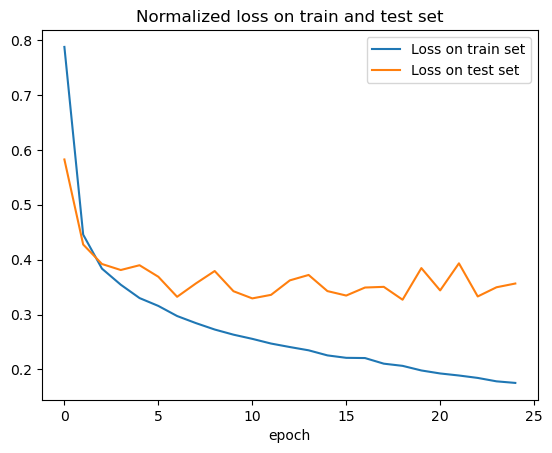

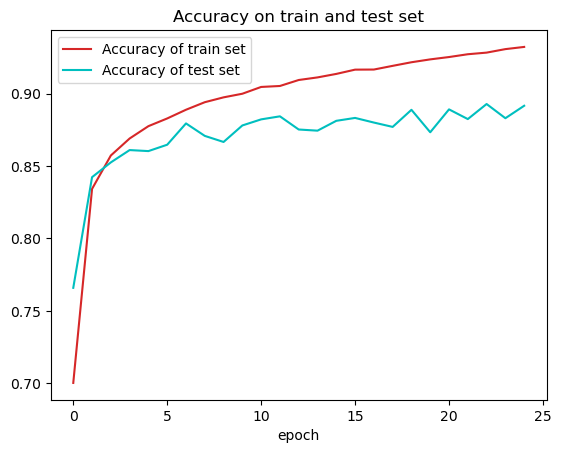

In [256]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [257]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8916


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

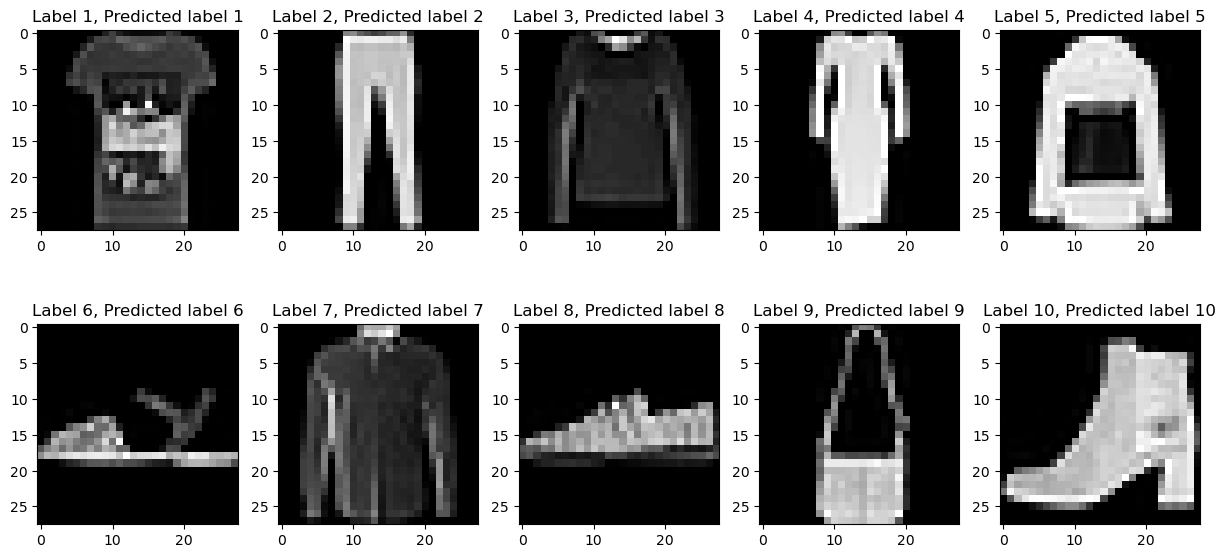

In [274]:
fig2,axs2=plt.subplots(2,5,figsize=(15,7))
rng=np.random.default_rng()
for i in range(10):
    index = rng.integers(len(train_set))
    image, label = train_set[index]
    while (label!=i):
        index = rng.integers(len(train_set))
        image, label = train_set[index]
    image=image.to(device)
    p = model(image, parameters)    
    y_pred = p.argmax(dim=-1)
    axs2[i//5][i%5].title.set_text("Label %i, Predicted label %i" %(i+1,y_pred+1))
    axs2[i//5][i%5].imshow(image.cpu()[0], cmap="gray")
plt.show()